BESP

23  04 19

Bimodal cell cycle and size related genes

Alex Casar / David Goode

****

**Get scShapes classification and bimodality classification**

**Join all info into a table (all genes, all samples, all datasets, all lists)**

**Explore some initial graphics**

In [ ]:
#################
# !!!!!!!! Add

#%%R
#install.packages("ggVennDiagram")
#library(ggVennDiagram)

## Prepare

We allways need this chunck to use R in colab and mount google drive into the sesion

To use R magic in python colab. In 2023 the new rpy2 package was not able to run magic R, using a lower version soved the problem

In [1]:
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=318089 sha256=3b1567311bb6268a62895f9a66413fe10f62f17785dd8b9fd6c737c2e2cdb1d9
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [2]:
# activate R magic
%load_ext rpy2.ipython
# Load drive to use our files
from google.colab import drive
drive.mount('/content/drive')   # Change path

Mounted at /content/drive


## Reload packages and call libraries

We will always use this chunk to call our libraries

In [3]:
# Copy packages file to use it
%cp /content/drive/MyDrive/MELBOURNEbimodal/LIBRARIES/library13.tar.gz .
!tar xf /content/library13.tar.gz 
!rm /content/library13.tar.gz
%R .libPaths('/content/usr/local/lib/R/site-library')   # Change the library used by R binaries


<rpy2.robjects.vectors.StrVector object at 0x7f445659dd00> [RTYPES.STRSXP]
R classes: ('character',)
['/content/..., '/usr/loca..., '/usr/lib/..., '/usr/lib/...]

In [4]:
%%R
# Libraries
library(dplyr)  # Object management
library(Seurat)   # Single cell analysis
library(patchwork)  # Plots suplements
library(Matrix)   # To work/preview sparse matrix; Seurat is capable to.
library(vioplot) # Violin pots
library(ggplot2)  # Plots
#library(tidyverse)  # Data mining


library(Rcpp)   # It makes very simple to connect C++ to R
library(magrittr)   # Decrease development time and improve readability and maintainability of code
#library(clustree)   # Visualise Clusterings at Different Resolutions.

library(BiocParallel)   # Parallel evaluation
library(BiocParallel)   # Parallel evaluation
library(scShapes)   # A Statistical Framework for Modeling and Identifying Differential Distributions in Single-cell RNA-sequencing Data


library(BimodalIndex)
#library(SeuratData)   # mechanism for distributing datasets in the form of Seurat objects using R's internal package and data management 
                        #systems. It represents an easy way for users to get access to datasets that are used in the Seurat vignettes.


install.packages("DescTools")
library(DescTools)  

#library(ggVennDiagram)  # For kiut and easy venn diagrams

library(pheatmap)   # heatmap + clustering plot

library(viridis)  # Kiut ggplot colors
library(reshape)  # To convert matrix to long format required for ggplot

library(iZID)   # New KS-Test

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union





    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    





Attaching package: ‘zoo’



    as.Date, as.Date.numeric


(as ‘lib’ is unspecified)







	‘/tmp/RtmphmmTa1/downloaded_packages’


Attaching package: ‘reshape’



    expand



    rename




## Old new

Here we define what type of data we were going to use

At the end we were more interested in the new data since it had different stages of diasease

In [ ]:
%%R
OLDnew = "OLD"

In [5]:
%%R
OLDnew = "NEW"

## Definitions

In [6]:
%%R
# Parameters
MAX0 <- 0.10  # Keep genes with a certain number (perc.zero percent) of nonzero entries

# Directories
DATAdir <- "/content/drive/MyDrive/MELBOURNEbimodal/DATAinput/"   # Input files
TEMPdir <- "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/"  # Output temporal files
FINALdir <- "/content/drive/MyDrive/MELBOURNEbimodal/FINALdata/"  # Output of relevant files
IMAGEdir <- "/content/drive/MyDrive/MELBOURNEbimodal/IMAGESout/" # Image files





# Statements
set.seed(0xBEEF)
setwd(DATAdir)


# Useful function
`%ni%` <- Negate(`%in%`)

In [7]:
%%R
# Samples metadata: We have two kinds of data: Old data and New data
SAMPLESclass <- list()
SAMPLESclass[["NEW"]] <- data.frame(row.names = c("T0", "M15", "M05", "M02", "M10", "M11", "M07", "M12", "M09"), 
                                    TYPE = c("Vitro", "Vehicle", "Vehicle", "Mid Disease", "Mid Disease", "End Disease", "End Disease", "Post Disease", "Post Disease"),
                                    DAY = c(0, NA, NA, 2,2,5,5,7,7))

SAMPLESclass[["OLD"]] <- data.frame(row.names = c("T0", "M8", "M10"), TYPE = c("Vitro", "Vivo", "Vivo"))



Formating list of genes (20 lists based on G2M and Size-related genes)

Probided by Alex on Feb 23, 2023

In [8]:
%%R
FILE = readLines(paste(DATAdir, "genes_per_mouse_per_goal.txt", sep = ""))
GENESnewLists <- list()
for (LINE in FILE){
    if (grepl("=", LINE, fixed = TRUE)){
        
        LINE <- sub("= \\[", "<- c(", LINE)
        LINE <- sub("]", ")", LINE)
        print(LINE)
        GENESnewLists[[strsplit(LINE, " ")[[1]][1]]] <- eval(parse(text=LINE))
    }
}

[1] "g2m_d0p1 <- c('G2e3', 'Orc6', 'Calm2', 'Jpt1', 'Rnf214', 'Cbx5', 'Cdc20', 'Hells', 'Cenpf', 'Kif4', 'Atad2', 'Arhgap4', 'Ccne1', 'Psen1', 'Tubb5', 'Hmgb2', 'Arl6ip1', 'Kpna2', 'Hinfp', 'Ccne2', 'Plk1', 'Rpa2', 'Ccnb1', 'Rnf7', 'Ndc80', 'Rfc3', 'Top2a', 'Smc2', 'Kif11', 'Slbp', 'Cenpa', 'Cdk1', 'Cdca8', 'Kif20b', 'Birc5', 'Uhrf1', 'Sapcd2', 'Cdca3', 'Ube2s', 'Cdca7', 'Cenpl', 'Spc25', 'Mis18bp1', 'Depdc1a', 'Mcm3', 'Srp54a', 'Ppm1g', 'Mki67', 'Bub3', 'Aurka', 'Ubb', 'Tubb4b', 'Nme7', 'Atp11c', 'Cdkn2d', 'Malat1', 'Ube2c', 'Tpx2', 'Sgo2a', 'Prc1', 'Hist1h1b', 'Hmmr', 'Rangap1', 'Kif23', 'Parpbp', 'Cenpe', 'Cks2', 'Tuba1c', 'Ctcf', 'Pcna', 'Ckap2l', 'Cd47', 'Smc1a', 'Kifc1', 'Ung', 'Smc4', 'Aurkb', 'Nusap1')"
[1] "g2m_d0p2 <- c('G2e3', 'Orc6', 'Calm2', 'Jpt1', 'Cbx5', 'Cdc20', 'Hells', 'Cenpf', 'Pomgnt1', 'Nasp', 'Atad2', 'Ccne1', 'H2afx', 'Tubb5', 'Hmgb2', 'Arl6ip1', 'Kpna2', 'Cenpc1', 'Ccne2', 'Plk1', 'Rpa2', 'Ccnb1', 'Ogfod1', 'Ndc80', 'AI314180', 'Rfc3', 'Top2a', 'Smc2', 'Kif11',

In [9]:
%%R
# Relevant genes: First list
Sgenes <- c("Mcm5","Pcna","Tyms","Fen1","Mcm2","Mcm4","Rrm1","Ung","Gins2","Mcm6","Cdca7","Dtl","Prim1","Uhrf1","Mlf1ip","Hells","Rfc2","Rpa2","Nasp","Rad51ap1","Gmnn","Wdr76","Slbp","Ccne2","Ubr7","Pold3","Msh2","Atad2","Rad51","Rrm2","Cdc45","Cdc6","Exo1","Tipin","Dscc1","Blm","Casp8ap2","Usp1","Clspn","Pola1","Chaf1b","Brip1","E2f8")
G2Mgenes <- c("Hmgb2","Cdk1","Nusap1","Ube2c","Birc5","Tpx2","Top2a","Ndc80","Cks2","Nuf2","Cks1b","Mki67","Tmpo","Cenpf","Tacc3","Fam64a","Smc4","Ccnb2","Ckap2l","Ckap2","AurkB","Bub1","Kif11","Anp32e","Tubb4b","Gtse1","Kif20b","Hjurp","Cdca3","Hn1","Cdc20","Ttk","Cdc25c","Kif2c","Rangap1","Ncapd2","Dlgap5","Cdca2","Cdca8","Ect2","Kif23","Hmmr","Aurka","Psrc1","Anln","Lbr","Ckap5","Cenpe","Ctcf","Nek2","G2e3","Gas2l3","Cbx5","Cenpa")
GENES <- list(S = Sgenes, G2M = G2Mgenes)

# Ad it to the list of lists
GENESnewLists[["SvsG2M"]] <- unlist(GENES)

## Read data

In [ ]:
%%R
SEUR <- readRDS(paste(DATAdir, OLDnew, "-BESP-CleanRed3000-AllSamSeu.Rds", sep = ""))
COUNTS <- lapply(SEUR, function (x) x@assays$RNA@counts)

## scShapes classification

Finally, we are going to classify our genes in different distributions using scShapes.

We have 4 main changes.


*   First; we used scShapes as dictated in the [Malindrie source manual](https://github.com/Malindrie/scShapes)
*   Second; we change the BIC discriminator of viable models by the more flexible AIC
*   Third; we perform a more complete and flexible KS-Test. Then we add the genes that pass this last KS-Test into the scShapes pipeline. To do it we have to skip the KS-Test part in the scShapes source pipeline
*   Four; to estimate the PI parameter, we use some function in the scShapes library and modify the return of a function in scShapes.



### Main functions

We redefine the information discriminant between models.

AIC is best in this case. It does not penilizes the number of parameters

In [ ]:
%%R
# It is the same function than scShapes defined functions in github
model_BIC <- function(z){
  ifelse((!is(z, "character")),
         stats::AIC(z), "NA")   # AIC instead of BIC
}

We redefine the KS-test function

To estimate the KS-Test index, scShapes creates a model to fit the data into a ZIM. The model can be used to predict new outcomes or estimate parameters like ᶲ (PI). ᶲ (PI) is the probability of zero inflation in our data; therefore, it can be an estimator of the zero inflation.

We will redefine the function to return the ᶲ (PI) index if needed.

In [ ]:
%%R
# KS TEST to deliver the ZI value
ks_test <- function(counts, cexpr, lib.size,
                    formula=NULL, ZIP = FALSE, BPPARAM){


  #Formulate a simple additive model using all the covariates in 'cexpr'
  covariates <- names(cexpr)
  if(is.null(formula)) {
    message(sprintf("Formulating the additive model..."))
    formula <- 'x ~ 1 '
    if(!identical(covariates, NULL)) {
      for (covar in covariates) {
        formula <- paste(formula, sprintf(' + %s', covar))
      }
    }
  }
  formula <- as.formula(formula)

  #convert data to lists
  if(!identical(covariates, NULL)) {
    gexpr <- apply(counts, 1, function (x) cbind(x,cexpr))
  } else{
    gexpr <- apply(counts, 1, function (x) as.list(as.data.frame(x)))
  }

  #KS test with simulated p-values
  message(sprintf("Performing the KS test..."))
  KS_ZINB <- function(data, formula, lib.size){

    m1 <- tryCatch(pscl::zeroinfl(formula, data, offset=log(lib.size), dist = "negbin"), error = function(e) {print(e$message)})

    if(!is(m1, "character")){
      pi_ML = predict(m1, type = "zero")[1]
      theta_ML = m1$theta
      mean_ML = predict(m1, type = "count")
      var_ML = mean_ML + (mean_ML ^ 2 / theta_ML)
      ccc = rbind(pi_ML, theta_ML, mean_ML)
      if (ZIP == TRUE){
      return(pi_ML)
  }

    }
    else {
      ccc = "NA"
    }


    if(!is(ccc, "character")){

      pp <- tryCatch(VGAM::rzinegbin(n = length(data$x),
                          size = ccc[2,],
                          munb = ccc[3,],
                          pstr0 = ccc[1,]),
                     error = function(e) {print(e$message)})
    }
    else {
      pp <- "NA"
    }

    if(!is(pp, "character")){

      D <- tryCatch(dgof::ks.test(data$x, ecdf(pp), simulate.p.value = TRUE)$p.value, error = function(e) {print(e$message)})
    }
    else {
      D <- "NA"
    }

    if(!is(D, "character")){

      p_value <- D
    }
    else {
      p_value <- "NA"
    }

    return(p_value)
  }


  if(identical(covariates, NULL)) {
    ks.pval.unadj <- BiocParallel::bplapply(gexpr,
                                            FUN = KS_ZINB,
                                            BPPARAM = BPPARAM,
                                            formula <- formula,
                                            lib.size <- lib.size)
  } else {
    ks.pval.unadj <- BiocParallel::bplapply(gexpr,
                                            FUN = KS_ZINB,
                                            BPPARAM = BPPARAM,
                                            formula <- formula,
                                            lib.size <- lib.size)
  }
  
  return(ks.pval.unadj)
  

}



In [ ]:
%%R
# Function of scShapes for one sample without comparisons
fSCshapes <- function(MATRIX, GENESinterest, MAX0, VARIABLE=0, ZIP = FALSE, KS = FALSE, FORSE = FALSE){
    # We trace in each main step of filtering the amount and identity of genes.
    NUMgenes <- c("Inicial" = length(row.names(MATRIX)[row.names(MATRIX) %in% GENESinterest]))
    GENEtrace <- list()
    GENEtrace[["Inicial"]] <- row.names(MATRIX)[row.names(MATRIX) %in% GENESinterest]
    
    # Select variables to use
    if (VARIABLE == 0){
        # To know the cell names and variables to use: whole dataset
        COMPcellVars <- data.frame(row.names = colnames(MATRIX))
    }else{
        # To know the cell names and variables to use: whole dataset
        COMPcellVars <- data.frame(
        cell.type = factor(MATRIX@meta.data[VARIABLE]),
        row.names = colnames(MATRIX))
    }
    
    print(dim(MATRIX))
    # Filter unwanted genes
    # This function is used to preprocess matrix of read counts to only keep genes with a certain number 
    # (perc.zero percent) of nonzero entries: Whole dataset
    COMPfilter <- filter_counts(MATRIX, perc.zero = MAX0); print("Pasa3")
    # Which/how much genes remain after removing genes expressed in less than 10% of cells
    GENEtrace[["Zero"]] <- row.names(COMPfilter); print("Pasa4") 
    NUMgenes <- c(NUMgenes, "ZeroRemove" = length(rownames(COMPfilter)[rownames(COMPfilter) %in% GENESinterest])); print("Pasa5")
    
    # For normalization
    # To get the total rna counts per cell for further normalization: Filtered dataset
    COMPcellNum <- apply(COMPfilter, 2, sum)
    
    # In case we may want to forse the model fitting (skip KS-Test)
    CNTRLkSig <- GENESinterest

    #Subset the Genes of interest
    COUNTSinterest <- COMPfilter[rownames(COMPfilter) %in% GENESinterest,]
    print("Pasa4")
    
    # We can skip the KS-Test and adjustment of ZINB model if we already have selected the genes with ZIM behaviour 
    # To FORSE == F allow us to repeat only KS-Test (KS == T) or get the (PI) score (ZIP == TRUE)
    if (FORSE == FALSE){  
        print("KS-Test execution")  # We test genes for KS-Test and use the results to filter unwanted genes
        
        # Kolmogorv-Smirnov
        # Perform Kolmogorv-Smirnov test on the filtered sparse counts matrix from filter_counts to select genes 
        # belonging to the family of ZINB distributions
        CNTRLks <- ks_test(COUNTSinterest, cexpr=COMPcellVars, lib.size=COMPcellNum, BPPARAM=bpparam(), ZIP = ZIP)
  
        if (ZIP == TRUE){   # If ZIP == T, CNTRLks is 
            print(CNTRLks)
            return(CNTRLks)
        }
        if (KS == TRUE){  # If we only need to know the KS-Test return. If KS == TRUE => ZIP == FALSE. But, we may want to continue the pipeline
            # Select genes significant from the KS test. By default the 'ks_sig' function performs Benjamini-Hochberg correction for 
            # multiple hypothese testing and selects genes significant at p-value of 0.01
            CNTRLkSig <- ks_sig(CNTRLks)$genes
            print("Saving KS")
            return(CNTRLkSig)
        }
        
    }
    print("Pasa5")
    # Which/how much genes can be defined as ZIM
    GENEtrace[["KS"]] <- CNTRLkSig
    NUMgenes <- c(NUMgenes, "KSfilter" = length(CNTRLkSig))
    
    # Subset UMI counts corresponding to the genes significant from the KS test
    CNTRLks <- COMPfilter[rownames(COMPfilter) %in% CNTRLkSig, ]
    
    # GLM fitting for each distribution and choosing
    # Fit_models is used to fit genes with GLM. For each distribution, fit the data (We will care then for the accuracy, now, just fit the data)
    CNTRLfit <- fit_models(counts=CNTRLks, cexpr=COMPcellVars, lib.size=COMPcellNum, BPPARAM=bpparam())
    
    # Get significative results. For each gene in each distribution, how much the data is represented by the model?
    CNTRLbicVal <- model_bic(CNTRLfit)
    
    # Select model with least bic value. lbic_model is used to select the best fit model for each gene based on the least BIC value
    # Selects dataset counts for each valid model
    CNTRLbic <- lbic_model(CNTRLbicVal, CNTRLks)
    print(str(CNTRLbic))
    
    # gof_model is used to perform the likelihood ratio test on the models chosen based on the BIC values from best_model to check for model adequacy. 
    # For each gene and pre setted distribution, a value is given
    print("PASA lbic")
    CNTRLgof <- gof_model(CNTRLbic, COMPcellVars, COMPcellNum, BPPARAM=bpparam())
    
    # select_model is used to select the distribution of best fit for scRNA-seq count data. Which genes in which distributions
    print("PASA gof")
    CNTRLmodel <- select_model(CNTRLgof)
    
    # Which/how much genes remain after selecting suitable models?
    GENEtrace[["GOF"]] <- unlist(CNTRLmodel)
    NUMgenes <- c(NUMgenes, "GOFilter" = length(unlist(CNTRLmodel)))
    
    # model_param returns model parameters and distribution values based on the best fit distribution as selected by distr_fit and models 
    # fitted by fit_models. 
    CNTRLparam <- model_param (CNTRLfit, CNTRLmodel, model=NULL)

    gc()

    return(list(RESULT = CNTRLmodel, NUMgenes = NUMgenes))

}

### First genes filter

We gather all genes present in at least one sample

In [ ]:
%%R
# Which genes are present in at least one sample? Those are our new genes of interest
ALLgenes <- list()
for (LISTS in names(GENESnewLists)){
    print(LISTS)
    GENES <- list()
    for (SAMPLE in names(SEUR)){
        GENES[[SAMPLE]] <- GENESnewLists[[LISTS]][GENESnewLists[[LISTS]] %in% row.names(SEUR[[SAMPLE]])]
        print(length(GENES[[SAMPLE]]))
    }
    ALLgenes[[LISTS]] <- Reduce(intersect, GENES)
    print(length(ALLgenes[[LISTS]]))
}

[1] "g2m_d0p1"
[1] 67
[1] 67
[1] 67
[1] 57
[1] 66
[1] 53
[1] 60
[1] 62
[1] 51
[1] 44
[1] "g2m_d0p2"
[1] 76
[1] 82
[1] 81
[1] 69
[1] 78
[1] 65
[1] 73
[1] 79
[1] 63
[1] 51
[1] "g2m_d2m02"
[1] 53
[1] 58
[1] 59
[1] 54
[1] 57
[1] 53
[1] 54
[1] 56
[1] 51
[1] 34
[1] "g2m_d2m10"
[1] 55
[1] 58
[1] 57
[1] 50
[1] 55
[1] 55
[1] 53
[1] 52
[1] 45
[1] 32
[1] "g2m_d5m07"
[1] 44
[1] 48
[1] 47
[1] 43
[1] 44
[1] 38
[1] 43
[1] 44
[1] 41
[1] 32
[1] "g2m_d5m11"
[1] 59
[1] 63
[1] 60
[1] 64
[1] 61
[1] 59
[1] 57
[1] 64
[1] 57
[1] 41
[1] "g2m_d7m09"
[1] 33
[1] 36
[1] 35
[1] 30
[1] 33
[1] 26
[1] 34
[1] 30
[1] 28
[1] 20
[1] "g2m_d7m12"
[1] 47
[1] 52
[1] 51
[1] 44
[1] 45
[1] 45
[1] 51
[1] 52
[1] 49
[1] 36
[1] "g2m_dvm05"
[1] 54
[1] 64
[1] 64
[1] 58
[1] 61
[1] 49
[1] 57
[1] 61
[1] 50
[1] 40
[1] "g2m_dvm15"
[1] 50
[1] 61
[1] 60
[1] 54
[1] 56
[1] 45
[1] 55
[1] 56
[1] 47
[1] 35
[1] "size_d0p1"
[1] 30
[1] 36
[1] 36
[1] 29
[1] 28
[1] 35
[1] 38
[1] 36
[1] 37
[1] 18
[1] "size_d0p2"
[1] 32
[1] 39
[1] 35
[1] 28
[1] 38
[1] 3

### Repeat KS-Test (scShapes)

Although we defined a seed, the function can have differernt outputs in different iteraations.

This may be a consecuence of the model generation.

Therefore, we will repeat the scShapes pipeline until KS-Test. 

In [ ]:
%%R
for (LIST in names(ALLgenes)[8]){
    REP = 10 # How many times repeat the KS-Test
    # Which genes are in at least one sample (We need this data for the table; We save time and resources)
    GENES <- ALLgenes[[LIST]][ALLgenes[[LIST]] %in% ALLgenes]

    GENES <- unique(GENES)
    print(GENES)

    for (i in "M12"){
        print(i)
        #TEMP <- list()
        for (j in 1:REP){  # REP repetitions
            print(j)
            TEMP <- fSCshapes(COUNTS[[i]], GENES, MAX0, ZIP = FALSE, KS = TRUE); gc()
            GENESt <- TEMP[["RESULT"]]
            # We can not afford saving all the results at the same time   
            saveRDS(TEMP, paste(TEMPdir, "KSnRep-", LIST, "-", i, "-", OLDnew, "-", j, ".Rds", sep = "")); gc()  
        }  
    }
    break
}

 [1] "Nudcd2"   "Casp8ap2" "Calm2"    "Jpt1"     "Cdc20"    "Cenpf"   
 [7] "Cx3cr1"   "Kif4"     "Frg1"     "Creb1"    "Arl6ip1"  "Kpna2"   
[13] "Malt1"    "E2f2"     "Plk1"     "Rpa2"     "Ccnb1"    "Ndc80"   
[19] "Rfc3"     "Smc2"     "Top2a"    "Kif11"    "Troap"    "Cdk1"    
[25] "Cdca8"    "Itch"     "Mcm2"     "Kif20b"   "Birc5"    "Sapcd2"  
[31] "Ube2s"    "Depdc1a"  "AY036118" "Pif1"     "Bub3"     "Kif22"   
[37] "Aurka"    "Zfp318"   "Tubb4b"   "Skp2"     "Ube2c"    "Fam43a"  
[43] "Gas2l3"   "Tpx2"     "Prc1"     "Cpeb4"    "Aspm"     "Cks2"    
[49] "Incenp"   "Prr11"    "Ckap2l"   "Senp7"    "Cacybp"   "Ung"     
[55] "Smc4"     "Aurkb"    "Nusap1"  
[1] "M12"
[1] 1
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 2
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 3
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 4
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 5
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 6
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 7
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 8
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 9
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"
[1] 10
[1] 3000  861
[1] 3000  861
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


[1] "invalid dependent variable, minimum count is not zero"
[1] "Saving KS"


In [ ]:
%%R
A <- FINALtable[FINALtable$List == "g2m_d0p1" & FINALtable$Gene == "Aurka",]
A

     Gene Sample     List Dataset Distribution       BI Bimodality        PI
2   Aurka    M02 g2m_d0p1     NEW          ZIP 1.207568    Bimodal 0.1019328
49  Aurka    M12 g2m_d0p1     NEW         <NA> 1.323903    Bimodal 0.0347904
102 Aurka    M15 g2m_d0p1     NEW           NB 1.347875    Bimodal 0.1354842
      G1prop Expression
2   4.848485  0.5218216
49  7.153966  0.7468060
102 6.565657  0.4146597


#### Once we run all repetitions for all lists of genes, we gather the results

In [ ]:
%%R
# In case we split the repetitions, we integrate the results from one sample
NEW <- list()
for (LISTS in names(GENESnewLists)[8]){   # For each list of genes
    print(LISTS)
    for (SAMPLE in row.names(SAMPLESclass[[OLDnew]])[8]){  # We have a result for each combination of sample/repetition/list
        print(SAMPLE)
        FILES <- list.files(path = TEMPdir, pattern = paste("KSnRep-", LISTS, "-", SAMPLE, sep = ""))   # We read all repetitions of KS-Test
        NEW <- list()

        # We gather all results
        for (FILE in paste(TEMPdir, FILES, sep = "")){
            print(FILE)
            NEW[[strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]]] <- names(readRDS(FILE))
        }
        print(str(NEW))
        print(paste(TEMPdir, "KSrep10-", LISTS, "-", OLDnew, "-", SAMPLE, ".Rds", sep = ""))
        saveRDS(NEW, paste(TEMPdir, "KSrep10-", LISTS, "-", OLDnew, "-", SAMPLE, ".Rds", sep = ""))  # And save the results in a fnal file
    }
}

[1] "g2m_d7m12"
[1] "M12"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-1.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-10.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-2.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-3.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-4.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-5.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-6.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-7.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-8.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSnRep-g2m_d7m12-M12-NEW-9.Rds"
List of 1
 $ NEW: chr [1:37] "Cx3cr1" "Cdc20" "Ung" "Tubb4b" ...
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimoda

#### Once we have all results, we start analysing

First, which proportion of genes is recovered in each iteration?

[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d0p1-NEW-M02.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d0p1-NEW-M12.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d0p1-NEW-M15.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d0p2-NEW-M02.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d0p2-NEW-M12.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d0p2-NEW-M15.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d2m02-NEW-M02.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d2m02-NEW-M12.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d2m02-NEW-M15.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d2m10-NEW-M02.Rds"
NULL
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/KSrep10-g2m_d2m10-NEW-M12.Rds"
NULL
[1] "/content/dr

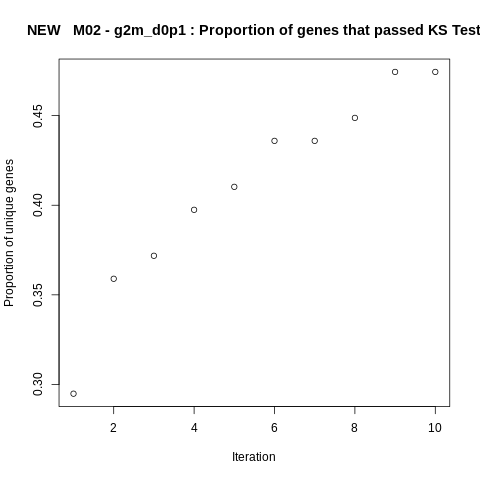

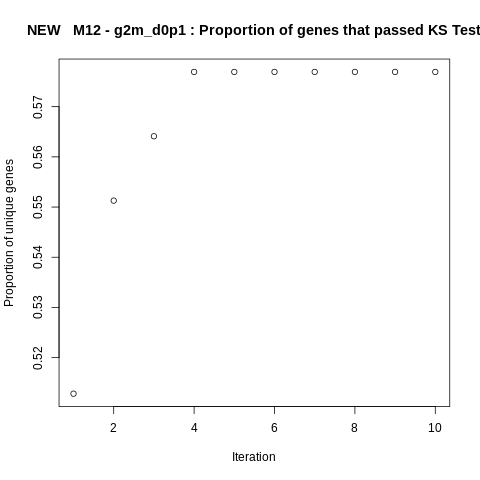

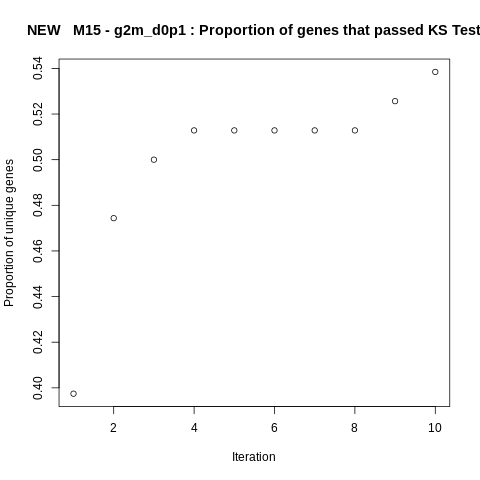

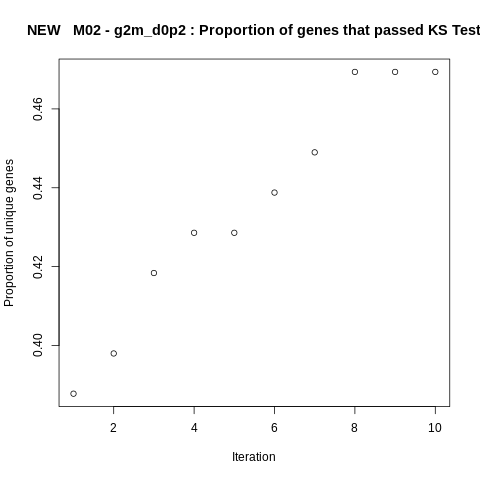

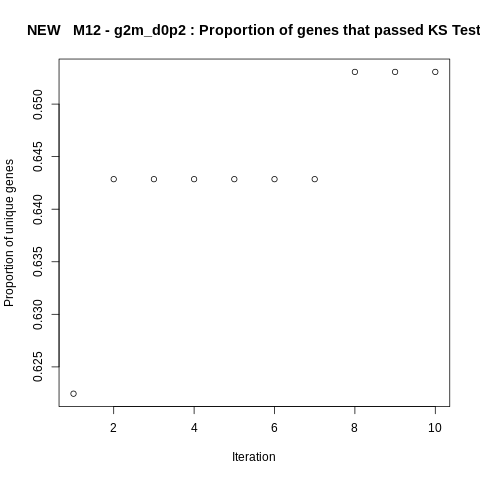

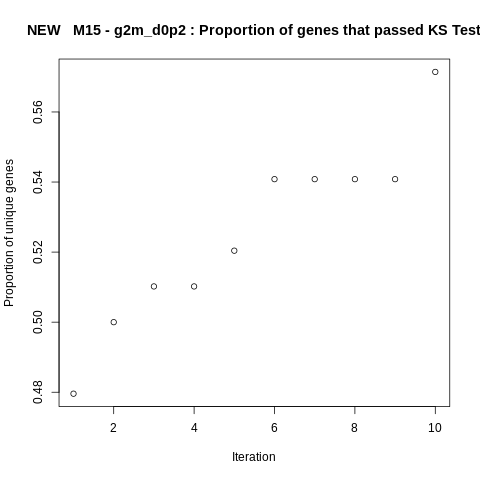

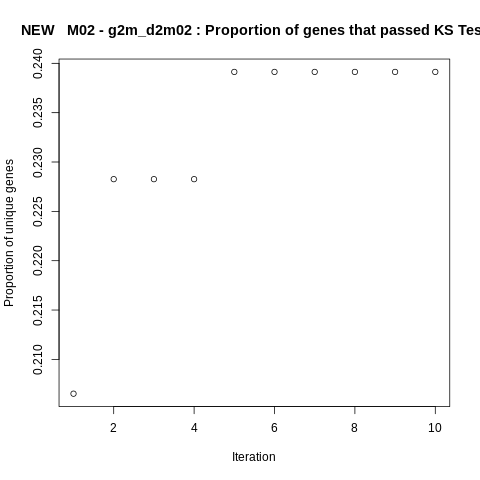

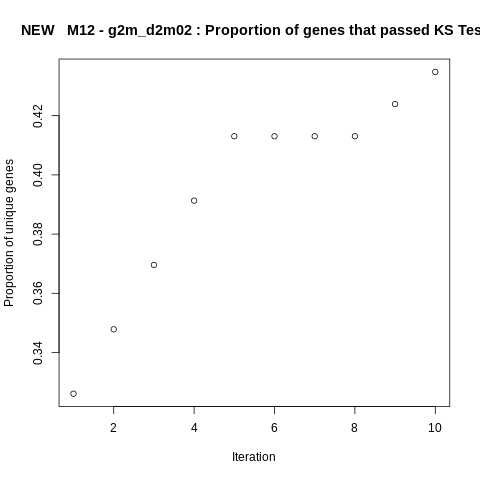

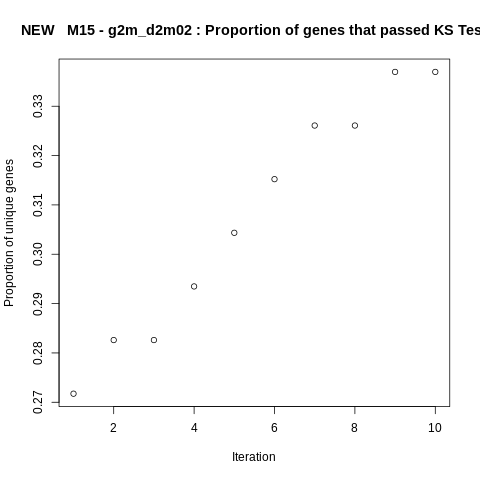

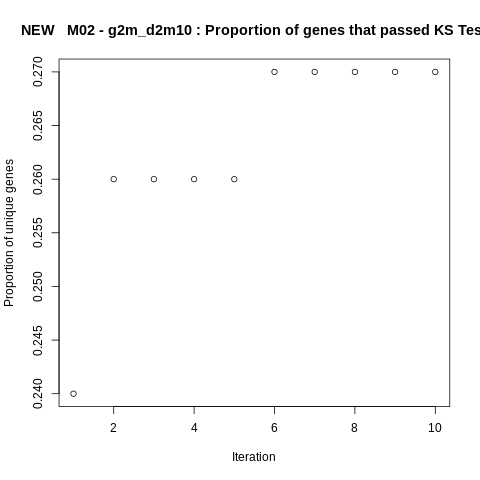

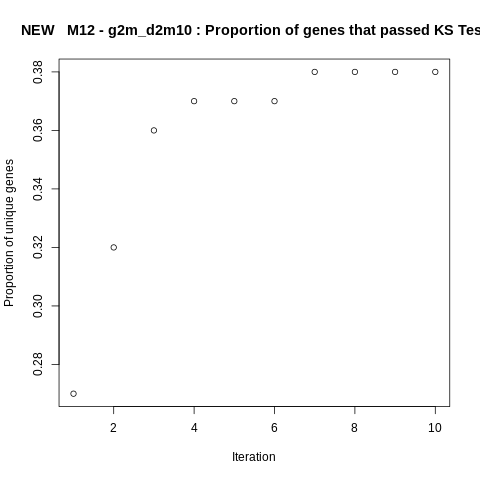

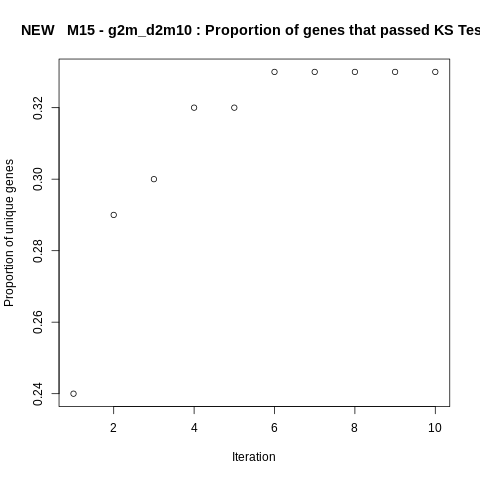

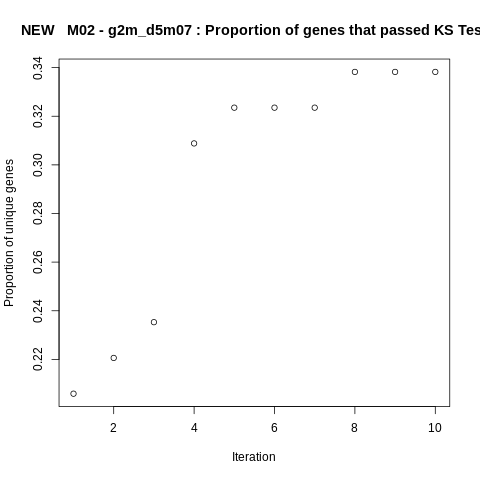

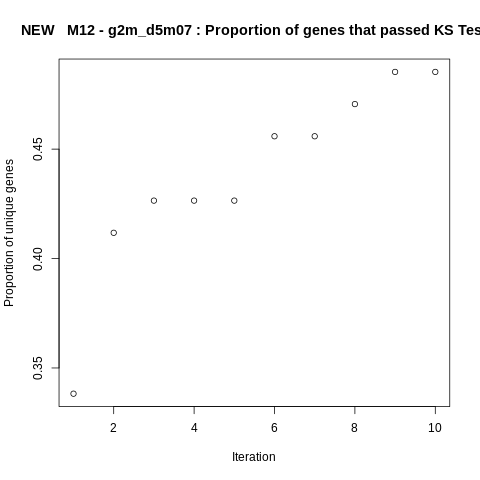

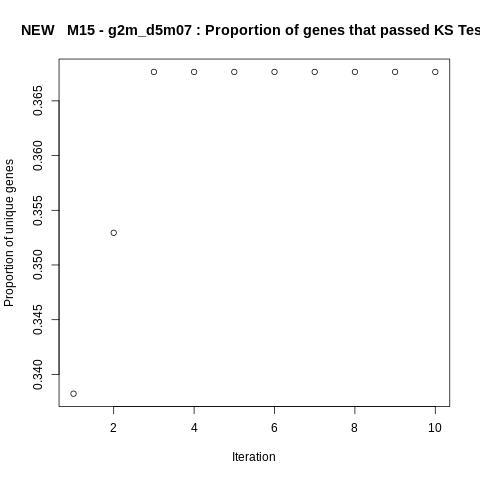

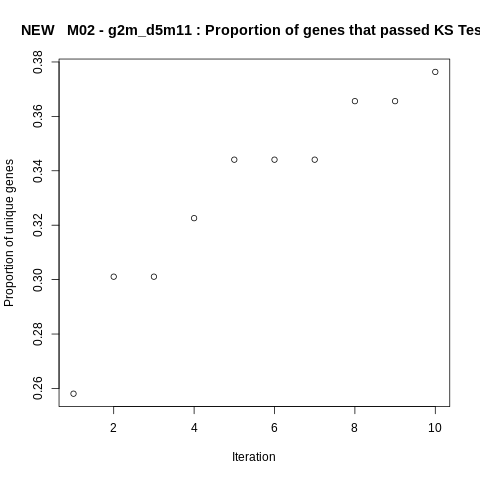

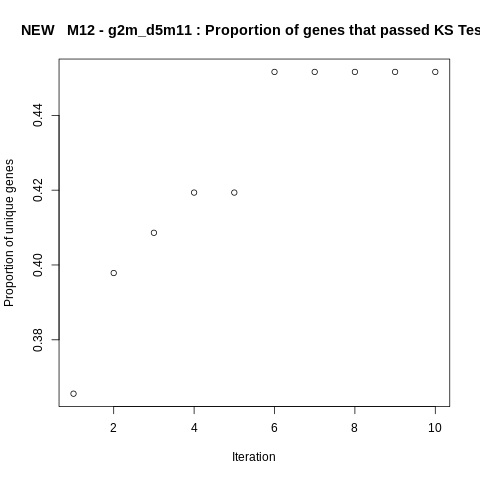

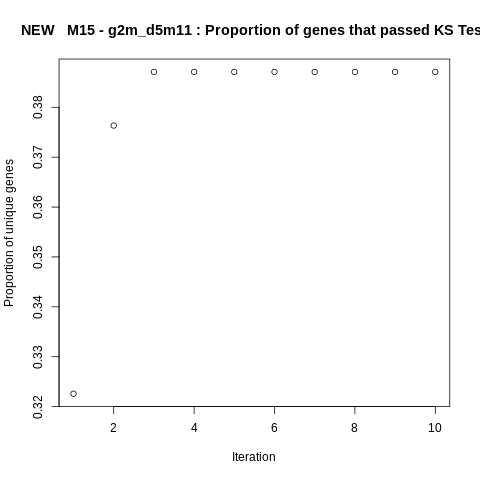

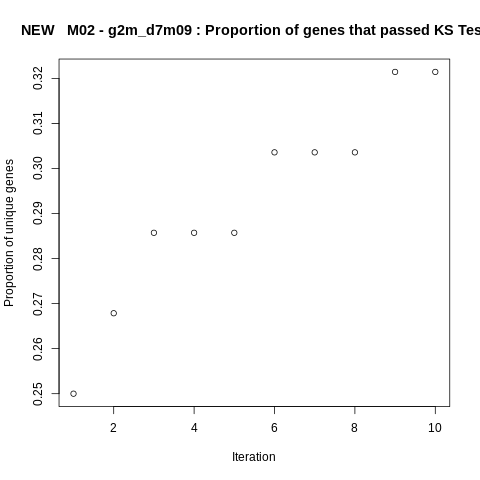

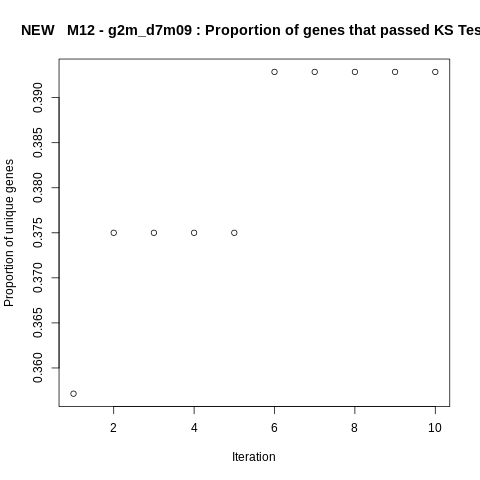

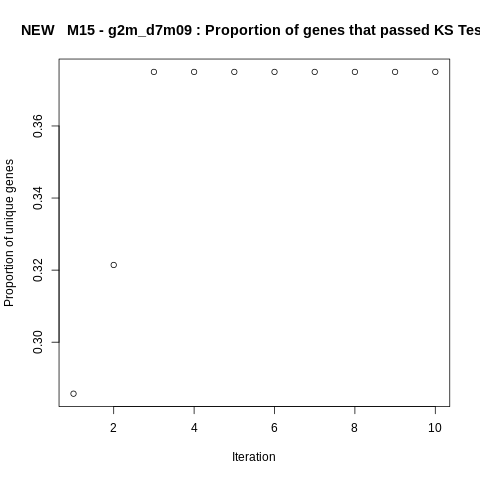

In [ ]:
%%R
# Extract significant genes
FILES <- list.files(path = TEMPdir, pattern = "KSrep10")  # For each sample, we have a file with all respetitions of the KS-Test
GENESrep <- list()
for (FILE in paste(TEMPdir, FILES, sep = "")){
    print(FILE)
    TEMP <- readRDS(FILE)
    NEW <- c()
    GENES <- c()
    LISTS <- strsplit(FILE, "-")[[1]][2]
    SAMPLE <- strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]
    DATASET <- strsplit(strsplit(FILE, "-")[[1]][3], "[.]")[[1]][1]
    for (REP in TEMP){
        GENES <- unique(c(GENES, REP))
        NEW <- c(NEW, length(GENES))  # We count and save how many genes are in the repetitions 0, 1 ..., REP-1, REP
    }

    NEW <- NEW/length(GENESnewLists[[LISTS]])   # We are interested in proportion of recovered genes instead of raw counts

    # We plot this (Proportion of recovered genes after x iteraations)
    print(plot(NEW, xlab = "Iteration", ylab = "Proportion of unique genes", main = paste(DATASET, " ", SAMPLE, "-", LISTS, ": Proportion of genes that passed KS Test")))
    
}

Which are the genes we recover for each sample?

In [ ]:
%%R
FILES <- list.files(path = TEMPdir, pattern = "KSrep")  # For each sample, we have a file with all respetitions of the KS-Test
for (FILE in paste(TEMPdir, FILES, sep = "")){
    # Save genes that appear at least once
    SAMPLE <- strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]
    LISTS <- strsplit(FILE, "-")[[1]][2]
    DATASET <- strsplit(strsplit(FILE, "-")[[1]][3], "[.]")[[1]][1]
    RES <- readRDS(FILE)
    GENES <- unique(unlist(RES))  # List of final genes recovered by the KS-Test for each sample
    print(GENES)
    print(paste(TEMPdir, "GENESpass", "-", LISTS, "-", SAMPLE, "-", OLDnew, ".Rds", sep = ""))
    saveRDS(GENES, paste(TEMPdir, "GENESpass", "-", LISTS, "-", DATASET, "-", SAMPLE, ".Rds", sep = ""))
}

 [1] "Ung"      "Ccne1"    "Ccne2"    "Cdkn2d"   "Tpx2"     "Spc25"   
 [7] "Kif20b"   "Kif23"    "Cdca8"    "Kif4"     "Atad2"    "Mis18bp1"
[13] "Aurka"    "Ndc80"    "Hells"    "Uhrf1"    "Hist1h1b" "Depdc1a" 
[19] "Cbx5"     "Smc1a"    "Sapcd2"   "Mcm3"     "Cdca7"    "Cdc20"   
[25] "Tuba1c"   "Plk1"     "Jpt1"     "Ckap2l"   "Bub3"     "Kpna2"   
[31] "Prc1"     "Ube2s"    "Aurkb"    "Ubb"      "Cdca3"    "Mki67"   
[37] "Cenpe"   
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/GENESpass-g2m_d0p1-M02-NEW.Rds"
 [1] "Ccne1"    "Ccne2"    "Cenpe"    "Cdc20"    "Ung"      "Mki67"   
 [7] "Kif11"    "Plk1"     "Hmmr"     "Hells"    "Cdkn2d"   "Aurka"   
[13] "Kif20b"   "Tuba1c"   "Spc25"    "Kif23"    "Pcna"     "Uhrf1"   
[19] "Rfc3"     "Cdca7"    "Kif4"     "Sapcd2"   "Depdc1a"  "Ube2s"   
[25] "Sgo2a"    "Atad2"    "Mis18bp1" "Calm2"    "G2e3"     "Rpa2"    
[31] "Ckap2l"   "Jpt1"     "Kifc1"    "Cdca3"    "Smc4"     "Cbx5"    
[37] "Orc6"     "Ndc80"    "Cenpl"    "Slbp"  

### ZI (PI) value excraction for final genes

Once we define the genes that may show a ZI behaviour, we estimate the (PI) parameter for each gene in each sample.

This parameter reflects the ZI proportion

In [ ]:
%%R
# ZIV extraction
FILES <- list.files(path = TEMPdir, pattern = "GENESpass")  # The files that have the genes of interest
for (FILE in paste(TEMPdir, FILES, sep = "")){   # For each Sample
    print(FILE)
    SAMPLE <- strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]
    DATASET <- strsplit(FILE, "-")[[1]][3]
    LISTS <- strsplit(FILE, "-")[[1]][2]
    GENESoi <- readRDS(FILE)

    
    TEMP <- fSCshapes(COUNTS[[SAMPLE]], GENESoi, MAX0, VARIABLE=0, ZIP = TRUE, KS = FALSE); gc() 
    print(length(TEMP))
    saveRDS(TEMP, paste(TEMPdir, "ZIV-", LISTS, "-", SAMPLE, "-", DATASET, ".Rds", sep = "")); gc()
}

[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/GENESpass-g2m_d0p1-NEW-M02.Rds"
[1] 3000 1581
[1] 3000 1581
[1] "Pasa3"
[1] "Pasa4"
[1] "Pasa5"
[1] "Pasa4"
[1] "KS-Test execution"


$Mki67
CGGGACTAGATCGGTG_1 
        0.03280429 

$Kpna2
CGGGACTAGATCGGTG_1 
         0.1094334 

$Ung
CGGGACTAGATCGGTG_1 
         0.4416953 

$Cenpe
CGGGACTAGATCGGTG_1 
         0.0356629 

$Cdc20
CGGGACTAGATCGGTG_1 
         0.1120223 

$Tuba1c
CGGGACTAGATCGGTG_1 
        0.02451773 

$Prc1
CGGGACTAGATCGGTG_1 
        0.06993239 

$Ccne1
CGGGACTAGATCGGTG_1 
         0.1765288 

$Ccne2
CGGGACTAGATCGGTG_1 
        0.05794827 

$Plk1
CGGGACTAGATCGGTG_1 
         0.1036284 

$Bub3
CGGGACTAGATCGGTG_1 
       0.006576226 

$Cdkn2d
CGGGACTAGATCGGTG_1 
      3.974938e-05 

$Tpx2
CGGGACTAGATCGGTG_1 
        0.05995109 

$Jpt1
CGGGACTAGATCGGTG_1 
      0.0001636075 

$Spc25
CGGGACTAGATCGGTG_1 
        0.04605955 

$Kif20b
CGGGACTAGATCGGTG_1 
        0.09709944 

$Kif23
CGGGACTAGATCGGTG_1 
        4.8842e-05 

$Cdca8
CGGGACTAGATCGGTG_1 
        0.05653358 

$Aurkb
CGGGACTAGATCGGTG_1 
         0.1337744 

$Ubb
CGGGACTAGATCGGTG_1 
      3.939752e-05 

$Kif4
CGGGACTAGATCGGTG_1 
      0.0005587065 


$Ccne1
ATGAGTCAGTAGATCA_2 
         0.3492761 

$Ccne2
ATGAGTCAGTAGATCA_2 
         0.3047676 

$Cenpe
ATGAGTCAGTAGATCA_2 
        0.07101575 

$Cdc20
ATGAGTCAGTAGATCA_2 
         0.1496156 

$Ung
ATGAGTCAGTAGATCA_2 
         0.4762074 

$Cdk1
ATGAGTCAGTAGATCA_2 
        0.04326708 

$Mki67
ATGAGTCAGTAGATCA_2 
        0.02633891 

$Kif11
ATGAGTCAGTAGATCA_2 
        0.04742223 

$Plk1
ATGAGTCAGTAGATCA_2 
         0.1584246 

$Hmmr
ATGAGTCAGTAGATCA_2 
         0.1094514 

$Hells
ATGAGTCAGTAGATCA_2 
         0.0942309 

$Cdkn2d
ATGAGTCAGTAGATCA_2 
      2.095561e-05 

$Tpx2
ATGAGTCAGTAGATCA_2 
        0.06888179 

$Aurka
ATGAGTCAGTAGATCA_2 
         0.0347904 

$Kif20b
ATGAGTCAGTAGATCA_2 
         0.0386156 

$Tuba1c
ATGAGTCAGTAGATCA_2 
      0.0007615775 

$Spc25
ATGAGTCAGTAGATCA_2 
        0.04796662 

$Bub3
ATGAGTCAGTAGATCA_2 
      2.086371e-06 

$Kif23
ATGAGTCAGTAGATCA_2 
        0.08139461 

$Pcna
ATGAGTCAGTAGATCA_2 
       0.007104968 

$Uhrf1
ATGAGTCAGTAGATCA_2 
        0.03901106

$Cdc20
CCGGTAGCATGGCTAT_1 
         0.1768693 

$Cenpe
CCGGTAGCATGGCTAT_1 
         0.1435323 

$Kpna2
CCGGTAGCATGGCTAT_1 
      2.178133e-05 

$Plk1
CCGGTAGCATGGCTAT_1 
         0.3403556 

$Tpx2
CCGGTAGCATGGCTAT_1 
         0.1715877 

$Jpt1
CCGGTAGCATGGCTAT_1 
      2.680061e-06 

$Kif23
CCGGTAGCATGGCTAT_1 
        0.08590877 

$Cdca8
CCGGTAGCATGGCTAT_1 
         0.1264147 

$Aurka
CCGGTAGCATGGCTAT_1 
         0.1354842 

$Kif20b
CCGGTAGCATGGCTAT_1 
         0.1221721 

$Cdca3
CCGGTAGCATGGCTAT_1 
         0.1670993 

$Pcna
CCGGTAGCATGGCTAT_1 
        0.01379652 

$Ccne1
CCGGTAGCATGGCTAT_1 
         0.4810269 

$Spc25
CCGGTAGCATGGCTAT_1 
         0.1983284 

$Cdkn2d
CCGGTAGCATGGCTAT_1 
       0.001519868 

$Ckap2l
CCGGTAGCATGGCTAT_1 
         0.1325929 

$Ccne2
CCGGTAGCATGGCTAT_1 
         0.4748522 

$Bub3
CCGGTAGCATGGCTAT_1 
       0.005499671 

$Ung
CCGGTAGCATGGCTAT_1 
         0.5127362 

$Aurkb
CCGGTAGCATGGCTAT_1 
         0.1801643 

$Uhrf1
CCGGTAGCATGGCTAT_1 
      4.834391e-0

$Ccnb1
CGGGACTAGATCGGTG_1 
         0.1206638 

$Mki67
CGGGACTAGATCGGTG_1 
        0.03280429 

$Ung
CGGGACTAGATCGGTG_1 
         0.4416953 

$Cenpe
CGGGACTAGATCGGTG_1 
         0.0356629 

$Cdc20
CGGGACTAGATCGGTG_1 
         0.1120223 

$Tuba1c
CGGGACTAGATCGGTG_1 
        0.02451773 

$Ccne1
CGGGACTAGATCGGTG_1 
         0.1765288 

$Aspm
CGGGACTAGATCGGTG_1 
         0.0955829 

$Ccne2
CGGGACTAGATCGGTG_1 
        0.05794827 

$Plk1
CGGGACTAGATCGGTG_1 
         0.1036284 

$Bub3
CGGGACTAGATCGGTG_1 
       0.006576226 

$Pcna
CGGGACTAGATCGGTG_1 
      2.296321e-06 

$Tpx2
CGGGACTAGATCGGTG_1 
        0.05995109 

$Jpt1
CGGGACTAGATCGGTG_1 
      0.0001636075 

$Incenp
CGGGACTAGATCGGTG_1 
        0.02492209 

$Spc25
CGGGACTAGATCGGTG_1 
        0.04605955 

$Kif20b
CGGGACTAGATCGGTG_1 
        0.09709944 

$AI314180
CGGGACTAGATCGGTG_1 
       1.30122e-05 

$Kif23
CGGGACTAGATCGGTG_1 
        4.8842e-05 

$Smc2
CGGGACTAGATCGGTG_1 
        0.02974953 

$Ubb
CGGGACTAGATCGGTG_1 
      3.939752e-05

$Ccnb1
ATGAGTCAGTAGATCA_2 
        0.02133805 

$Kpna2
ATGAGTCAGTAGATCA_2 
        0.04537353 

$H2afx
ATGAGTCAGTAGATCA_2 
        0.00959283 

$Ccne1
ATGAGTCAGTAGATCA_2 
         0.3492761 

$Ccne2
ATGAGTCAGTAGATCA_2 
         0.3047676 

$Cenpe
ATGAGTCAGTAGATCA_2 
        0.07101575 

$Cdc20
ATGAGTCAGTAGATCA_2 
         0.1496156 

$Ung
ATGAGTCAGTAGATCA_2 
         0.4762074 

$Cdk1
ATGAGTCAGTAGATCA_2 
        0.04326708 

$Mki67
ATGAGTCAGTAGATCA_2 
        0.02633891 

$Kif11
ATGAGTCAGTAGATCA_2 
        0.04742223 

$Aspm
ATGAGTCAGTAGATCA_2 
         0.1740035 

$Plk1
ATGAGTCAGTAGATCA_2 
         0.1584246 

$Hmmr
ATGAGTCAGTAGATCA_2 
         0.1094514 

$Hells
ATGAGTCAGTAGATCA_2 
         0.0942309 

$Tpx2
ATGAGTCAGTAGATCA_2 
        0.06888179 

$Aurka
ATGAGTCAGTAGATCA_2 
         0.0347904 

$Kif20b
ATGAGTCAGTAGATCA_2 
         0.0386156 

$Spc25
ATGAGTCAGTAGATCA_2 
        0.04796662 

$Gas2l3
ATGAGTCAGTAGATCA_2 
      0.0006828992 

$Kif23
ATGAGTCAGTAGATCA_2 
        0.08139461

$Cenpf
CCGGTAGCATGGCTAT_1 
        0.03369009 

$Cdc20
CCGGTAGCATGGCTAT_1 
         0.1768693 

$Cenpe
CCGGTAGCATGGCTAT_1 
         0.1435323 

$Tuba1c
CCGGTAGCATGGCTAT_1 
      1.583168e-05 

$Prc1
CCGGTAGCATGGCTAT_1 
         0.1543167 

$Kpna2
CCGGTAGCATGGCTAT_1 
      2.178133e-05 

$Aspm
CCGGTAGCATGGCTAT_1 
         0.1190251 

$Plk1
CCGGTAGCATGGCTAT_1 
         0.3403556 

$Jpt1
CCGGTAGCATGGCTAT_1 
      2.680061e-06 

$Kif23
CCGGTAGCATGGCTAT_1 
        0.08590877 

$Aurka
CCGGTAGCATGGCTAT_1 
         0.1354842 

$Kif20b
CCGGTAGCATGGCTAT_1 
         0.1221721 

$Kif11
CCGGTAGCATGGCTAT_1 
         0.1436141 

$Cdca3
CCGGTAGCATGGCTAT_1 
         0.1670993 

$Gas2l3
CCGGTAGCATGGCTAT_1 
      0.0007907612 

$Pcna
CCGGTAGCATGGCTAT_1 
        0.01379652 

$Ccne1
CCGGTAGCATGGCTAT_1 
         0.4810269 

$Spc25
CCGGTAGCATGGCTAT_1 
         0.1983284 

$Ccna2
CCGGTAGCATGGCTAT_1 
         0.1508226 

$Ckap2l
CCGGTAGCATGGCTAT_1 
         0.1325929 

$Ccne2
CCGGTAGCATGGCTAT_1 
         0.474

$Mki67
CGGGACTAGATCGGTG_1 
        0.03280429 

$Ung
CGGGACTAGATCGGTG_1 
         0.4416953 

$Cenpe
CGGGACTAGATCGGTG_1 
         0.0356629 

$Cdc20
CGGGACTAGATCGGTG_1 
         0.1120223 

$Cdkn3
CGGGACTAGATCGGTG_1 
        0.09739765 

$Agl
CGGGACTAGATCGGTG_1 
      2.908796e-09 

$Plk1
CGGGACTAGATCGGTG_1 
         0.1036284 

$Bub3
CGGGACTAGATCGGTG_1 
       0.006576226 

$Tpx2
CGGGACTAGATCGGTG_1 
        0.05995109 

$Knstrn
CGGGACTAGATCGGTG_1 
        0.02572866 

$Cdk6
CGGGACTAGATCGGTG_1 
       0.005730985 

$Smc4
CGGGACTAGATCGGTG_1 
        0.01569076 

$Atad2
CGGGACTAGATCGGTG_1 
       1.82738e-06 

$Asap1
CGGGACTAGATCGGTG_1 
        0.01686899 

$Aurka
CGGGACTAGATCGGTG_1 
         0.1019328 

$Rabgap1l
CGGGACTAGATCGGTG_1 
        0.02365291 

$Frg1
CGGGACTAGATCGGTG_1 
        0.01529931 

$Ccdc18
CGGGACTAGATCGGTG_1 
         0.2220454 

$Mctp1
CGGGACTAGATCGGTG_1 
         0.1052521 

$Nucks1
CGGGACTAGATCGGTG_1 
       0.009314282 

$Reep4
CGGGACTAGATCGGTG_1 
         0.156343

$Kpna2
ATGAGTCAGTAGATCA_2 
        0.04537353 

$H2afx
ATGAGTCAGTAGATCA_2 
        0.00959283 

$Cenpe
ATGAGTCAGTAGATCA_2 
        0.07101575 

$Cdc20
ATGAGTCAGTAGATCA_2 
         0.1496156 

$Ung
ATGAGTCAGTAGATCA_2 
         0.4762074 

$Cdk1
ATGAGTCAGTAGATCA_2 
        0.04326708 

$Mki67
ATGAGTCAGTAGATCA_2 
        0.02633891 

$Plk1
ATGAGTCAGTAGATCA_2 
         0.1584246 

$Hmmr
ATGAGTCAGTAGATCA_2 
         0.1094514 

$Tpx2
ATGAGTCAGTAGATCA_2 
        0.06888179 

$Aurka
ATGAGTCAGTAGATCA_2 
         0.0347904 

$Ccnb2
ATGAGTCAGTAGATCA_2 
        0.04190344 

$Clec12a
ATGAGTCAGTAGATCA_2 
      3.270753e-07 

$Pcna
ATGAGTCAGTAGATCA_2 
       0.007104968 

$Cks2
ATGAGTCAGTAGATCA_2 
       0.004211349 

$Cdca8
ATGAGTCAGTAGATCA_2 
        0.04785454 

$Ube2s
ATGAGTCAGTAGATCA_2 
       0.005449507 

$Ifrd1
ATGAGTCAGTAGATCA_2 
       2.51069e-05 

$Reep4
ATGAGTCAGTAGATCA_2 
      0.0007170063 

$Knstrn
ATGAGTCAGTAGATCA_2 
        0.06352747 

$Cdca2
ATGAGTCAGTAGATCA_2 
        0.04780069

$Ccnb2
CCGGTAGCATGGCTAT_1 
         0.1550281 

$Cdkn3
CCGGTAGCATGGCTAT_1 
         0.3131243 

$Cdc20
CCGGTAGCATGGCTAT_1 
         0.1768693 

$Cenpe
CCGGTAGCATGGCTAT_1 
         0.1435323 

$Prc1
CCGGTAGCATGGCTAT_1 
         0.1543167 

$Kpna2
CCGGTAGCATGGCTAT_1 
      2.178133e-05 

$Plk1
CCGGTAGCATGGCTAT_1 
         0.3403556 

$Jpt1
CCGGTAGCATGGCTAT_1 
      2.680061e-06 

$Aurka
CCGGTAGCATGGCTAT_1 
         0.1354842 

$Pcna
CCGGTAGCATGGCTAT_1 
        0.01379652 

$Knstrn
CCGGTAGCATGGCTAT_1 
      3.086026e-05 

$Knl1
CCGGTAGCATGGCTAT_1 
        0.08678545 

$Bub3
CCGGTAGCATGGCTAT_1 
       0.005499671 

$Ung
CCGGTAGCATGGCTAT_1 
         0.5127362 

$Dut
CCGGTAGCATGGCTAT_1 
       0.009451813 

$Nucks1
CCGGTAGCATGGCTAT_1 
         0.0114918 

$Atad2
CCGGTAGCATGGCTAT_1 
        0.00466831 

$Reep4
CCGGTAGCATGGCTAT_1 
          0.138997 

$Clec12a
CCGGTAGCATGGCTAT_1 
       0.000449854 

$Cdca2
CCGGTAGCATGGCTAT_1 
        0.07248676 

$Miip
CCGGTAGCATGGCTAT_1 
      0.0001752075 


$Ifi203
CGGGACTAGATCGGTG_1 
         0.2175201 

$Zmpste24
CGGGACTAGATCGGTG_1 
      8.755928e-06 

$Cdc20
CGGGACTAGATCGGTG_1 
         0.1120223 

$Hspa8
CGGGACTAGATCGGTG_1 
      4.076899e-06 

$`H2-Q4`
CGGGACTAGATCGGTG_1 
      0.0007020039 

$Ccne2
CGGGACTAGATCGGTG_1 
        0.05794827 

$Plk1
CGGGACTAGATCGGTG_1 
         0.1036284 

$Bub3
CGGGACTAGATCGGTG_1 
       0.006576226 

$Tpx2
CGGGACTAGATCGGTG_1 
        0.05995109 

$Jpt1
CGGGACTAGATCGGTG_1 
      0.0001636075 

$Racgap1
CGGGACTAGATCGGTG_1 
      1.401713e-05 

$Cdca3
CGGGACTAGATCGGTG_1 
        0.02352234 

$Blvrb
CGGGACTAGATCGGTG_1 
      2.888533e-11 

$Ccna2
CGGGACTAGATCGGTG_1 
        0.04541933 

$Atxn1
CGGGACTAGATCGGTG_1 
      6.031132e-05 

$Dlgap5
CGGGACTAGATCGGTG_1 
      1.422313e-05 

$Kif2c
CGGGACTAGATCGGTG_1 
         0.2328217 

$Dnmt1
CGGGACTAGATCGGTG_1 
      3.546572e-06 

$Ube2s
CGGGACTAGATCGGTG_1 
       0.002213463 

$Oxct1
CGGGACTAGATCGGTG_1 
      0.0005466653 

$Atm
CGGGACTAGATCGGTG_1 
         0

$Ifi203
ATGAGTCAGTAGATCA_2 
      0.0002516808 

$Hist1h3c
ATGAGTCAGTAGATCA_2 
        0.03117995 

$Zmpste24
ATGAGTCAGTAGATCA_2 
      2.272377e-05 

$H2afx
ATGAGTCAGTAGATCA_2 
        0.00959283 

$Ccne2
ATGAGTCAGTAGATCA_2 
         0.3047676 

$Cdc20
ATGAGTCAGTAGATCA_2 
         0.1496156 

$Cdk1
ATGAGTCAGTAGATCA_2 
        0.04326708 

$Kif11
ATGAGTCAGTAGATCA_2 
        0.04742223 

$Plk1
ATGAGTCAGTAGATCA_2 
         0.1584246 

$Tpx2
ATGAGTCAGTAGATCA_2 
        0.06888179 

$`H2-Q4`
ATGAGTCAGTAGATCA_2 
      3.223882e-05 

$Bub3
ATGAGTCAGTAGATCA_2 
      2.086371e-06 

$Hspa8
ATGAGTCAGTAGATCA_2 
       0.000806023 

$Ube2s
ATGAGTCAGTAGATCA_2 
       0.005449507 

$Kif2c
ATGAGTCAGTAGATCA_2 
      0.0001731751 

$Calm2
ATGAGTCAGTAGATCA_2 
      2.107549e-06 

$Ddx21
ATGAGTCAGTAGATCA_2 
       0.005469131 

$Birc5
ATGAGTCAGTAGATCA_2 
        0.03922783 

$Jpt1
ATGAGTCAGTAGATCA_2 
        0.00106672 

$Ccna2
ATGAGTCAGTAGATCA_2 
        0.07338343 

$Shmt2
ATGAGTCAGTAGATCA_2 
        0

$Cdc20
CCGGTAGCATGGCTAT_1 
         0.1768693 

$Kpna2
CCGGTAGCATGGCTAT_1 
      2.178133e-05 

$Zmpste24
CCGGTAGCATGGCTAT_1 
      1.184761e-05 

$Plk1
CCGGTAGCATGGCTAT_1 
         0.3403556 

$Tpx2
CCGGTAGCATGGCTAT_1 
         0.1715877 

$Jpt1
CCGGTAGCATGGCTAT_1 
      2.680061e-06 

$Cdca3
CCGGTAGCATGGCTAT_1 
         0.1670993 

$Hspa8
CCGGTAGCATGGCTAT_1 
       0.000130471 

$Racgap1
CCGGTAGCATGGCTAT_1 
         0.0853329 

$Ccne2
CCGGTAGCATGGCTAT_1 
         0.4748522 

$Bub3
CCGGTAGCATGGCTAT_1 
       0.005499671 

$Dlgap5
CCGGTAGCATGGCTAT_1 
          0.150427 

$`H2-K1`
CCGGTAGCATGGCTAT_1 
      8.038796e-06 

$Kif2c
CCGGTAGCATGGCTAT_1 
         0.2431985 

$Rad21
CCGGTAGCATGGCTAT_1 
      6.415611e-06 

$Hmgb1
CCGGTAGCATGGCTAT_1 
       0.001150728 

$Kif18a
CCGGTAGCATGGCTAT_1 
         0.1070963 

$Slbp
CCGGTAGCATGGCTAT_1 
        0.02370723 

$Dctd
CCGGTAGCATGGCTAT_1 
      7.051674e-07 

$Ddx21
CCGGTAGCATGGCTAT_1 
      2.158743e-05 

$H2afv
CCGGTAGCATGGCTAT_1 
       0.0

$Kpna2
CGGGACTAGATCGGTG_1 
         0.1094334 

$Cenpe
CGGGACTAGATCGGTG_1 
         0.0356629 

$Prc1
CGGGACTAGATCGGTG_1 
        0.06993239 

$Myb
CGGGACTAGATCGGTG_1 
         0.0184147 

$Ccne2
CGGGACTAGATCGGTG_1 
        0.05794827 

$Plk1
CGGGACTAGATCGGTG_1 
         0.1036284 

$Incenp
CGGGACTAGATCGGTG_1 
        0.02492209 

$Kif20b
CGGGACTAGATCGGTG_1 
        0.09709944 

$Cdca8
CGGGACTAGATCGGTG_1 
        0.05653358 

$Smc4
CGGGACTAGATCGGTG_1 
        0.01569076 

$Cdca3
CGGGACTAGATCGGTG_1 
        0.02352234 

$Aurka
CGGGACTAGATCGGTG_1 
         0.1019328 

$Ckap2l
CGGGACTAGATCGGTG_1 
         0.1295511 

$App
CGGGACTAGATCGGTG_1 
         0.0133758 

$Pcgf5
CGGGACTAGATCGGTG_1 
        0.04267831 

$Stxbp5
CGGGACTAGATCGGTG_1 
        0.07581454 

$Ccnf
CGGGACTAGATCGGTG_1 
         0.2347812 

$Ube2s
CGGGACTAGATCGGTG_1 
       0.002213463 

$Brca2
CGGGACTAGATCGGTG_1 
        0.09797112 

$Mcm3
CGGGACTAGATCGGTG_1 
        0.01018411 

$Dbf4
CGGGACTAGATCGGTG_1 
        0.03679055 

$H2afx
ATGAGTCAGTAGATCA_2 
        0.00959283 

$Cenpa
ATGAGTCAGTAGATCA_2 
        0.06348235 

$Ccne2
ATGAGTCAGTAGATCA_2 
         0.3047676 

$Cenpe
ATGAGTCAGTAGATCA_2 
        0.07101575 

$Tubb4b
ATGAGTCAGTAGATCA_2 
       0.001776827 

$Cdk1
ATGAGTCAGTAGATCA_2 
        0.04326708 

$Plk1
ATGAGTCAGTAGATCA_2 
         0.1584246 

$Hmmr
ATGAGTCAGTAGATCA_2 
         0.1094514 

$Tpx2
ATGAGTCAGTAGATCA_2 
        0.06888179 

$Aurka
ATGAGTCAGTAGATCA_2 
         0.0347904 

$Kif20b
ATGAGTCAGTAGATCA_2 
         0.0386156 

$Tuba1c
ATGAGTCAGTAGATCA_2 
      0.0007615775 

$Myb
ATGAGTCAGTAGATCA_2 
        0.01281761 

$Cks2
ATGAGTCAGTAGATCA_2 
       0.004211349 

$Incenp
ATGAGTCAGTAGATCA_2 
        0.01524427 

$Ube2s
ATGAGTCAGTAGATCA_2 
       0.005449507 

$Calm2
ATGAGTCAGTAGATCA_2 
      2.107549e-06 

$Ccnf
ATGAGTCAGTAGATCA_2 
         0.1460085 

$Ino80dos
ATGAGTCAGTAGATCA_2 
        0.02942477 

$Birc5
ATGAGTCAGTAGATCA_2 
        0.03922783 

$Ckap2l
ATGAGTCAGTAGATCA_2 
        0.055

$Kpna2
CCGGTAGCATGGCTAT_1 
      2.178133e-05 

$Plk1
CCGGTAGCATGGCTAT_1 
         0.3403556 

$Tpx2
CCGGTAGCATGGCTAT_1 
         0.1715877 

$Aurka
CCGGTAGCATGGCTAT_1 
         0.1354842 

$Kif20b
CCGGTAGCATGGCTAT_1 
         0.1221721 

$Cdca3
CCGGTAGCATGGCTAT_1 
         0.1670993 

$Ckap2l
CCGGTAGCATGGCTAT_1 
         0.1325929 

$Ccne2
CCGGTAGCATGGCTAT_1 
         0.4748522 

$Aurkb
CCGGTAGCATGGCTAT_1 
         0.1801643 

$Incenp
CCGGTAGCATGGCTAT_1 
        0.07696649 

$Dbf4
CCGGTAGCATGGCTAT_1 
      8.191683e-05 

$Cdc25c
CCGGTAGCATGGCTAT_1 
         0.1554308 

$Mcm3
CCGGTAGCATGGCTAT_1 
         0.0362113 

$Ccnf
CCGGTAGCATGGCTAT_1 
         0.2126122 

$Brca2
CCGGTAGCATGGCTAT_1 
         0.2962523 

$Kif18a
CCGGTAGCATGGCTAT_1 
         0.1070963 

$Parpbp
CCGGTAGCATGGCTAT_1 
         0.5286091 

$Myb
CCGGTAGCATGGCTAT_1 
         0.0161216 

$Fancm
CCGGTAGCATGGCTAT_1 
         0.3443894 

$Gpsm2
CCGGTAGCATGGCTAT_1 
         0.2986753 

$Wdhd1
CCGGTAGCATGGCTAT_1 
      0.000128

$Slpi
CGGGACTAGATCGGTG_1 
      4.734135e-07 

$Ly6g
CGGGACTAGATCGGTG_1 
      7.126481e-05 

$Hspa2
CGGGACTAGATCGGTG_1 
       1.09707e-11 

$Nusap1
CGGGACTAGATCGGTG_1 
         0.1889166 

$Cenpa
CGGGACTAGATCGGTG_1 
         0.1187115 

$Mki67
CGGGACTAGATCGGTG_1 
        0.03280429 

$Tuba1c
CGGGACTAGATCGGTG_1 
        0.02451773 

$Ccnb2
CGGGACTAGATCGGTG_1 
        0.04603802 

$Bub3
CGGGACTAGATCGGTG_1 
       0.006576226 

$Ybx3
CGGGACTAGATCGGTG_1 
        0.02999811 

$Cited2
CGGGACTAGATCGGTG_1 
      9.151954e-06 

$Tpx2
CGGGACTAGATCGGTG_1 
        0.05995109 

$Jpt1
CGGGACTAGATCGGTG_1 
      0.0001636075 

$Ncf4
CGGGACTAGATCGGTG_1 
      5.793432e-06 

$Gstm1
CGGGACTAGATCGGTG_1 
        0.02098149 

$Racgap1
CGGGACTAGATCGGTG_1 
      1.401713e-05 

$Ckap5
CGGGACTAGATCGGTG_1 
       0.007164399 

$Cdca3
CGGGACTAGATCGGTG_1 
        0.02352234 

$Ncam1
CGGGACTAGATCGGTG_1 
        0.02526474 

$Cdk2ap2
CGGGACTAGATCGGTG_1 
       0.001787613 

$Pde8a
CGGGACTAGATCGGTG_1 
      5.27416

$Gm5416
ATGAGTCAGTAGATCA_2 
      8.564793e-05 

$Ly6g
ATGAGTCAGTAGATCA_2 
      2.971543e-05 

$Isg15
ATGAGTCAGTAGATCA_2 
      1.039011e-11 

$Cenpf
ATGAGTCAGTAGATCA_2 
        0.02807172 

$Hspa2
ATGAGTCAGTAGATCA_2 
      4.340009e-06 

$H2afx
ATGAGTCAGTAGATCA_2 
        0.00959283 

$Cenpa
ATGAGTCAGTAGATCA_2 
        0.06348235 

$Alox5ap
ATGAGTCAGTAGATCA_2 
      3.814924e-07 

$Mki67
ATGAGTCAGTAGATCA_2 
        0.02633891 

$Hmmr
ATGAGTCAGTAGATCA_2 
         0.1094514 

$Tpx2
ATGAGTCAGTAGATCA_2 
        0.06888179 

$Ybx3
ATGAGTCAGTAGATCA_2 
         0.0394064 

$Gapt
ATGAGTCAGTAGATCA_2 
      1.913917e-06 

$Tuba1c
ATGAGTCAGTAGATCA_2 
      0.0007615775 

$Cdk2ap2
ATGAGTCAGTAGATCA_2 
      8.148301e-06 

$Ccnb2
ATGAGTCAGTAGATCA_2 
        0.04190344 

$Serinc3
ATGAGTCAGTAGATCA_2 
      1.663993e-06 

$Cited2
ATGAGTCAGTAGATCA_2 
      2.502722e-06 

$Lta4h
ATGAGTCAGTAGATCA_2 
      3.577745e-05 

$Ube2s


### Final scShapes with final genes

Once we know which genes are ZI (passed KS-Test), we make the refinement of distribution assignment

In [ ]:
%%R
# Calculate the final scShapes results
FILES <- list.files(path = TEMPdir, pattern = "GENESpass")
for (FILE in paste(TEMPdir, FILES, sep = "")){
    # Save genes that appear at least once
    SAMPLE <- strsplit(FILE, "-")[[1]][3]
    LISTS <- strsplit(FILE, "-")[[1]][2]
    DATASET <- strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]
    print(SAMPLE); print(LISTS)
    GENESpass <- readRDS(FILE)

    TEMP <- fSCshapes(COUNTS[[SAMPLE]], GENESpass, MAX0, VARIABLE=0, FORSE = TRUE) #fSCshapes(COUNTS[[i]], GENES[[i]], 0.10, ZIP = FALSE)
    print(length(TEMP))    
    gc()     
    saveRDS(TEMP, paste(TEMPdir, "FINALscs", "-", LISTS, "-", SAMPLE, "-", DATASET, ".Rds", sep = ""))
    gc()   
}


[1] "M10"
[1] "g2m_d0p1"


List of 4
 $ P   : Named list()
 $ NB  :List of 34
  ..$ Cenpf   : Named num [1:2520] 2 1 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Ccnb1   : Named num [1:2520] 3 5 0 1 0 3 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cdc20   : Named num [1:2520] 1 2 0 1 0 0 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cenpe   : Named num [1:2520] 2 2 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Aurka   : Named num [1:2520] 3 1 0 1 0 3 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Plk1    : Named num [1:2520] 2 2 0 1 0 2 0 0 0 0

[1] "PASA gof"
[1] 4
[1] "M8"
[1] "g2m_d0p1"


List of 4
 $ P   : Named list()
 $ NB  :List of 33
  ..$ Cenpf   : Named num [1:2535] 0 0 1 0 0 9 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Prc1    : Named num [1:2535] 0 0 1 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Hmmr    : Named num [1:2535] 0 0 1 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Aurka   : Named num [1:2535] 0 0 0 0 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Tuba1c  : Named num [1:2535] 1 0 0 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Tpx2    : Named num [1:2535] 0 1 1 1 0 2 0 0 0 0

[1] "PASA gof"
[1] 4
[1] "T0"
[1] "g2m_d0p1"


List of 4
 $ P   : Named list()
 $ NB  :List of 3
  ..$ Kpna2: Named num [1:7991] 0 1 1 1 3 2 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Uhrf1: Named num [1:7991] 0 0 0 1 1 2 1 0 0 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Atad2: Named num [1:7991] 3 4 1 1 3 0 4 4 2 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
 $ ZIP :List of 1
  ..$ Cenpl: Named num [1:7991] 0 0 0 0 1 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
 $ ZINB:List of 17
  ..$ Ccne1   : Named num [1:7991] 1 0 0 1 0 0 0 1 3 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Cks2    : Named num [1:7

[1] "PASA gof"
[1] 4
[1] "M10"
[1] "g2m_d0p2"


List of 4
 $ P   : Named list()
 $ NB  :List of 38
  ..$ Cenpf   : Named num [1:2520] 2 1 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Ccnb1   : Named num [1:2520] 3 5 0 1 0 3 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cdc20   : Named num [1:2520] 1 2 0 1 0 0 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cenpe   : Named num [1:2520] 2 2 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Hmmr    : Named num [1:2520] 3 1 0 4 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Aurka   : Named num [1:2520] 3 1 0 1 0 3 1 0 0 0

[1] "PASA gof"
[1] 4
[1] "M8"
[1] "g2m_d0p2"


List of 4
 $ P   :List of 1
  ..$ Rae1: Named num [1:2535] 0 1 0 0 2 1 2 1 1 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
 $ NB  :List of 41
  ..$ Cenpf   : Named num [1:2535] 0 0 1 0 0 9 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Prc1    : Named num [1:2535] 0 0 1 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Hmmr    : Named num [1:2535] 0 0 1 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Aurka   : Named num [1:2535] 0 0 0 0 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Cenpe   : Named num [1:2535] 0 0 0 0 0 1 0 0 0 0 ...
  .

[1] "PASA gof"
[1] 4
[1] "T0"
[1] "g2m_d0p2"


List of 4
 $ P   : Named list()
 $ NB  :List of 9
  ..$ H2afx : Named num [1:7991] 4 2 3 2 9 4 4 3 3 3 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Kpna2 : Named num [1:7991] 0 1 1 1 3 2 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Aspm  : Named num [1:7991] 0 0 1 0 2 0 0 0 0 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Tuba1c: Named num [1:7991] 1 0 0 1 2 0 3 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Gas2l3: Named num [1:7991] 0 0 0 0 0 0 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Uhrf1 : Named num [1:7991] 0 0 0 1 1 2 1 0 0 1 ...
  .. ..-

[1] "PASA gof"
[1] 4
[1] "M10"
[1] "g2m_d2m02"


List of 4
 $ P   : Named list()
 $ NB  :List of 24
  ..$ Cenpf   : Named num [1:2520] 2 1 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Ccnb1   : Named num [1:2520] 3 5 0 1 0 3 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cdc20   : Named num [1:2520] 1 2 0 1 0 0 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cenpe   : Named num [1:2520] 2 2 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Hmmr    : Named num [1:2520] 3 1 0 4 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Aurka   : Named num [1:2520] 3 1 0 1 0 3 1 0 0 0

[1] "PASA gof"
[1] 4
[1] "M8"
[1] "g2m_d2m02"


List of 4
 $ P   : Named list()
 $ NB  :List of 26
  ..$ Cenpf   : Named num [1:2535] 0 0 1 0 0 9 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Cdkn3   : Named num [1:2535] 0 0 0 0 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Prc1    : Named num [1:2535] 0 0 1 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Hmmr    : Named num [1:2535] 0 0 1 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Aurka   : Named num [1:2535] 0 0 0 0 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Cenpe   : Named num [1:2535] 0 0 0 0 0 1 0 0 0 0

[1] "PASA gof"
[1] 4
[1] "T0"
[1] "g2m_d2m02"


List of 4
 $ P   : Named list()
 $ NB  :List of 5
  ..$ H2afx   : Named num [1:7991] 4 2 3 2 9 4 4 3 3 3 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Reep4   : Named num [1:7991] 2 0 0 2 0 1 3 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Cdk6    : Named num [1:7991] 7 2 7 4 26 7 11 12 6 3 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Atad2   : Named num [1:7991] 3 4 1 1 3 0 4 4 2 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Rabgap1l: Named num [1:7991] 1 3 2 1 5 2 6 6 6 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
 $ ZIP : Named list()
 $ ZINB:List of 6
  ..$ Ung   

[1] "PASA gof"
[1] 4
[1] "M10"
[1] "g2m_d2m10"


List of 4
 $ P   : Named list()
 $ NB  :List of 26
  ..$ Cenpf   : Named num [1:2520] 2 1 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Ccnb1   : Named num [1:2520] 3 5 0 1 0 3 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cdc20   : Named num [1:2520] 1 2 0 1 0 0 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Zmpste24: Named num [1:2520] 3 0 0 2 1 3 0 1 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Hist1h3c: Named num [1:2520] 2 0 0 3 0 2 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Plk1    : Named num [1:2520] 2 2 0 1 0 2 0 0 0 0

[1] "PASA gof"
[1] 4
[1] "M8"
[1] "g2m_d2m10"


List of 4
 $ P   : Named list()
 $ NB  :List of 21
  ..$ Cenpf   : Named num [1:2535] 0 0 1 0 0 9 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Tpx2    : Named num [1:2535] 0 1 1 1 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Racgap1 : Named num [1:2535] 0 0 1 0 0 0 0 0 0 1 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Plk1    : Named num [1:2535] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Ube2s   : Named num [1:2535] 2 2 3 0 0 3 1 4 2 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Hist1h3c: Named num [1:2535] 0 0 3 0 0 1 0 0 0 0

[1] "PASA gof"
[1] 4
[1] "T0"
[1] "g2m_d2m10"


List of 4
 $ P   : Named list()
 $ NB  :List of 9
  ..$ H2afx   : Named num [1:7991] 4 2 3 2 9 4 4 3 3 3 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Casp6   : Named num [1:7991] 0 0 0 0 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Blvrb   : Named num [1:7991] 1 0 2 0 1 0 0 0 0 3 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Shisa5  : Named num [1:7991] 0 0 0 0 0 1 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Rad21   : Named num [1:7991] 2 0 3 2 4 3 2 5 2 4 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Dlgap5  : Named num [1:7991] 0 0 0 0 0 1 2 2 1 2 

[1] "PASA gof"
[1] 4
[1] "M10"
[1] "g2m_d5m07"


List of 4
 $ P   : Named list()
 $ NB  :List of 21
  ..$ Cenpf   : Named num [1:2520] 2 1 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Ccnb1   : Named num [1:2520] 3 5 0 1 0 3 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cenpe   : Named num [1:2520] 2 2 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Hmmr    : Named num [1:2520] 3 1 0 4 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Aurka   : Named num [1:2520] 3 1 0 1 0 3 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Plk1    : Named num [1:2520] 2 2 0 1 0 2 0 0 0 0

[1] "PASA gof"
[1] 4
[1] "M8"
[1] "g2m_d5m07"


List of 4
 $ P   :List of 1
  ..$ Prpf31: Named num [1:2535] 0 0 1 0 1 1 0 1 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
 $ NB  :List of 22
  ..$ Cenpf  : Named num [1:2535] 0 0 1 0 0 9 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ H2afx  : Named num [1:2535] 0 0 3 1 2 6 3 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Arl6ip1: Named num [1:2535] 1 0 1 0 0 7 1 5 3 2 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Prc1   : Named num [1:2535] 0 0 1 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Hmmr   : Named num [1:2535] 0 0 1 0 0 1 0 0 0 0 ...
  .. .

[1] "PASA gof"
[1] 4
[1] "T0"
[1] "g2m_d5m07"


List of 4
 $ P   : Named list()
 $ NB  :List of 3
  ..$ H2afx  : Named num [1:7991] 4 2 3 2 9 4 4 3 3 3 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Tuba1c : Named num [1:7991] 1 0 0 1 2 0 3 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Retreg1: Named num [1:7991] 0 0 0 0 1 0 0 1 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
 $ ZIP : Named list()
 $ ZINB:List of 6
  ..$ Kif20b: Named num [1:7991] 0 0 0 1 1 1 1 2 1 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Ccnf  : Named num [1:7991] 2 0 0 0 2 1 0 0 1 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Ccne2 : Named nu

[1] "PASA gof"
[1] 4
[1] "M10"
[1] "g2m_d5m11"


List of 4
 $ P   : Named list()
 $ NB  :List of 17
  ..$ Cenpf  : Named num [1:2520] 2 1 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Hmmr   : Named num [1:2520] 3 1 0 4 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Tuba1c : Named num [1:2520] 5 1 0 1 0 1 2 0 2 1 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Racgap1: Named num [1:2520] 4 2 0 3 1 1 0 1 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Gstm1  : Named num [1:2520] 8 14 0 11 0 22 5 3 8 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Ncam1  : Named num [1:2520] 4 1 0 3 0 3 1 3 1 0 ..

[1] "PASA gof"
[1] 4
[1] "M8"
[1] "g2m_d5m11"


List of 4
 $ P   :List of 1
  ..$ Psmc6: Named num [1:2535] 0 1 2 0 0 1 1 3 1 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
 $ NB  :List of 19
  ..$ Slpi   : Named num [1:2535] 2 39 2 0 3 2 6 7 1 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Ccnb2  : Named num [1:2535] 0 1 1 0 0 4 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Lta4h  : Named num [1:2535] 1 1 1 0 0 0 0 6 2 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Hmmr   : Named num [1:2535] 0 0 1 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Tuba1c : Named num [1:2535] 1 0 0 0 0 1 0 0 0 0 ...
  .. .

[1] "PASA gof"
[1] 4
[1] "T0"
[1] "g2m_d5m11"


List of 4
 $ P   : Named list()
 $ NB  :List of 14
  ..$ Wfdc17 : Named num [1:7991] 0 0 0 0 0 0 0 2 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ H2afx  : Named num [1:7991] 4 2 3 2 9 4 4 3 3 3 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Gapt   : Named num [1:7991] 0 1 0 0 1 0 1 3 0 2 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Tuba1c : Named num [1:7991] 1 0 0 1 2 0 3 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Ncf4   : Named num [1:7991] 1 2 1 4 2 4 3 6 0 3 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Hspa2  : Named num [1:7991] 0 0 0 0 2 1 0 0 0 0 ...
 

[1] "PASA gof"
[1] 4
[1] "M10"
[1] "g2m_d7m09"


List of 4
 $ P   : Named list()
 $ NB  :List of 15
  ..$ Cenpf  : Named num [1:2520] 2 1 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Plk1   : Named num [1:2520] 2 2 0 1 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Tuba1c : Named num [1:2520] 5 1 0 1 0 1 2 0 2 1 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Tacc3  : Named num [1:2520] 2 4 0 2 0 0 1 3 0 1 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Aspm   : Named num [1:2520] 0 1 0 1 0 1 1 1 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Mcm5   : Named num [1:2520] 7 1 0 5 0 7 10 6 3 0 ...


[1] "PASA gof"
[1] 4
[1] "M8"
[1] "g2m_d7m09"


List of 4
 $ P   :List of 1
  ..$ Adsl: Named num [1:2535] 0 0 0 0 0 0 1 1 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
 $ NB  :List of 17
  ..$ Cenpf  : Named num [1:2535] 0 0 1 0 0 9 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Prc1   : Named num [1:2535] 0 0 1 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Hmmr   : Named num [1:2535] 0 0 1 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Tuba1c : Named num [1:2535] 1 0 0 0 0 1 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Plk1   : Named num [1:2535] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..-

[1] "PASA gof"
[1] 4
[1] "T0"
[1] "g2m_d7m09"


List of 4
 $ P   : Named list()
 $ NB  :List of 5
  ..$ Tax1bp1: Named num [1:7991] 12 7 13 17 22 9 16 26 12 10 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Aspm   : Named num [1:7991] 0 0 1 0 2 0 0 0 0 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Klf13  : Named num [1:7991] 0 0 0 0 1 0 0 0 3 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Gadd45a: Named num [1:7991] 1 0 0 0 2 0 1 0 1 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Smc1a  : Named num [1:7991] 7 2 0 3 11 1 7 6 8 8 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
 $ ZIP : Named list()
 $ ZINB:List of 1
  ..$ Tmem1

[1] "PASA gof"
[1] 4
[1] "M10"
[1] "g2m_d7m12"


List of 4
 $ P   : Named list()
 $ NB  :List of 25
  ..$ Cenpf   : Named num [1:2520] 2 1 0 4 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Cdc20   : Named num [1:2520] 1 2 0 1 0 0 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Aurka   : Named num [1:2520] 3 1 0 1 0 3 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Kif11   : Named num [1:2520] 2 3 0 3 0 3 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Plk1    : Named num [1:2520] 2 2 0 1 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2520] "ATCGATGTCTTAAGGC" "ACAAGCTGTGACCTGC" "ACGGAAGAGTAAGCAT" "GTCAGCGCAACCAACT" ...
  ..$ Kif20b  : Named num [1:2520] 4 4 0 2 0 2 1 0 0 0

[1] "PASA gof"
[1] 4
[1] "M8"
[1] "g2m_d7m12"


List of 4
 $ P   : Named list()
 $ NB  :List of 22
  ..$ Cenpf   : Named num [1:2535] 0 0 1 0 0 9 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Prc1    : Named num [1:2535] 0 0 1 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Aurka   : Named num [1:2535] 0 0 0 0 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Tpx2    : Named num [1:2535] 0 1 1 1 0 2 0 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Aurkb   : Named num [1:2535] 0 2 1 0 0 0 2 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:2535] "ATGACCATCTCGCTCA" "CAGGGCTGTTTGCCGG" "GAGTTTGCAACCCTCT" "TTGAACGAGGTTCAGG" ...
  ..$ Plk1    : Named num [1:2535] 0 0 0 0 0 0 0 0 0 0

[1] "PASA gof"
[1] 4
[1] "T0"
[1] "g2m_d7m12"


List of 4
 $ P   : Named list()
 $ NB  :List of 6
  ..$ AY036118: Named num [1:7991] 0 1 0 6 1 0 2 1 3 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Aspm    : Named num [1:7991] 0 0 1 0 2 0 0 0 0 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Gas2l3  : Named num [1:7991] 0 0 0 0 0 0 1 0 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Rsrp1   : Named num [1:7991] 1 1 0 3 3 1 5 6 1 1 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Creb1   : Named num [1:7991] 1 0 0 1 1 0 0 1 0 0 ...
  .. ..- attr(*, "names")= chr [1:7991] "ACGGAAGTCGCATTAG" "GTCCTCAAGTGCACTT" "CGGTCAGCAAAGGGTC" "TGACTCCAGCCGAATG" ...
  ..$ Prr11   : Named num [1:7991] 0 0 0 0 1 0 1 0 0 1 

[1] "PASA gof"
[1] 4


In [ ]:
%%R
FILES <- list.files(path = TEMPdir, pattern = "FINALscs")
FINALtable <- data.frame()
for (FILE in paste(TEMPdir, FILES, sep = "")){
    SCS <- readRDS(FILE)[[1]]
    SAMPLE <- strsplit(FILE, "-")[[1]][3]
    LISTS <- strsplit(FILE, "-")[[1]][2]
    for (TYPEdis in names(SCS)){
        FINALtable <- rbind(FINALtable, cbind(Sample = SAMPLE, List = LISTS, Gene = SCS[[TYPEdis]], Distribution = strsplit(TYPEdis, "_")[[1]][1]))
    }
}
#print(FINALtable)

### PENDIENTEEEEE: Vizualization of scShapes results

[1] "SCS2-M10.rds"
[1] "M10"
[1] "SCS2-M8.rds"
[1] "M8"
[1] "SCS2-T0.rds"
[1] "T0"
data frame with 0 columns and 4 rows
           M10 M8 T0
Inicial     90 88 54
ZeroRemove  89 77 53
KSfilter    45 52 16
GOFilter    45 52 15
           M10 M8 T0
Inicial     90 88 54
ZeroRemove  89 77 53
KSfilter    67 68 39
GOFilter    67 67 29


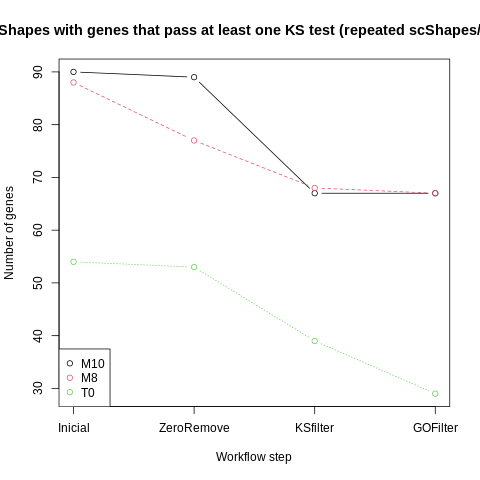

In [ ]:
%%R
OUT <- list()
FILES <- list.files(path = "../TEMP/", pattern = "SCS2")  # We save the numbers in the output

for (i in FILES){
    print(i)
    NAME <- strsplit(strsplit(i, "-")[[1]][2], "[.]")[[1]][1]
    print(NAME)
    OUT[[NAME]] <- readRDS(paste("../TEMP/", i, sep = ""))
}

NUMgenes <- data.frame(row.names = names(OUT[[1]][[3]]))  # All samples have the same format in gene tracing. Empty data frame
for (i in OUT){NUMgenes <- cbind(NUMgenes, i[[3]])}   # Join all the counts in columns. 
names(NUMgenes) <- names(OUT)

# Fix gene counts
for (i in names(GENESpass)){
    NUMgenes["KSfilter", i] <- length(GENESpass[[i]])
    NUMgenes["GOFilter", i] <- length(TABLES[[i]]$DISTR[!is.na(TABLES[[i]]$DISTR)])
}

# Plot
matplot(NUMgenes, type = c("b"), pch=1, col = 1:3, xlab = "Workflow step", ylab = "Number of genes", xaxt = "n", main = "scShapes with genes that pass at least one KS test (repeated scShapes/KST 2)")
axis(side = 1, at = 1:4, labels = rownames(NUMgenes))
legend("bottomleft", legend = names(OUT), col=1:3, pch=1) 

[1] "NB"   "ZINB" "NA"   "ZIP" 
   Sample Distribution Amount
1      T0          ZIP      2
2      T0         ZINB     28
3      T0           NB     10
4      T0           NA     49
5     M15          ZIP      3
6     M15         ZINB     36
7     M15           NB     26
8     M15           NA     24
9     M12          ZIP      1
10    M12         ZINB     45
11    M12           NB     12
12    M12           NA     31
13    M11         ZINB     26
14    M11           NB     21
15    M11           NA     42
16    M10          ZIP      1
17    M10         ZINB     33
18    M10           NB     30
19    M10           NA     25
20    M09         ZINB     24
21    M09           NB     32
22    M09           NA     33
23    M07         ZINB     26
24    M07           NB     10
25    M07           NA     53
26    M05          ZIP      2
27    M05         ZINB     35
28    M05           NB     31
29    M05           NA     21
30    M02          ZIP      2
31    M02         ZINB     13
32    M0

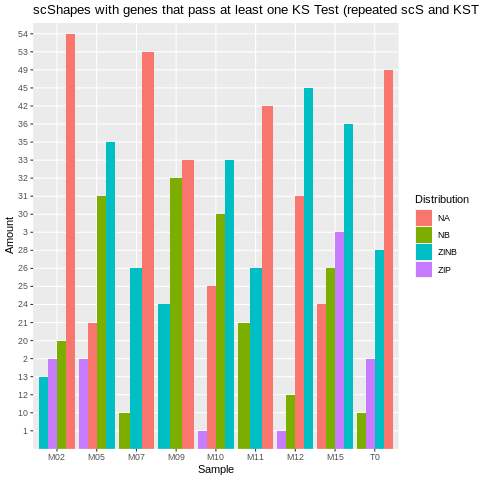

In [ ]:
%%R
# Frequency histogram for final KS-Test
# Which are the defined distributions?
DISTR <- c()
for (i in TABLES){
    #DISTR <- unique(c(DISTR, i$DISTR[!is.na(i$DISTR)]))
    VEC <- i$DISTR
    VEC[is.na(VEC)] <- "NA"
    DISTR <- unique(c(DISTR, VEC))
}
print(DISTR)

# Long format for ggplot
# Initialize
PLOT <- data.frame(matrix(ncol = 3, nrow = 0))
colnames(PLOT) <- c("Sample", "Distribution", "Amount")
for (i in names(TABLES)){
    VEC <- TABLES[[i]]$DISTR
    VEC[is.na(VEC)] <- "NA"
    AMOUNT <- table(VEC)  # Distribution - frequency relation
    for (j in names(AMOUNT)){
        PLOT <- rbind(c(i, j, AMOUNT[j]), PLOT)   # Sample, Distribution, Amount
    }
    
}
colnames(PLOT) <- c("Sample", "Distribution", "Amount")
print(PLOT)

ggplot(PLOT, aes(fill=Distribution, y=Amount, x=Sample)) + 
    geom_bar(position="dodge", stat="identity") + ggtitle("scShapes with genes that pass at least one KS Test (repeated scS and KST 2)")

## Bimodal index estimation

We are interested to know if each gene of interest shows a bimodal behaviour.

We use the bimodality library and save the bimodality index.


### Calculation

In [ ]:
%%R
# Bimodal index estimation
COUNTSint <- list()
for (SAMPLE in names(COUNTS)){
    print(SAMPLE)
    for (LISTS in names(ALLgenes)){
        COUNTSint[[SAMPLE]] <- COUNTS[[SAMPLE]][rownames(COUNTS[[SAMPLE]]) %in% unlist(ALLgenes[[LISTS]]),]  # Which genes are in at least one sample?
        COUNTSint[[SAMPLE]] <- filter_counts(COUNTSint[[SAMPLE]], perc.zero = 0.10)   # Remove genes not expressed in more than 10% of cells
        BI <- bimodalIndex(COUNTSint[[SAMPLE]])  # Bimodal index estimation
        
        saveRDS(BI, paste(TEMPdir, "Bimodality-", LISTS, "-", SAMPLE, "-", OLDnew, ".Rds", sep = ""))
    }
}

[1] "T0"
[1]   44 4423
[1]   44 4423
1 
[1]   51 4423
[1]   51 4423
1 
[1]   34 4423
[1]   34 4423
1 
[1]   32 4423
[1]   32 4423
1 
[1]   32 4423
[1]   32 4423
1 
[1]   41 4423
[1]   35 4423
1 
[1]   20 4423
[1]   18 4423
1 
[1]   36 4423
[1]   36 4423
1 
[1]   40 4423
[1]   40 4423
1 
[1]   35 4423
[1]   35 4423
1 
[1]   18 4423
[1]   18 4423
1 
[1]   19 4423
[1]   19 4423
1 
[1]   28 4423
[1]   25 4423
1 
[1]   18 4423
[1]   14 4423
1 
[1]   10 4423
[1]    8 4423
1 
[1]   13 4423
[1]    7 4423
1 
[1]    4 4423
[1]    3 4423
1 
[1]   30 4423
[1]   25 4423
1 
[1]   26 4423
[1]   20 4423
1 
[1]   24 4423
[1]   16 4423
1 
[1]   36 4423
[1]   36 4423
1 
[1] "M15"
[1]   44 1910
[1]   44 1910
1 
[1]   51 1910
[1]   51 1910
1 
[1]   34 1910
[1]   34 1910
1 
[1]   32 1910
[1]   30 1910
1 
[1]   32 1910
[1]   32 1910
1 
[1]   41 1910
[1]   40 1910
1 
[1]   20 1910
[1]   19 1910
1 
[1]   36 1910
[1]   36 1910
1 
[1]   40 1910
[1]   40 1910
1 
[1]   35 1910
[1]   35 1910
1 
[1]   18 1910
[1]   

### Analysis

[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M02-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M05-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M07-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M09-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M10-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M11-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M12-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M15-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-T0-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p2-M02-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p2-M05-NEW.Rds"
[1] "/content/drive/MyDrive/MELBOURNEbimodal

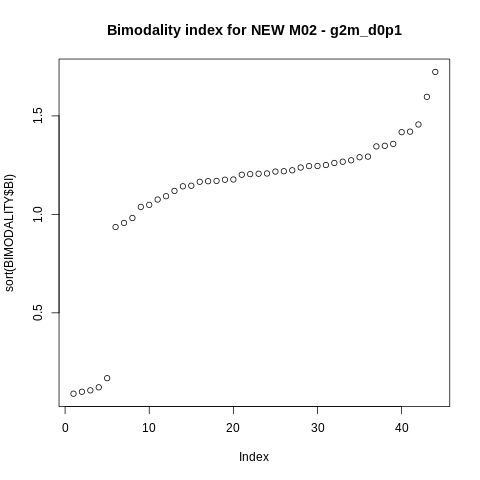

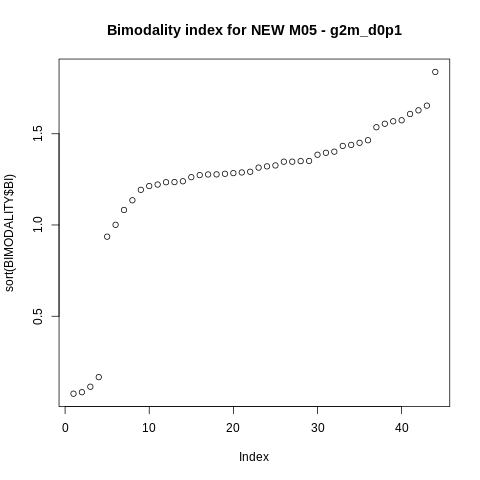

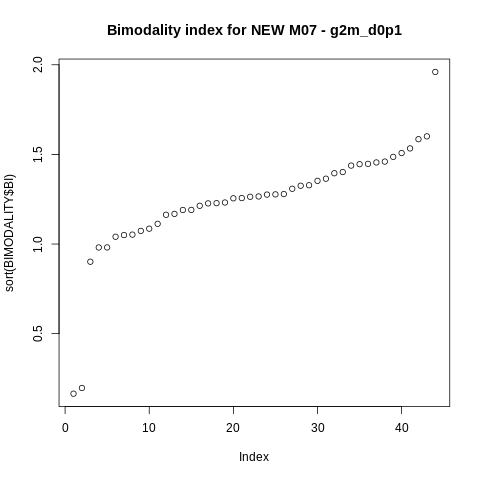

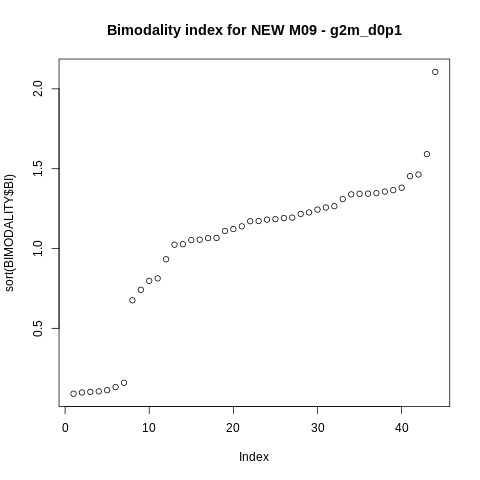

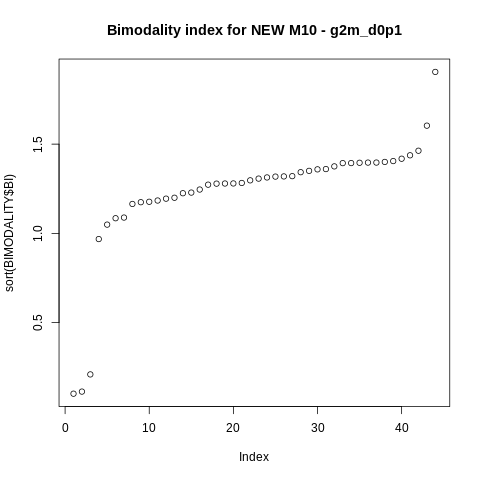

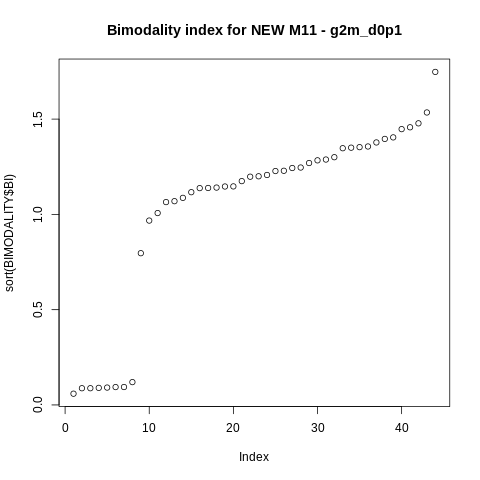

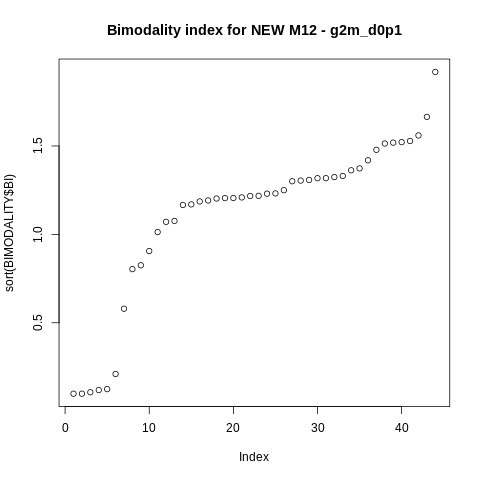

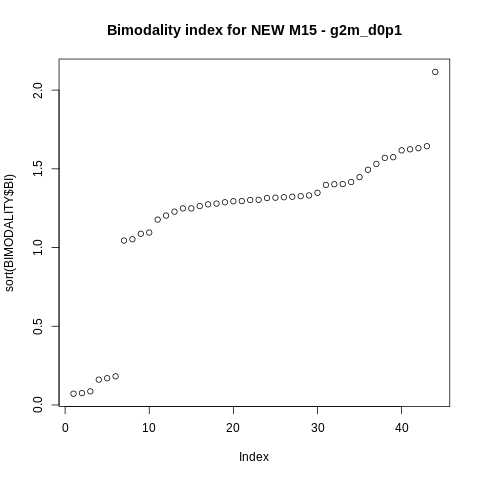

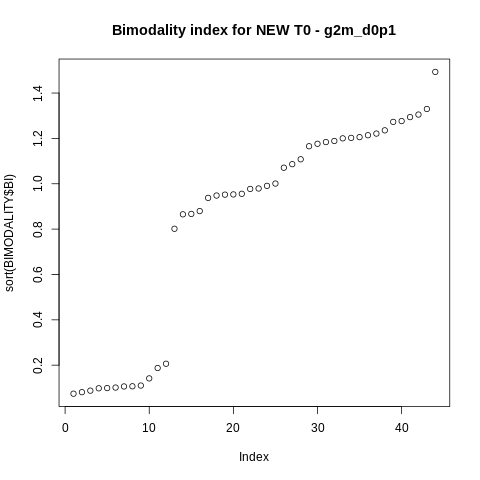

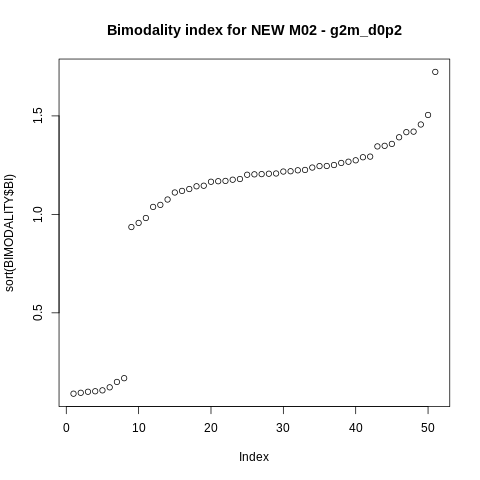

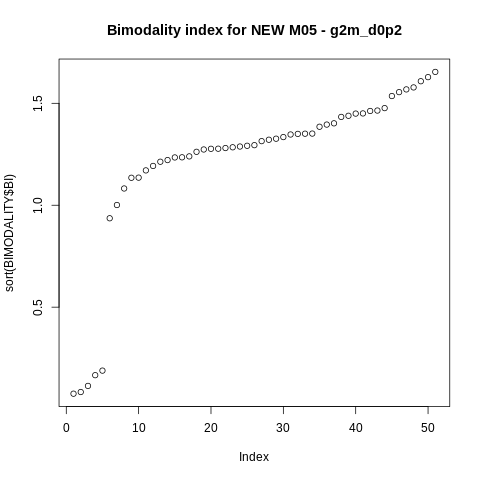

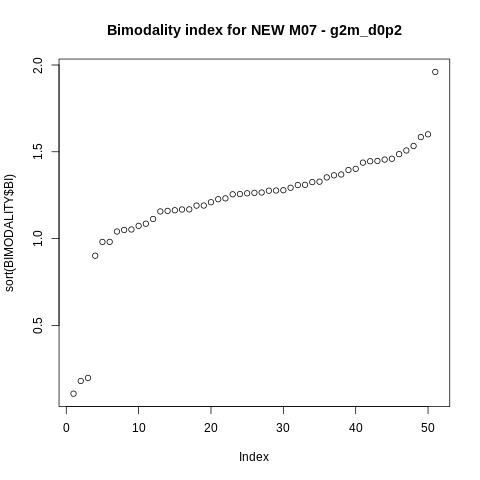

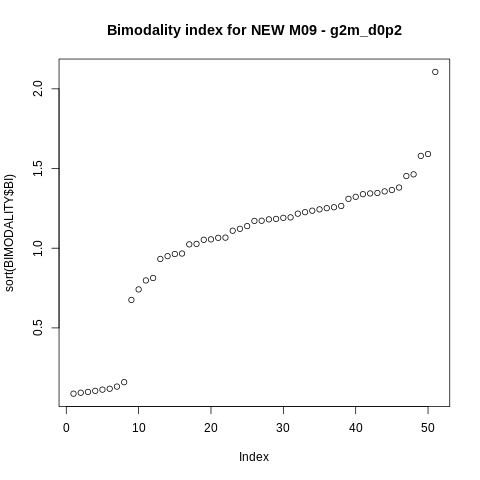

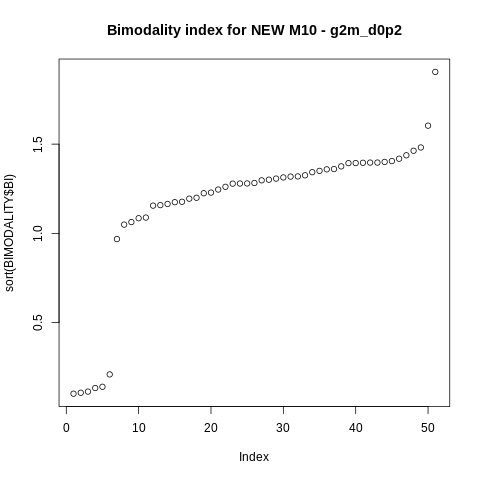

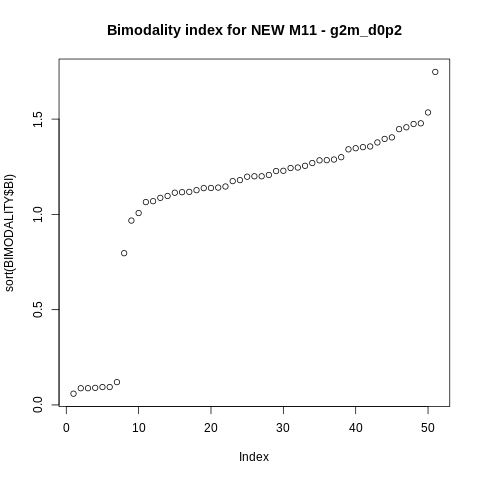

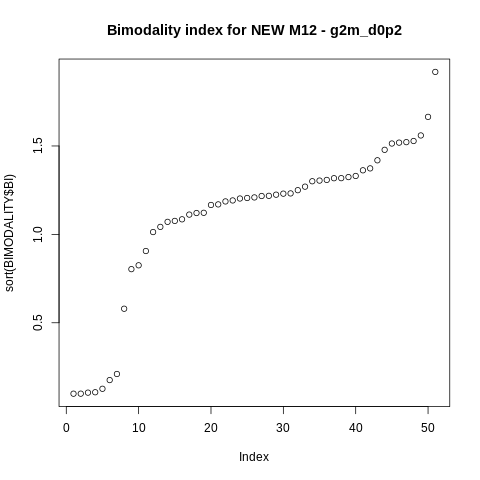

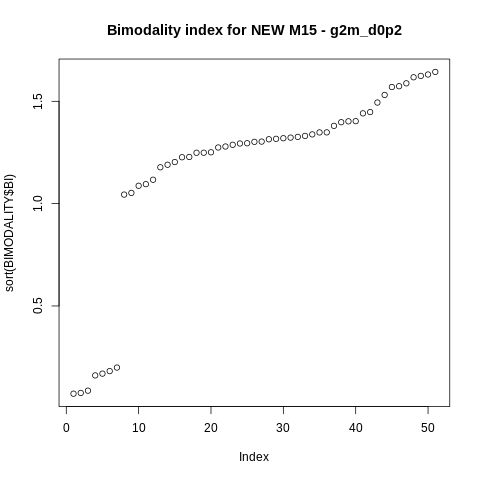

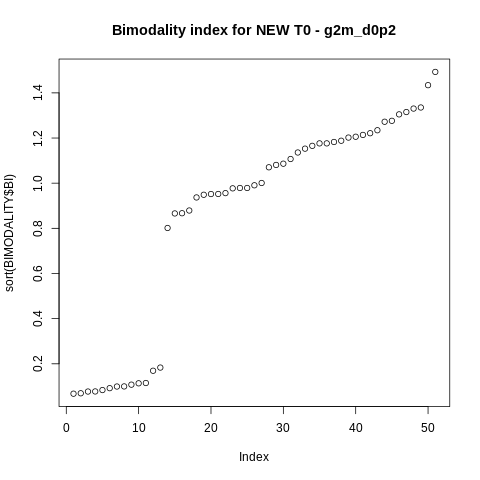

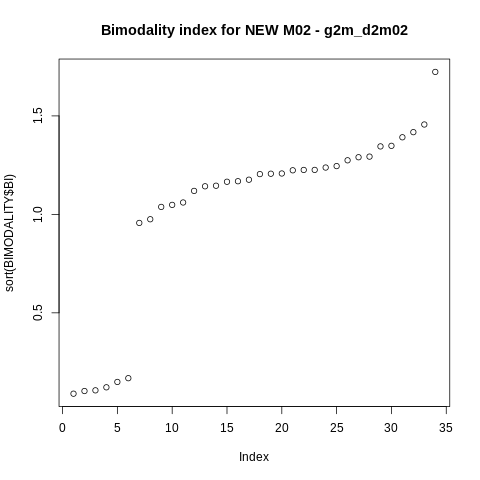

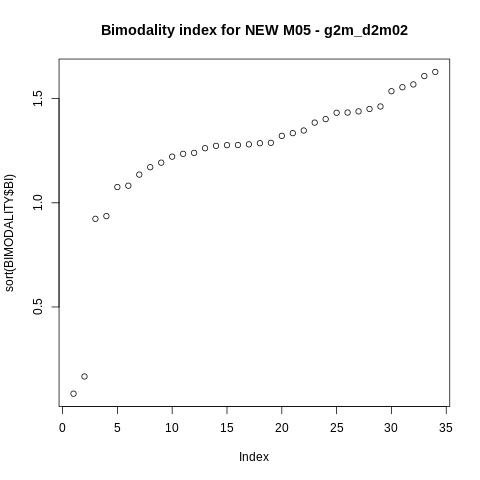

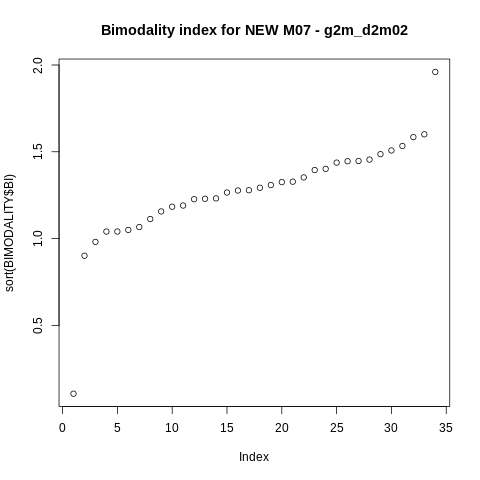

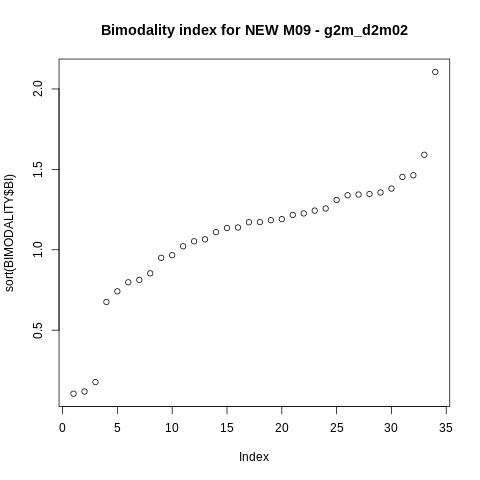

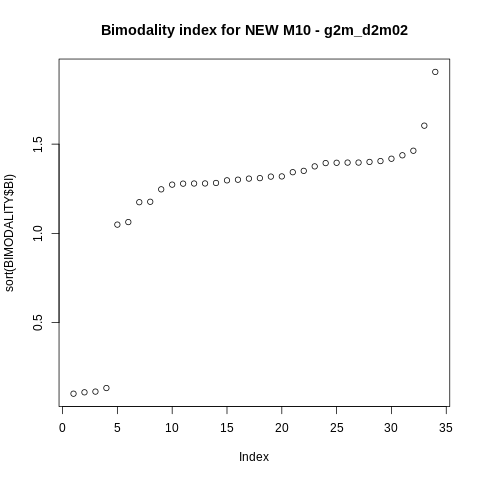

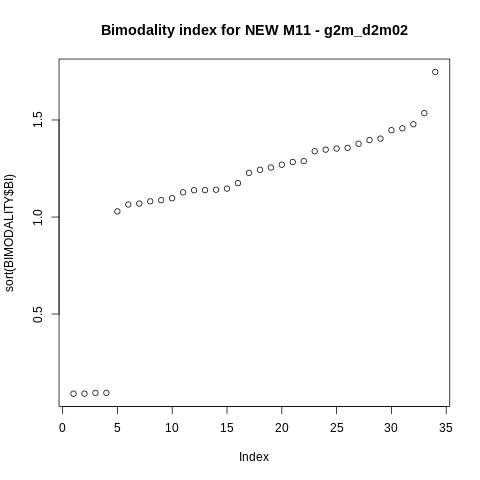

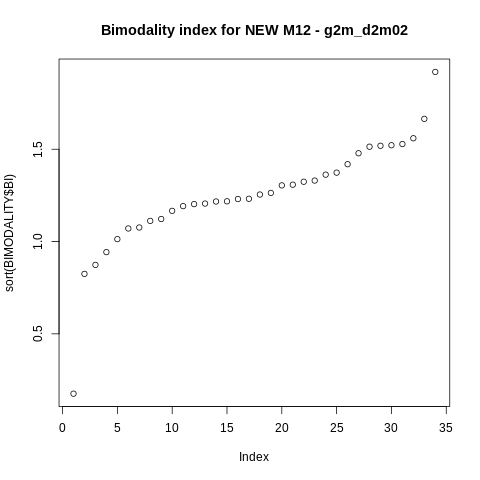

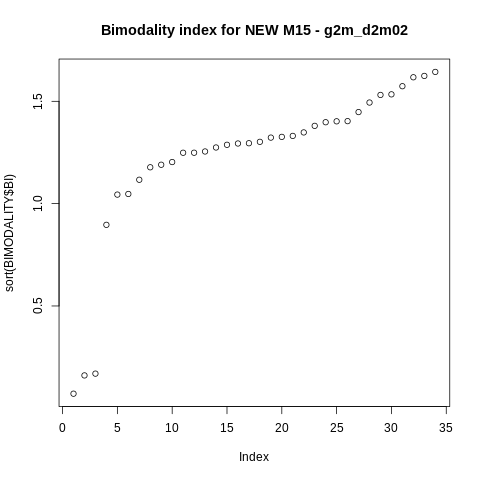

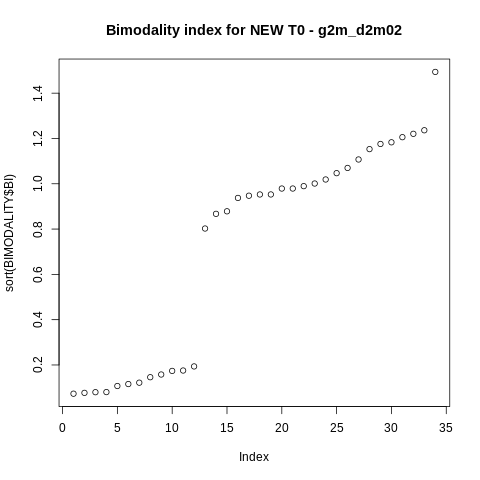

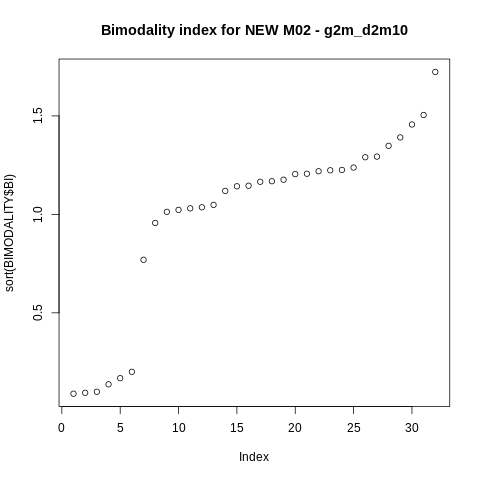

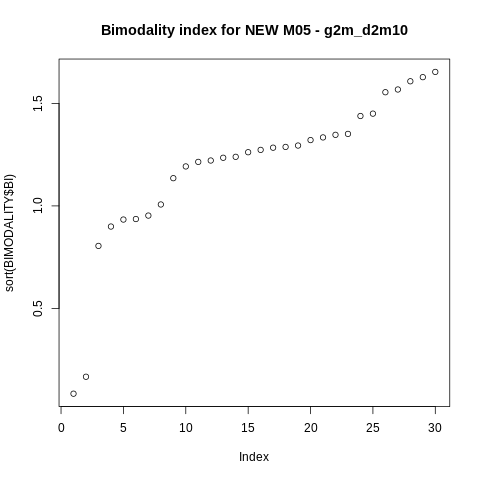

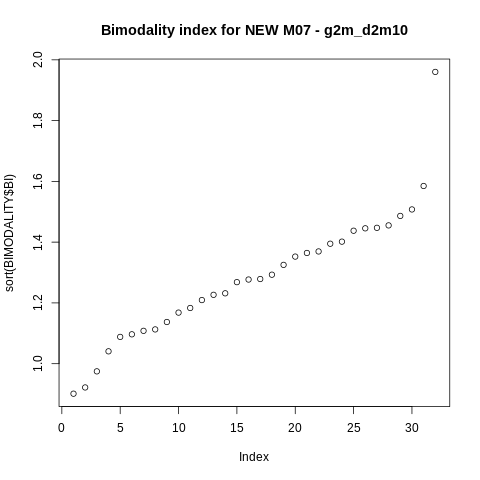

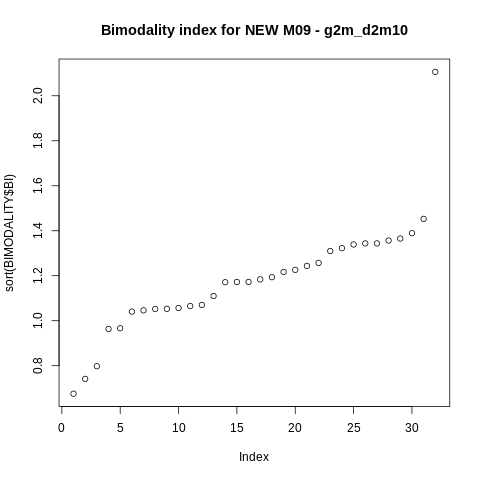

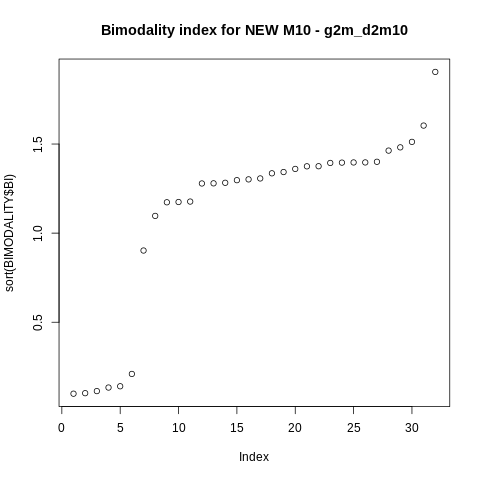

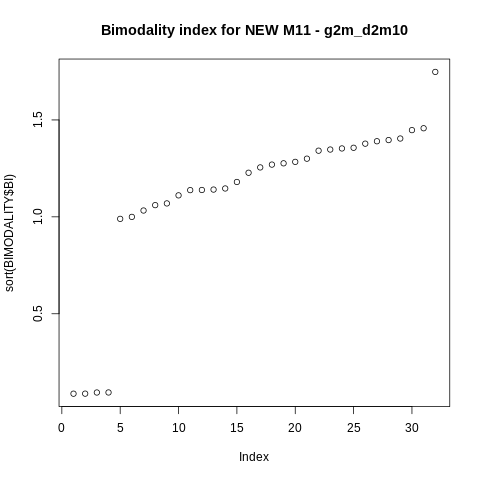

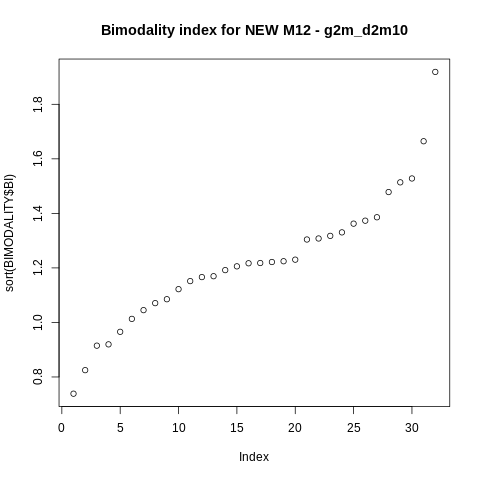

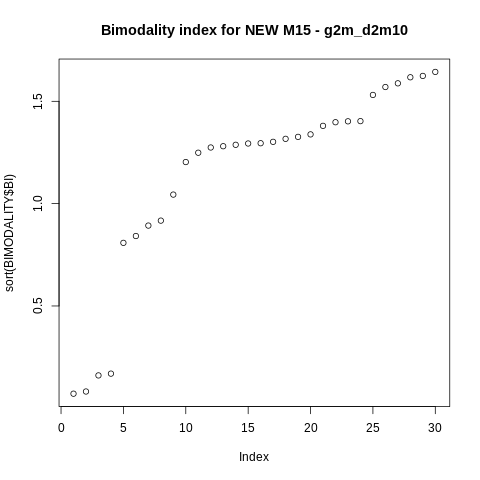

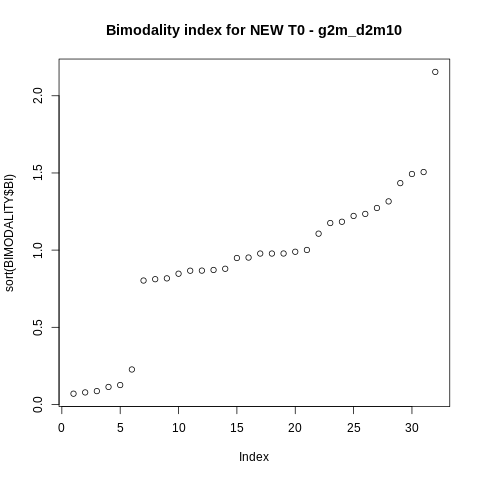

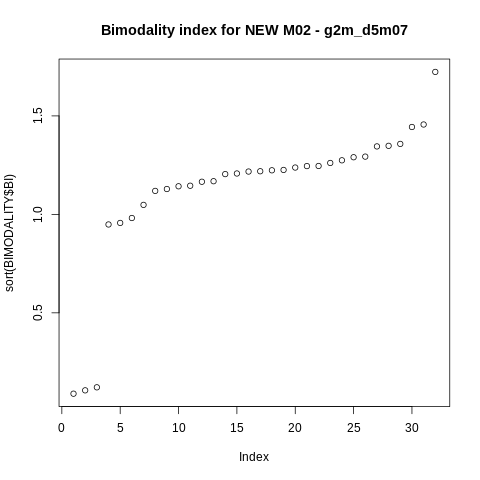

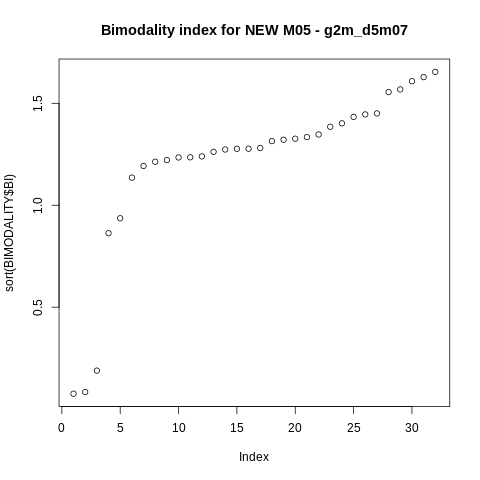

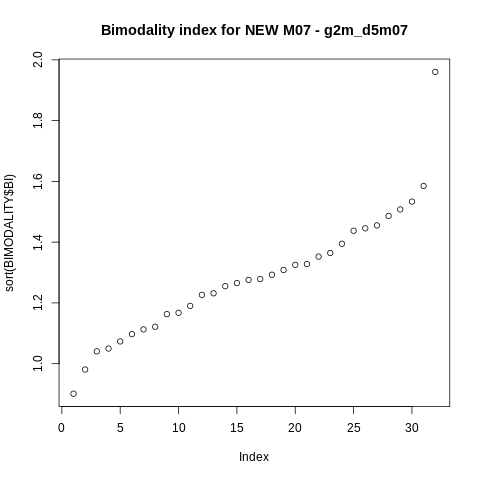

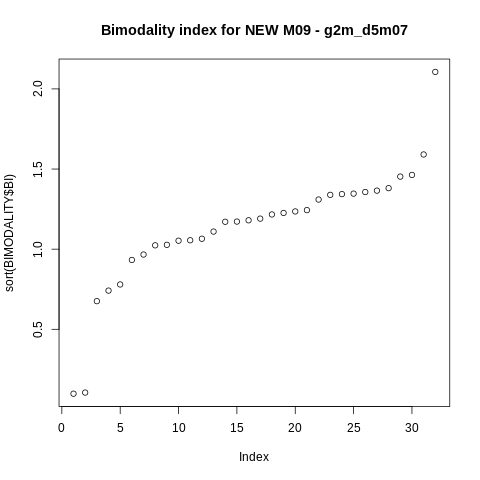

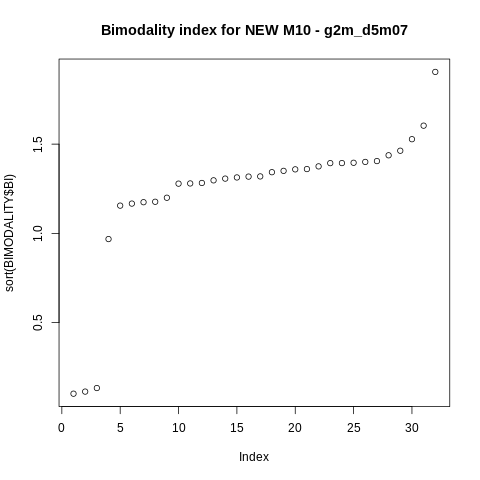

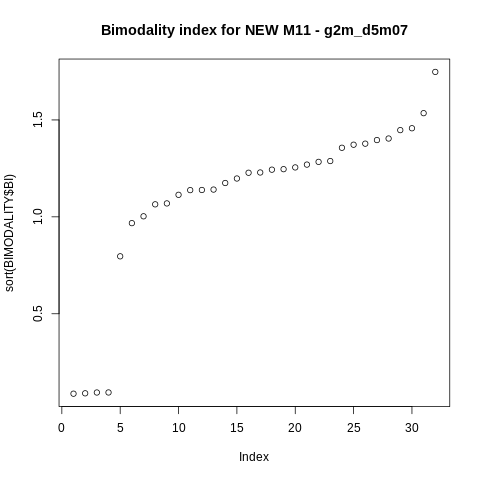

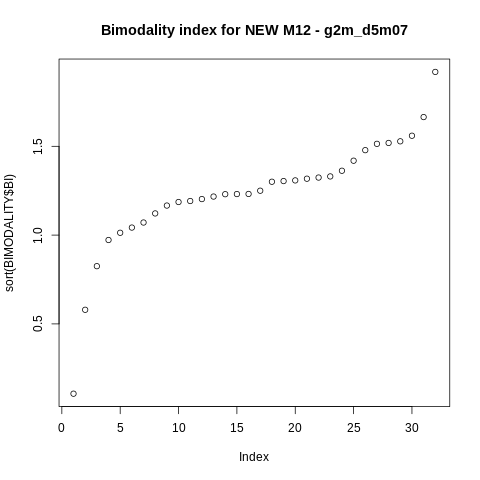

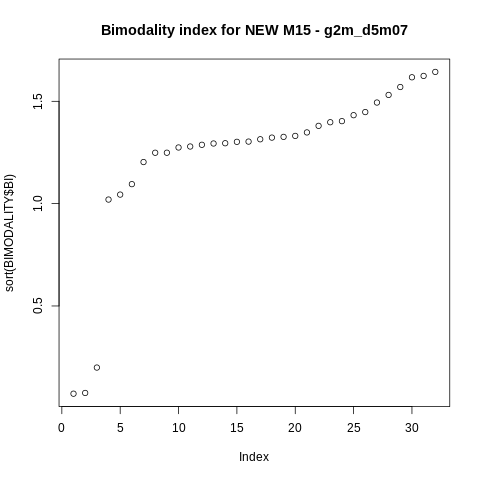

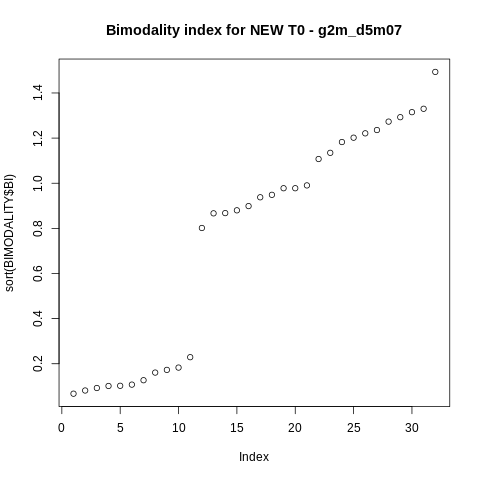

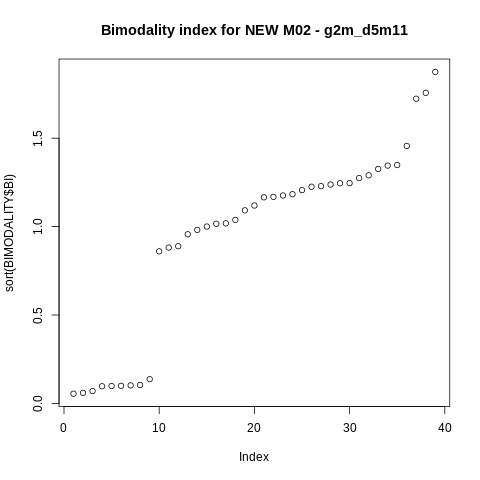

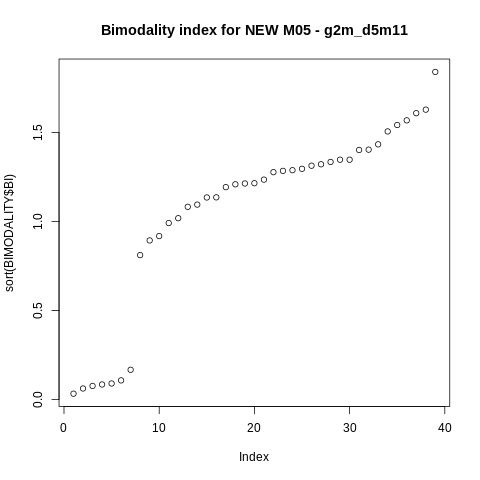

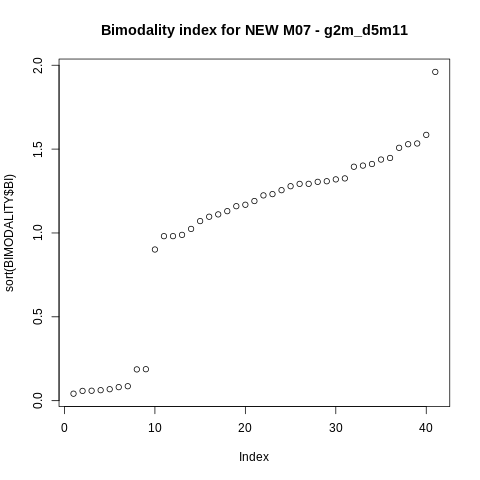

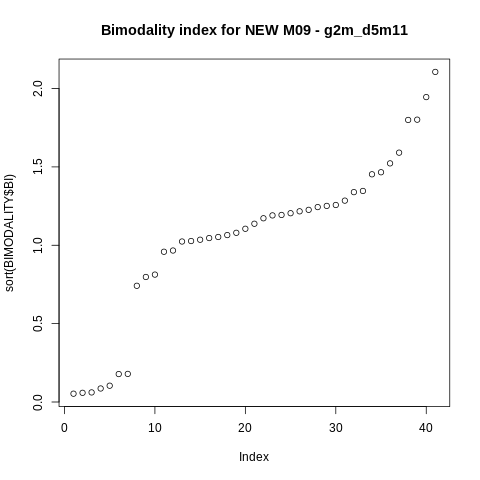

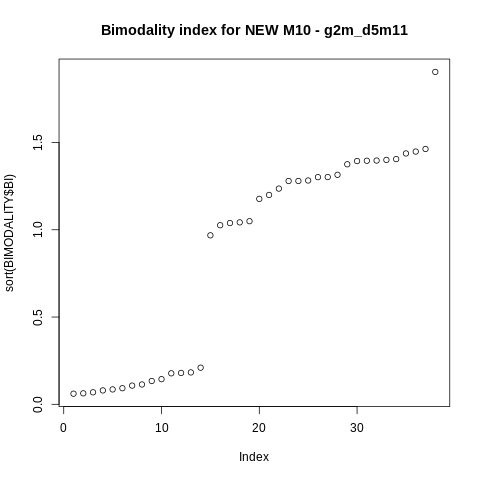

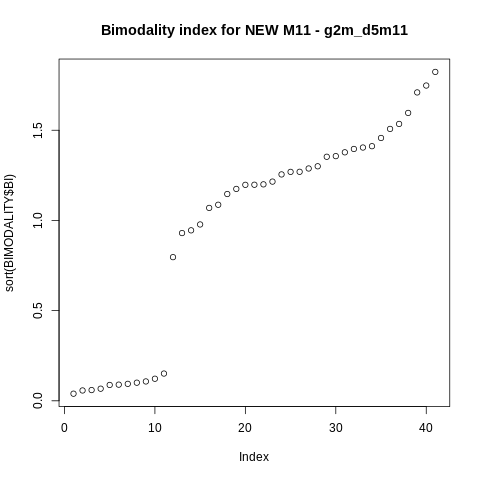

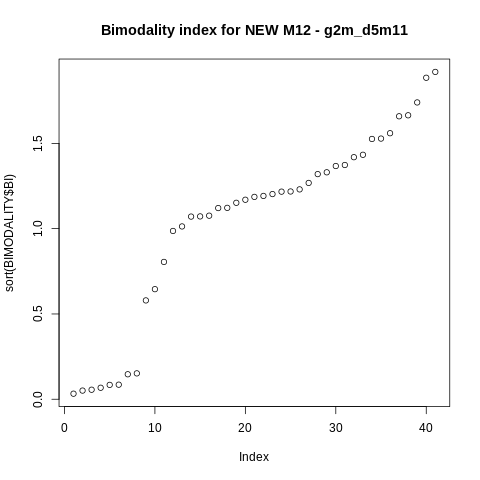

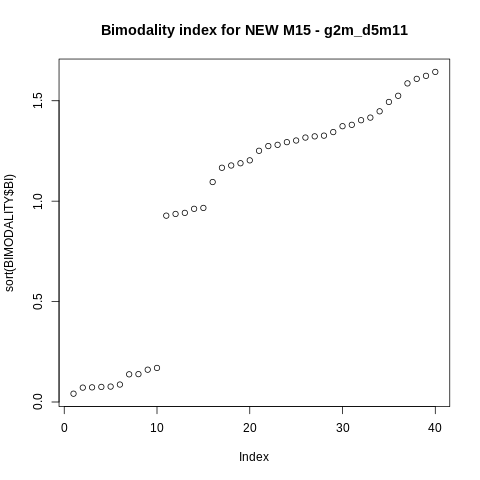

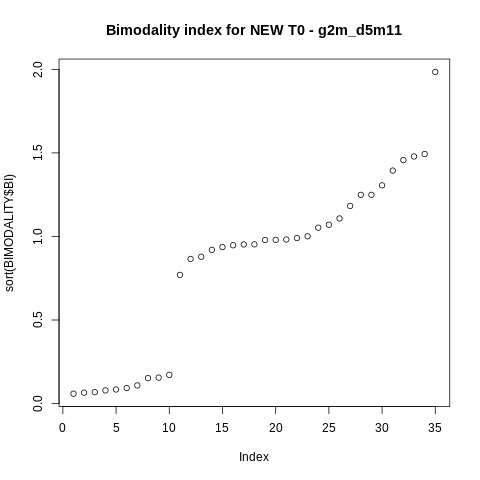

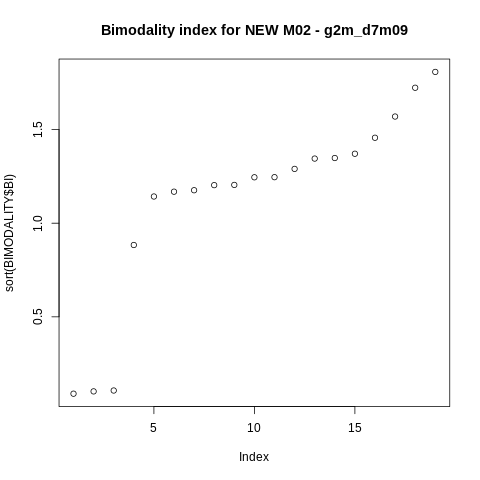

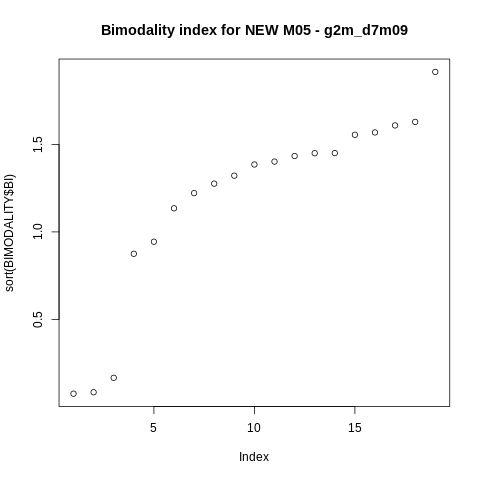

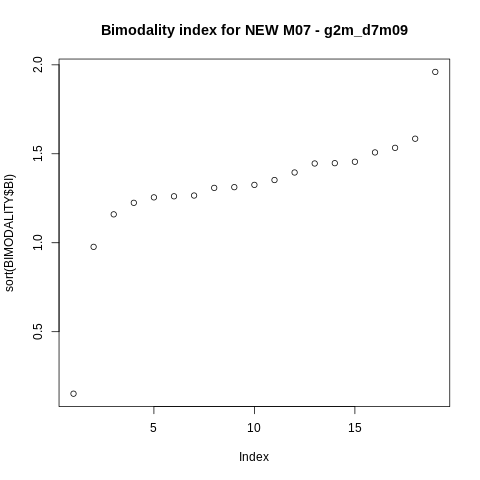

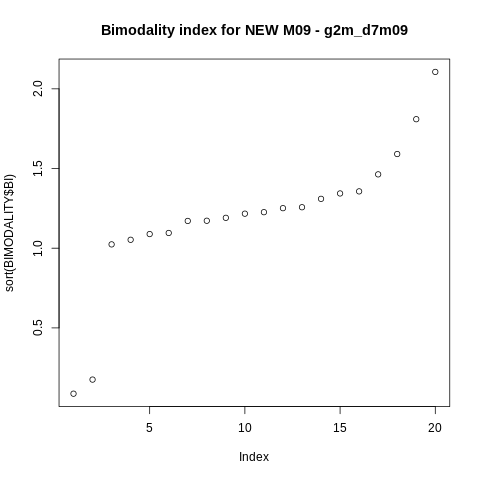

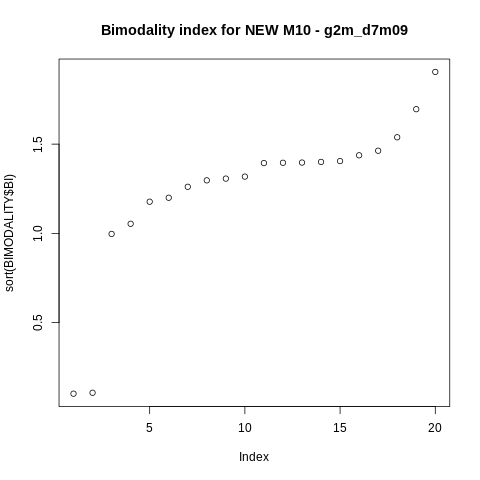

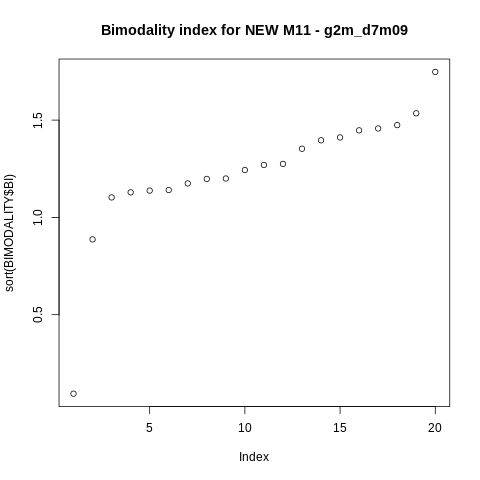

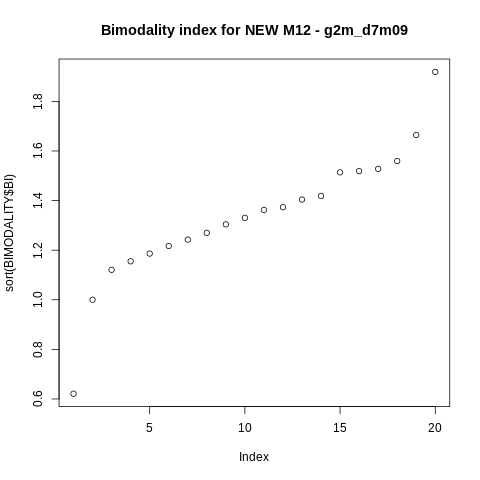

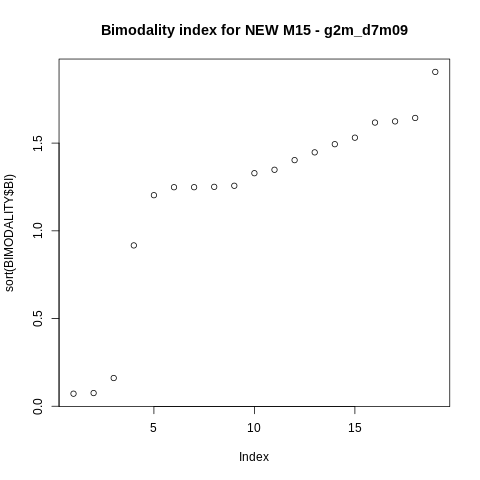

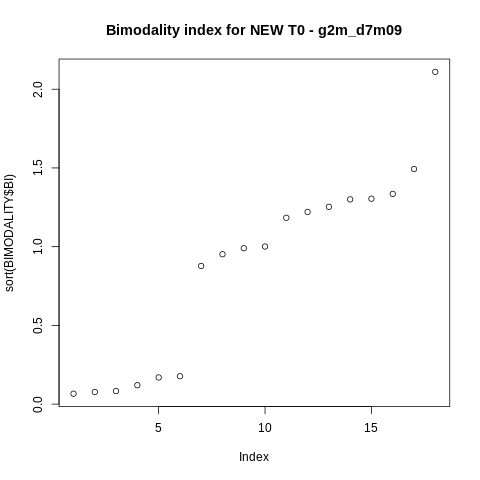

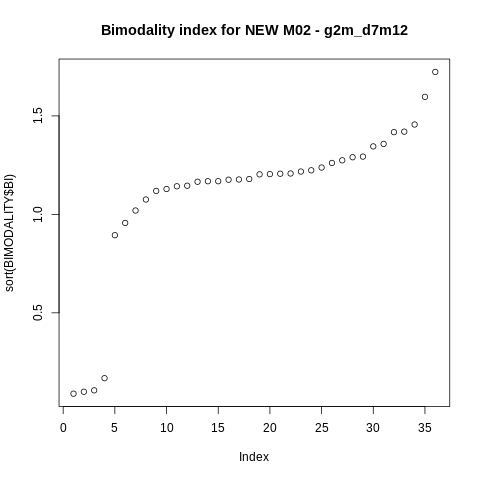

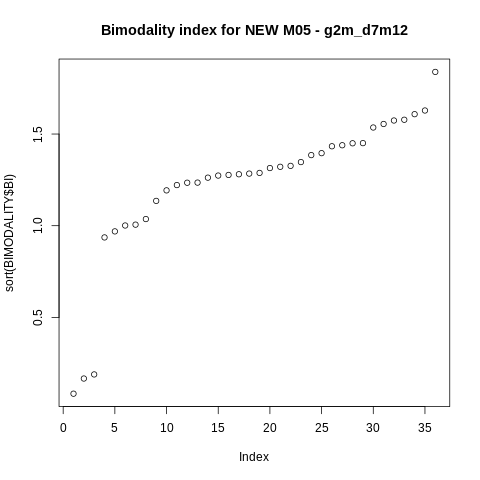

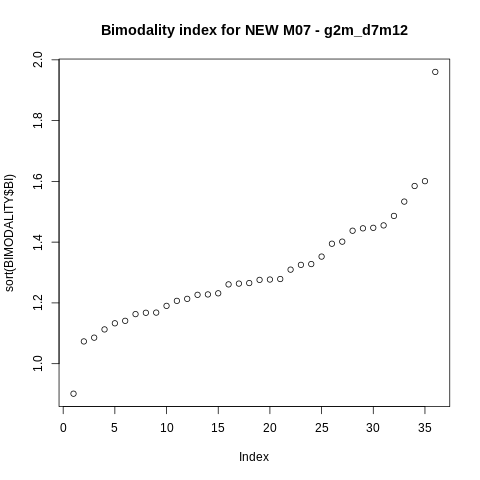

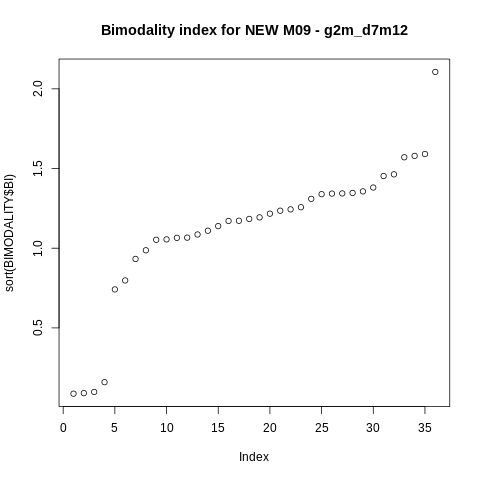

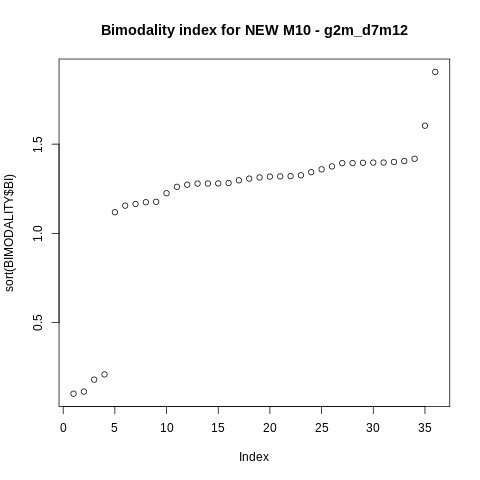

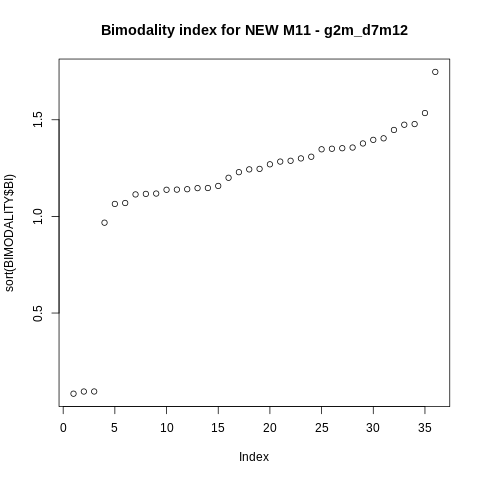

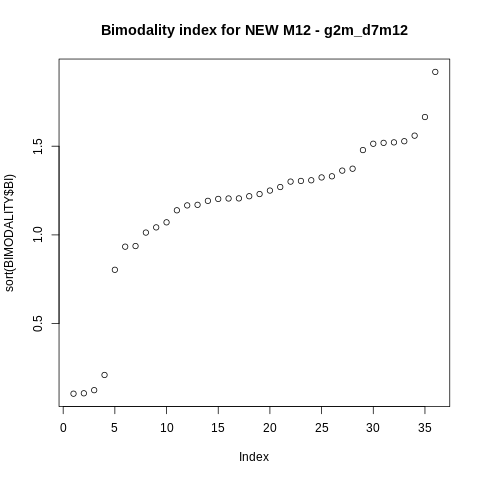

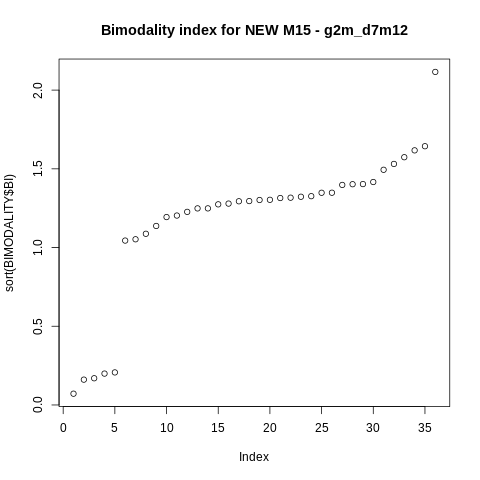

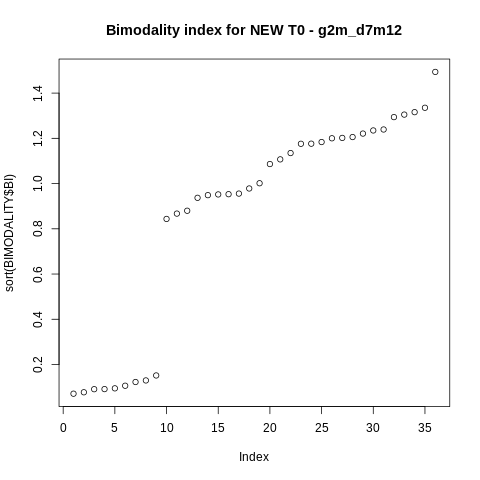

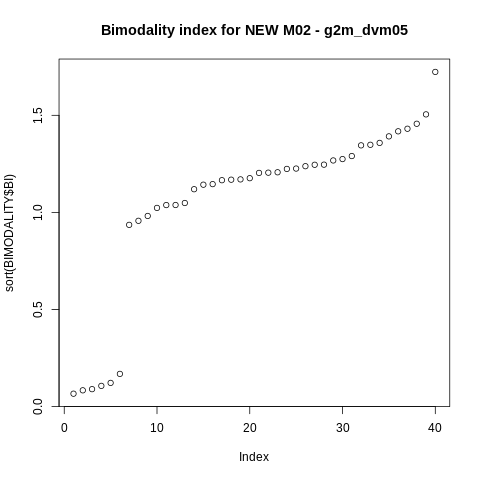

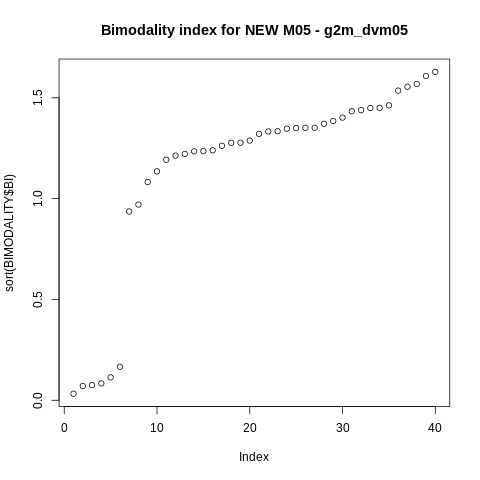

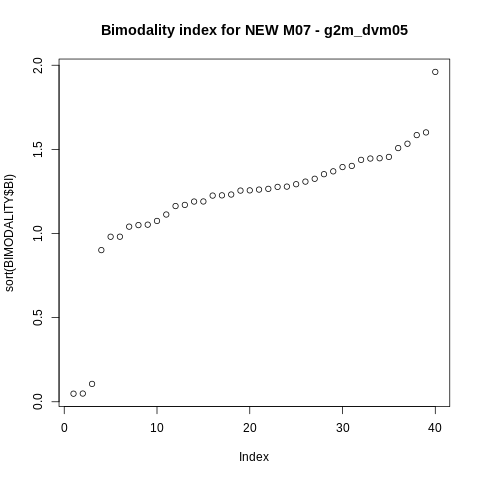

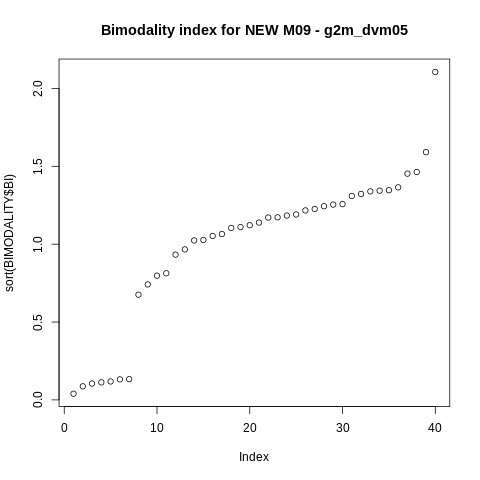

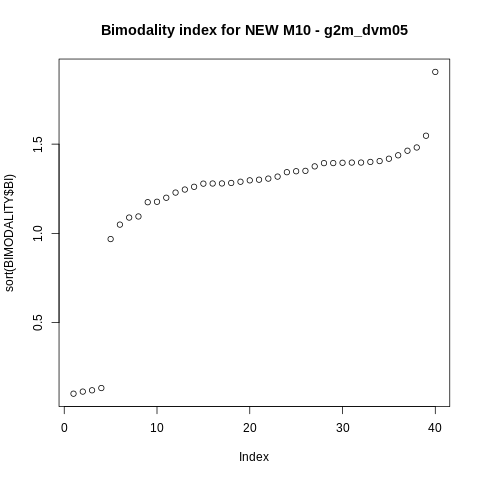

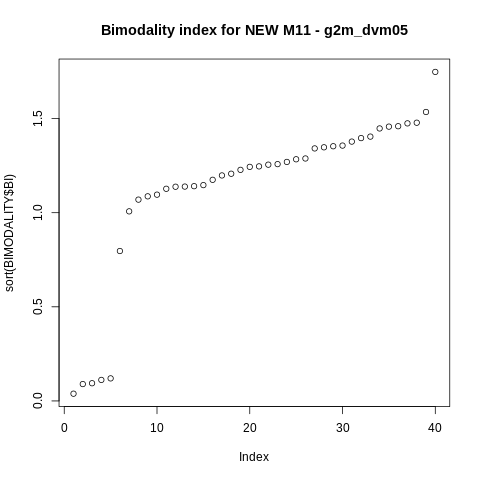

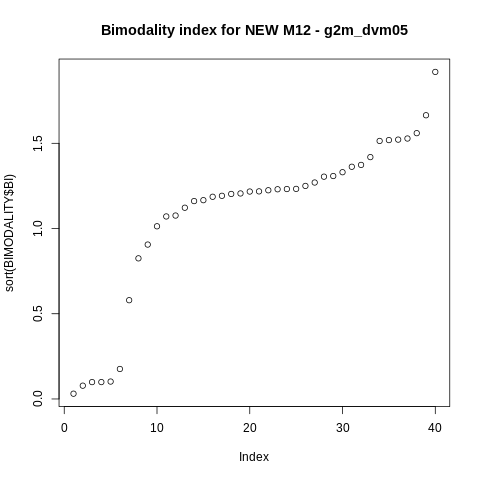

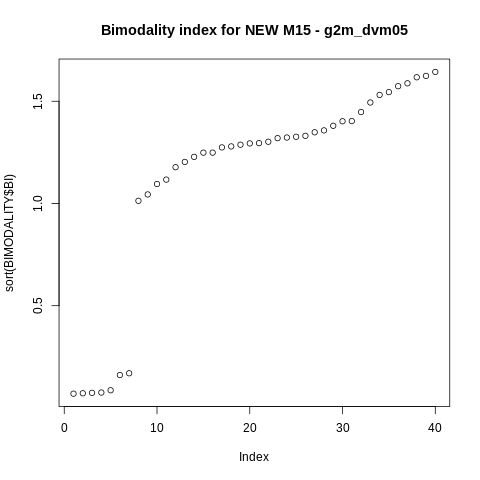

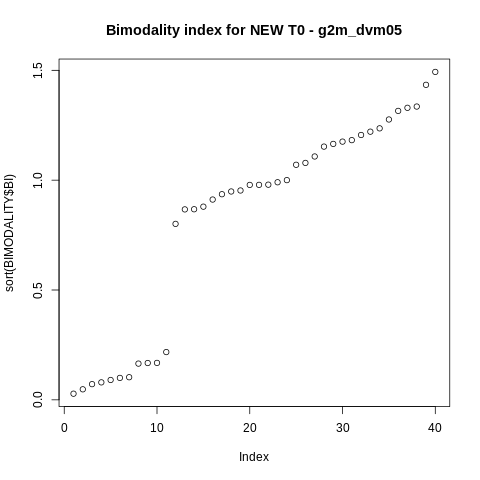

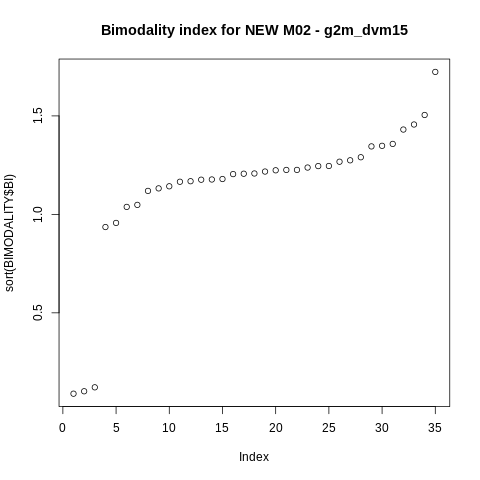

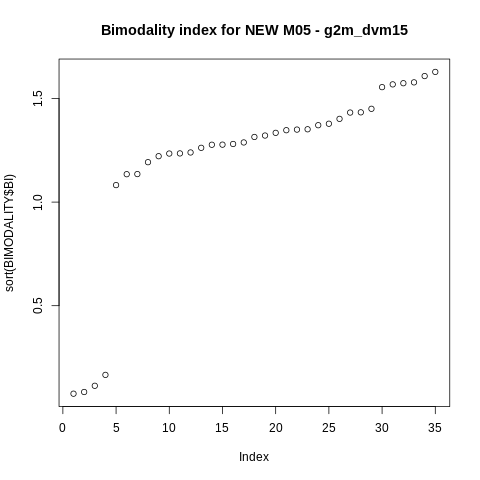

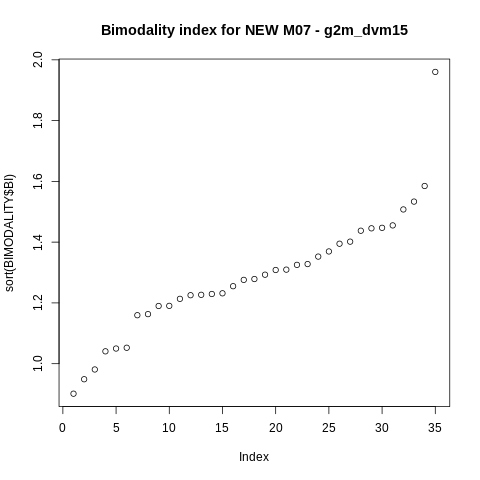

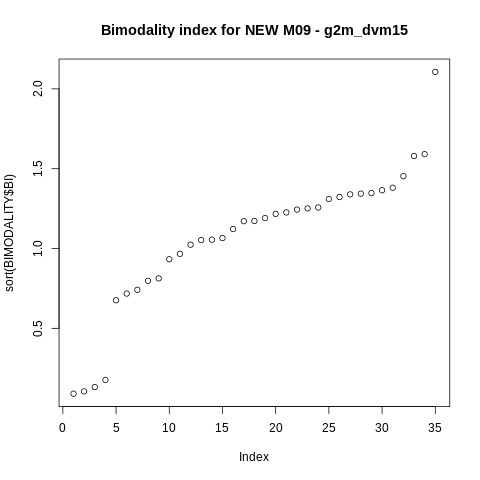

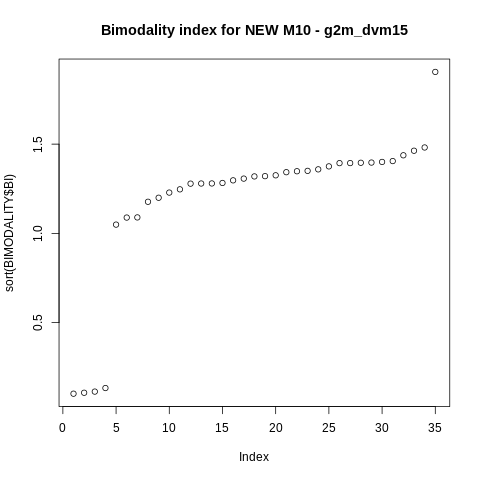

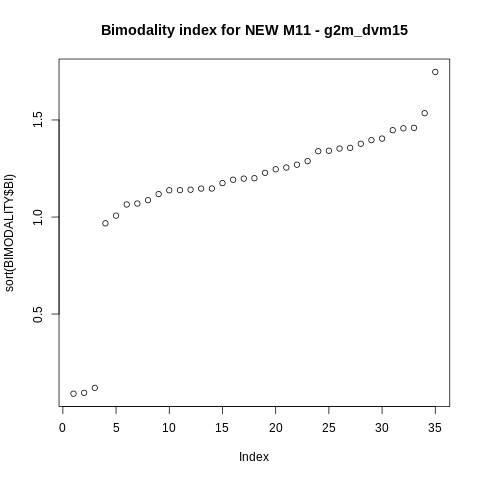

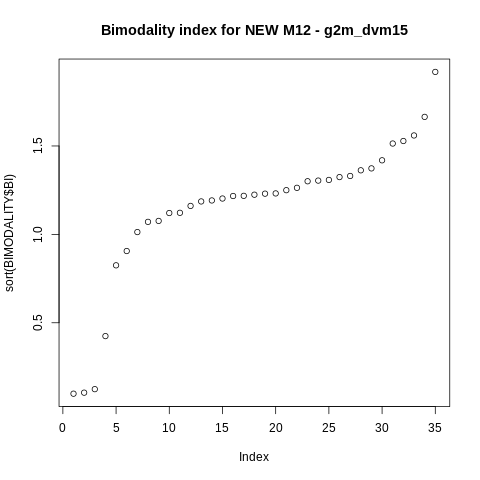

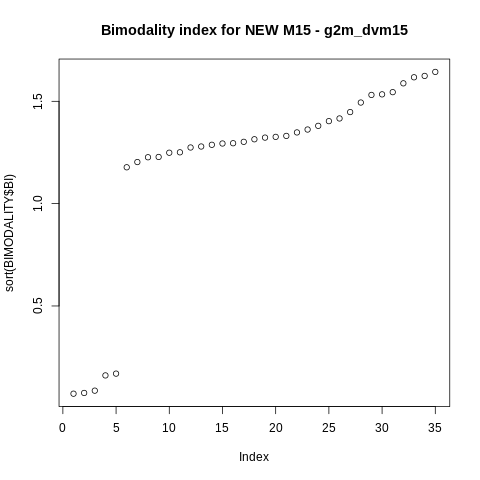

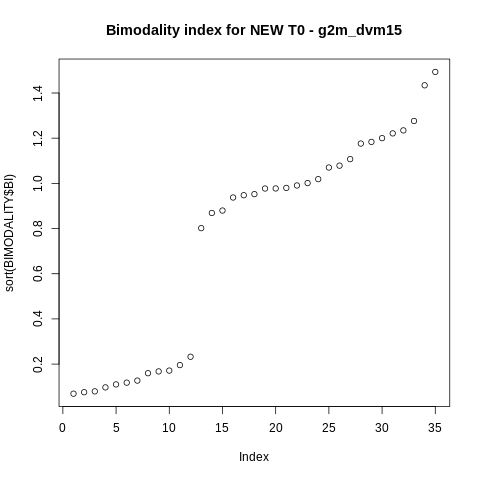

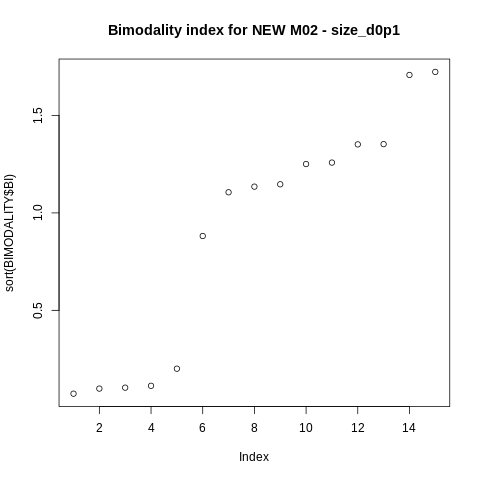

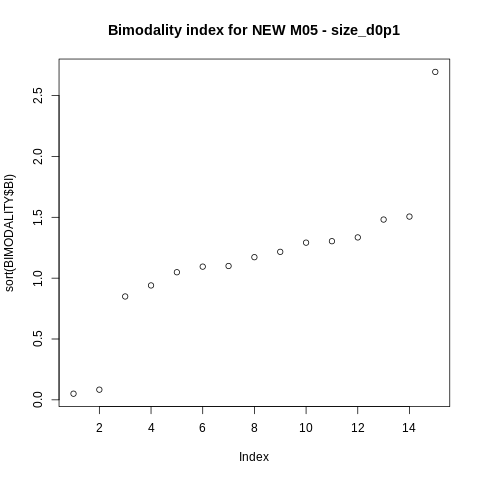

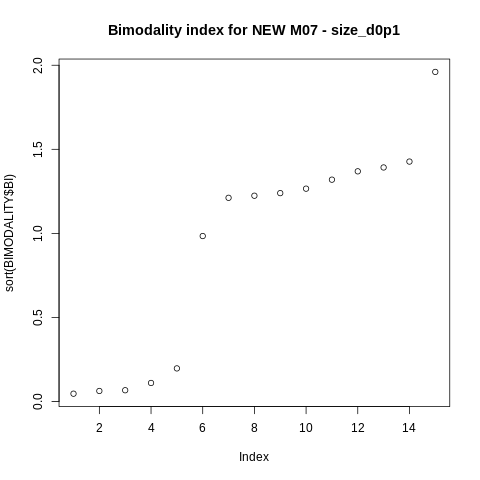

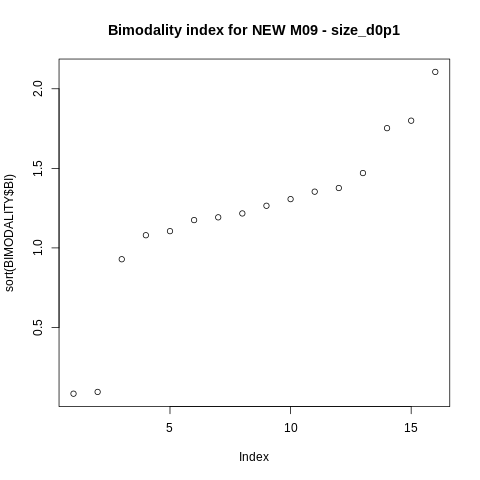

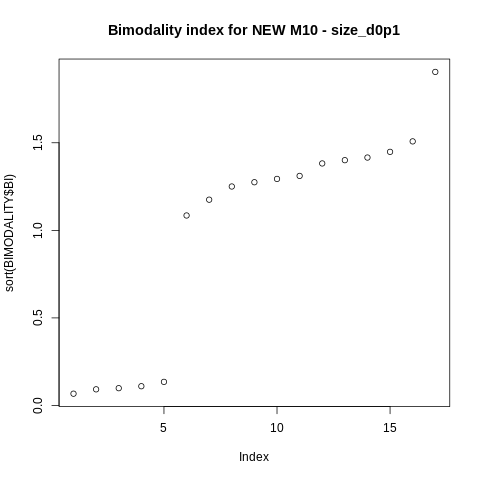

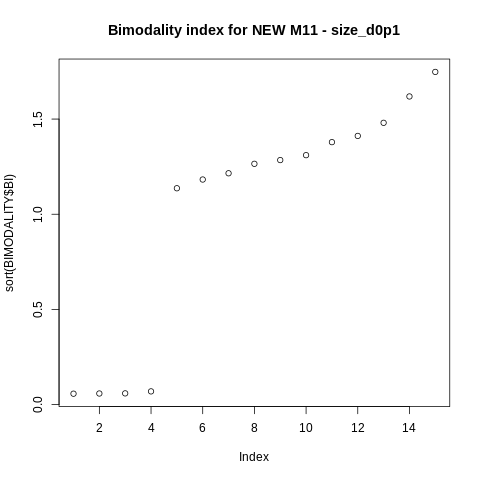

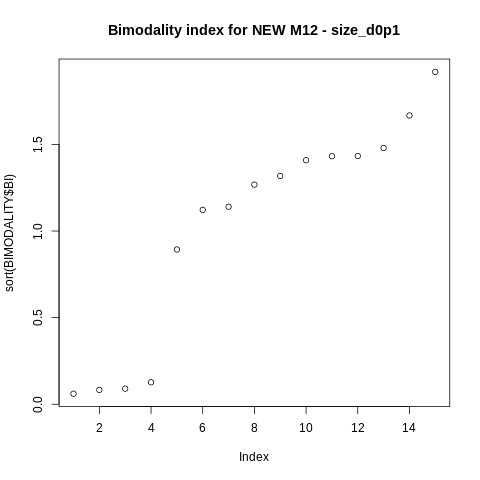

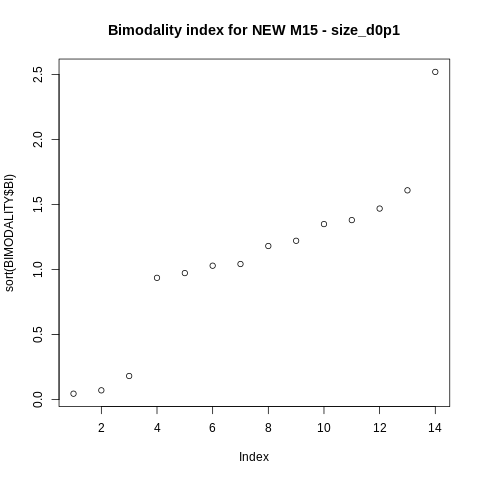

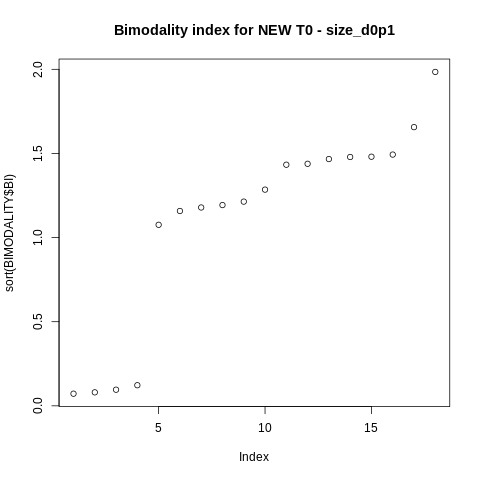

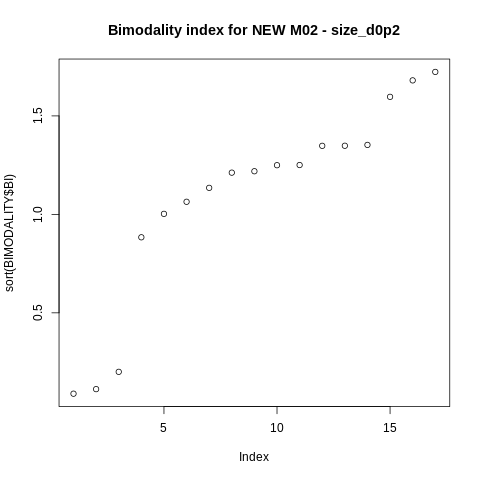

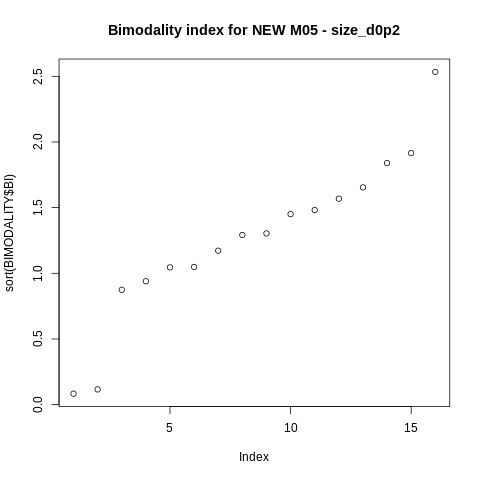

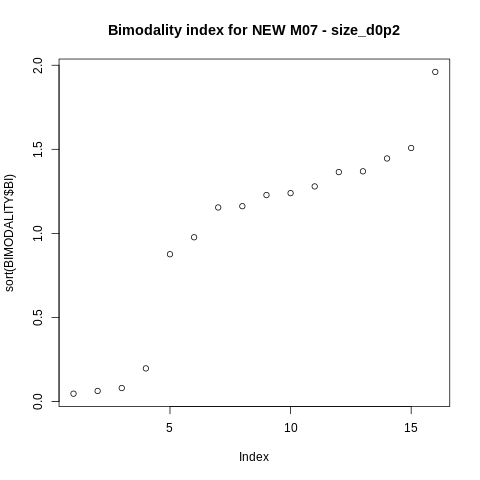

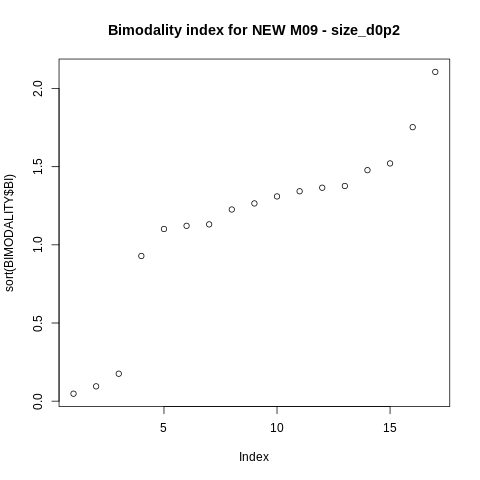

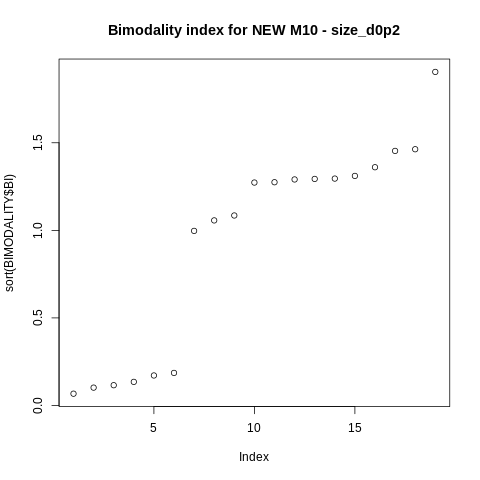

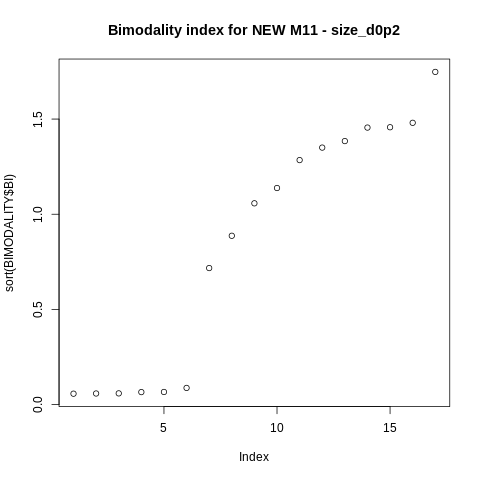

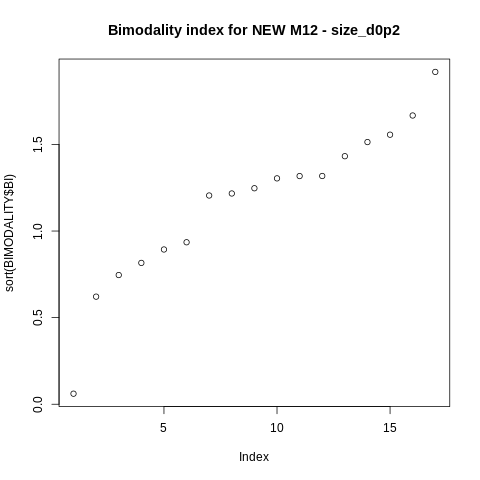

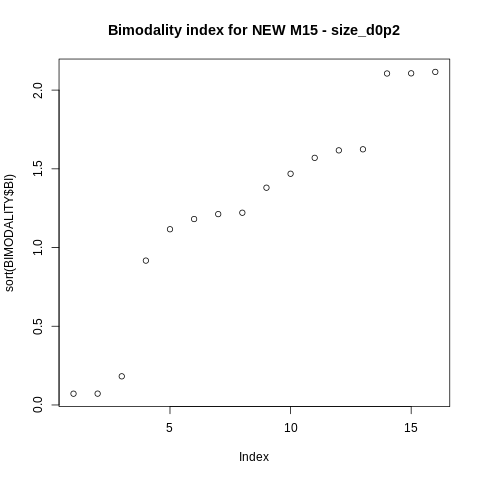

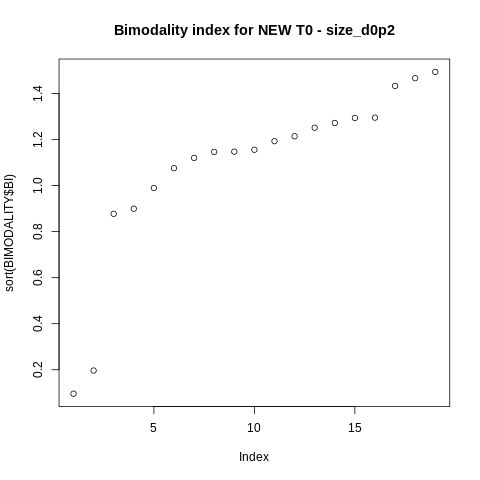

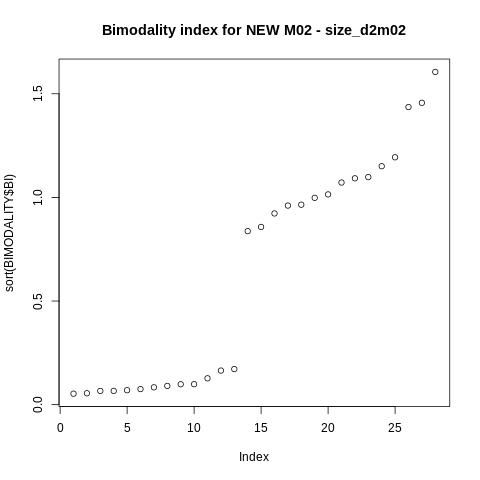

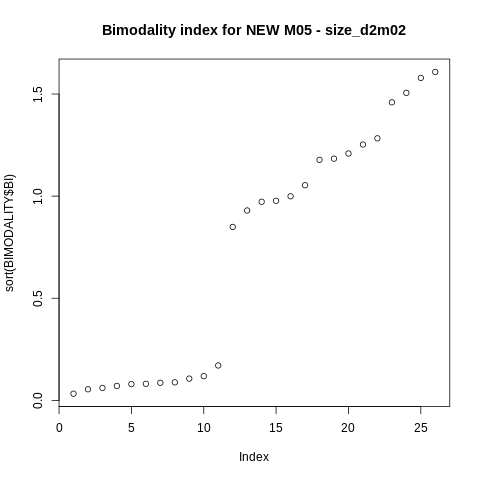

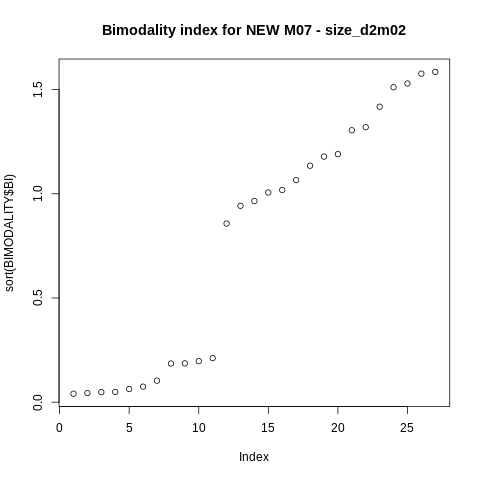

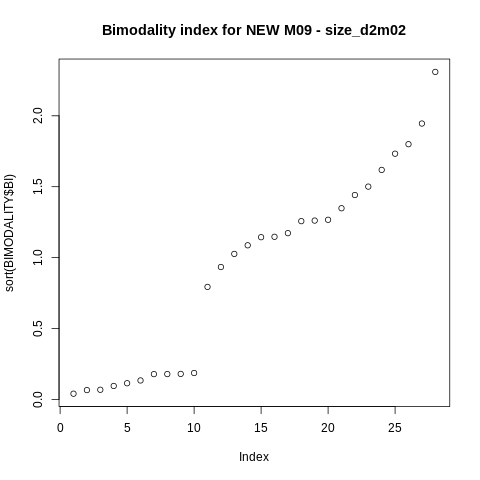

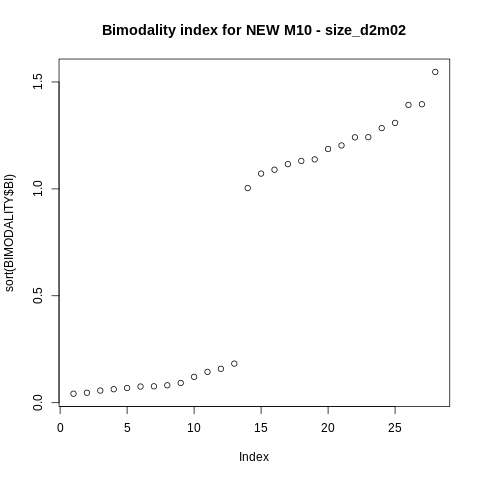

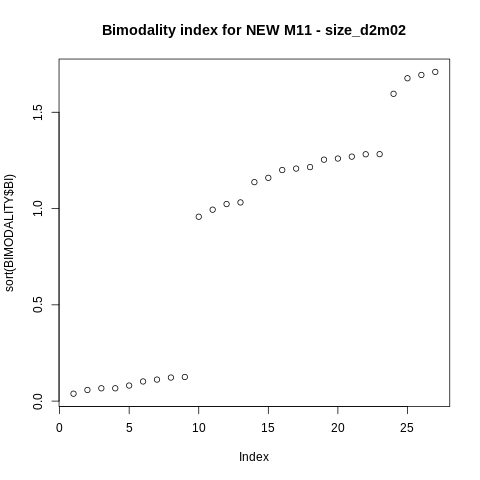

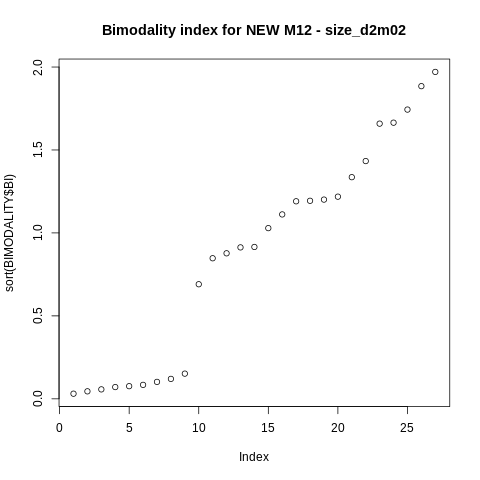

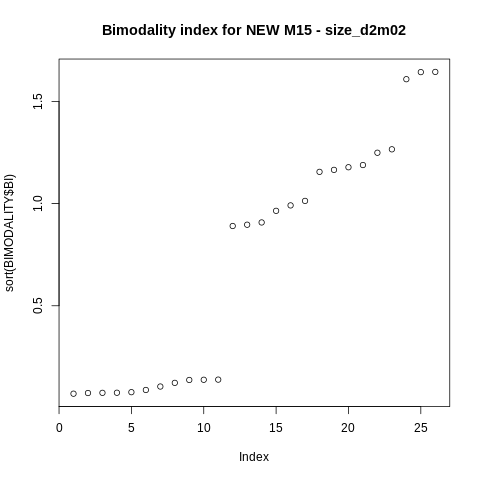

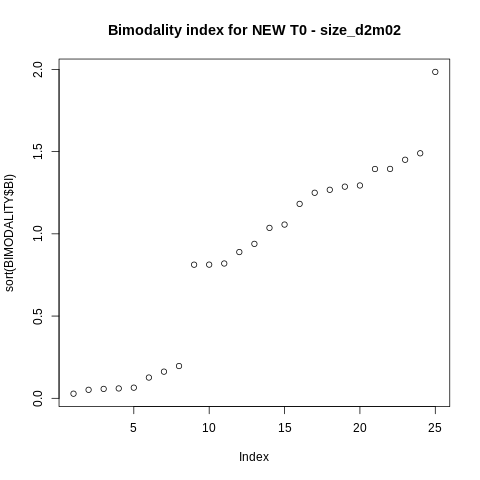

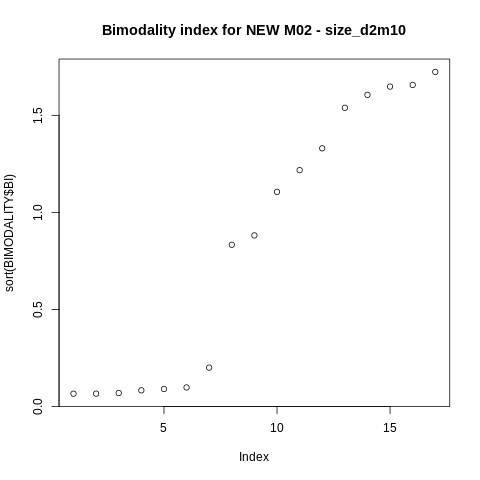

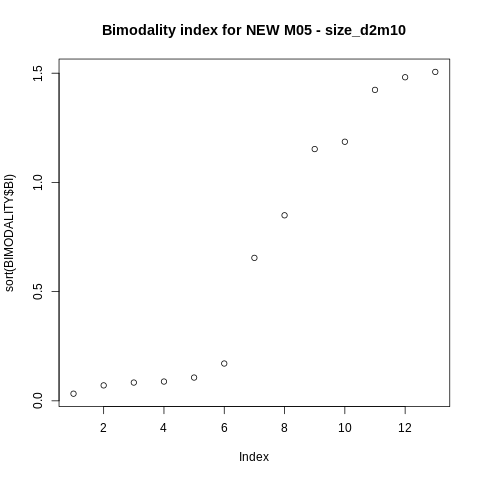

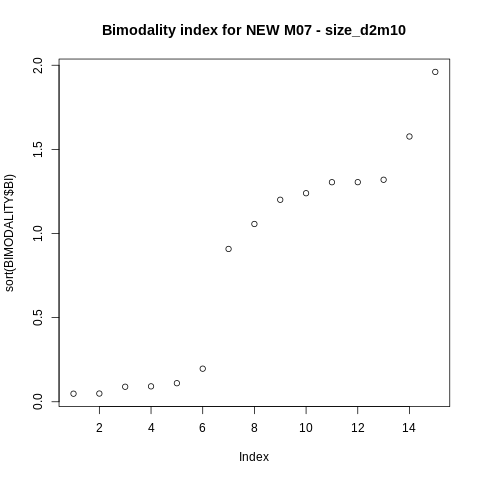

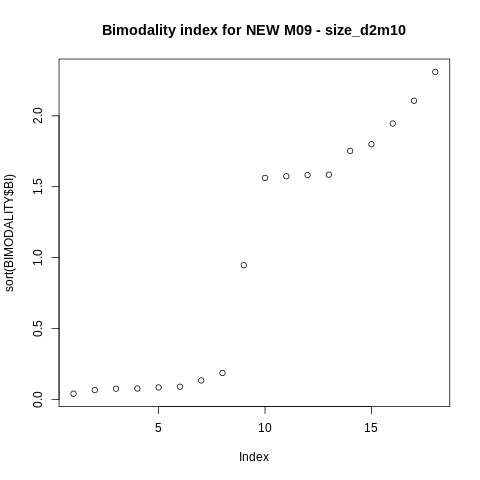

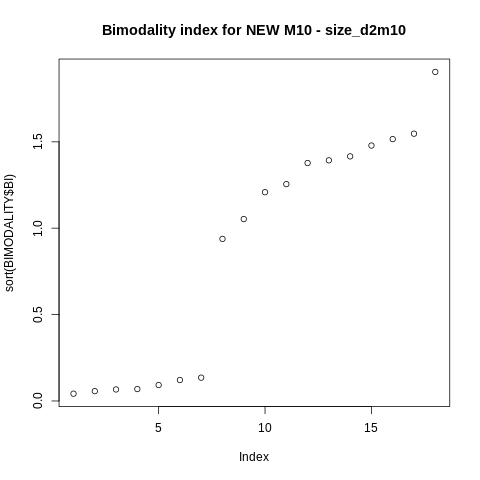

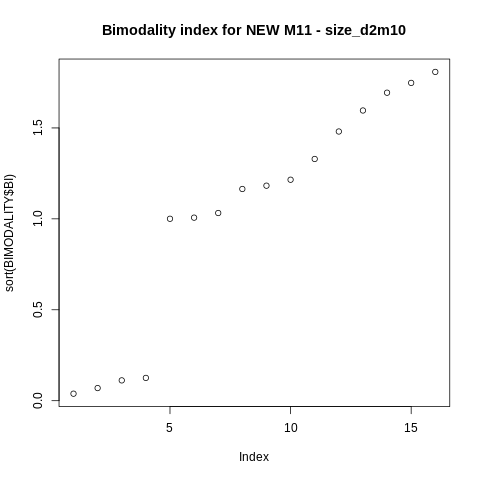

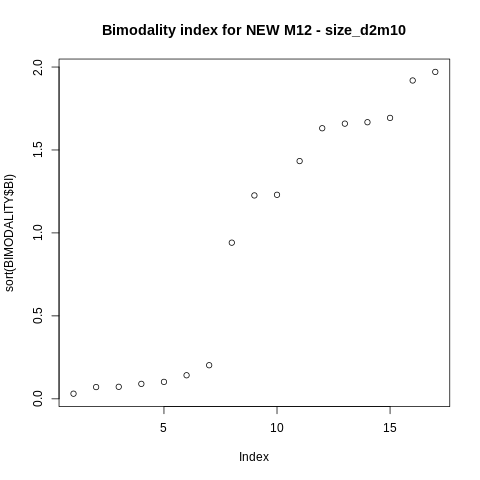

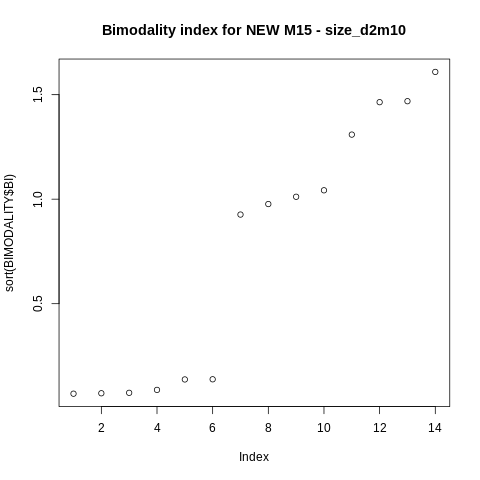

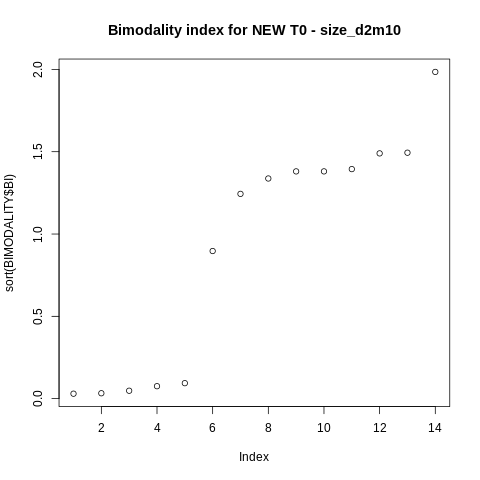

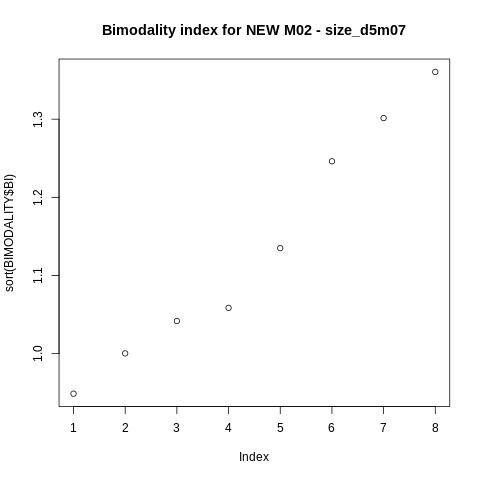

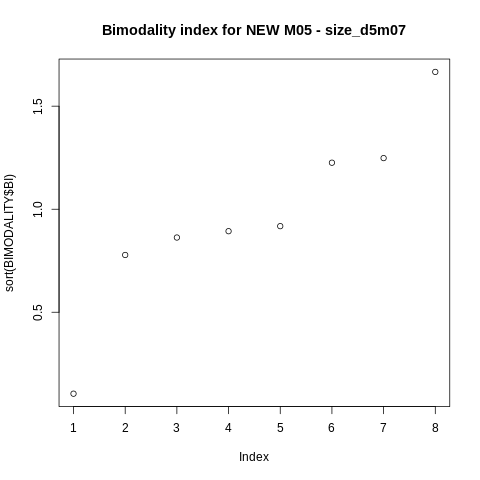

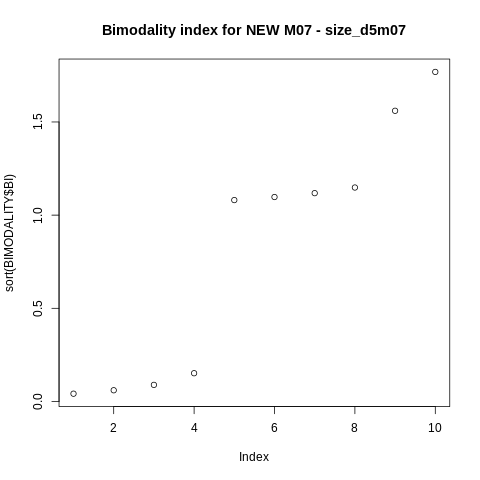

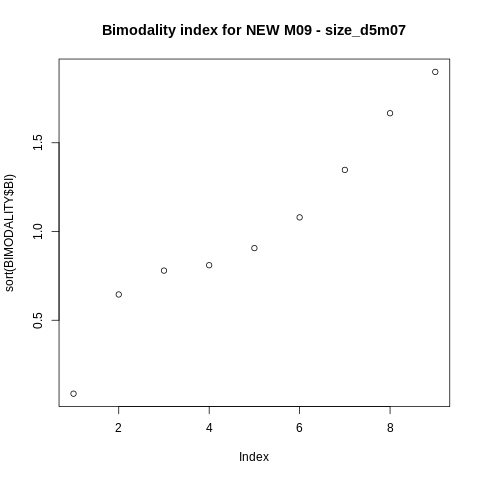

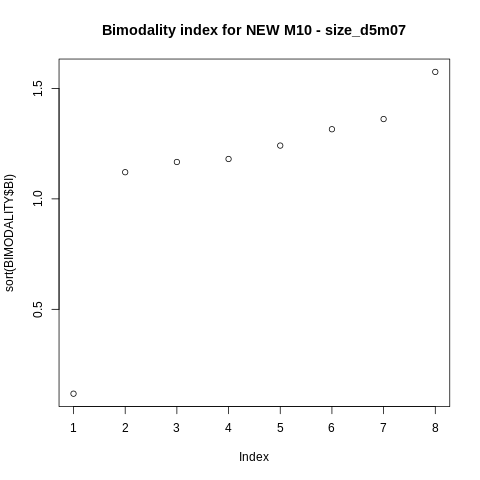

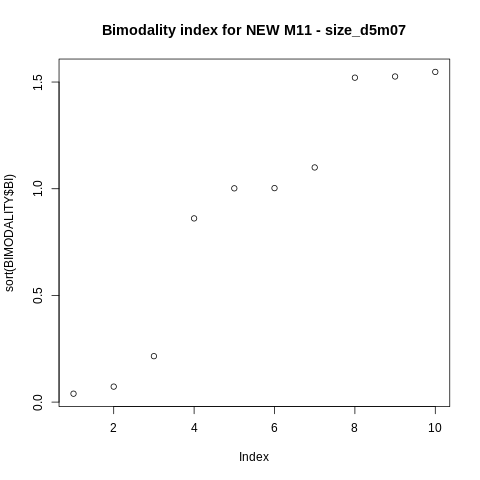

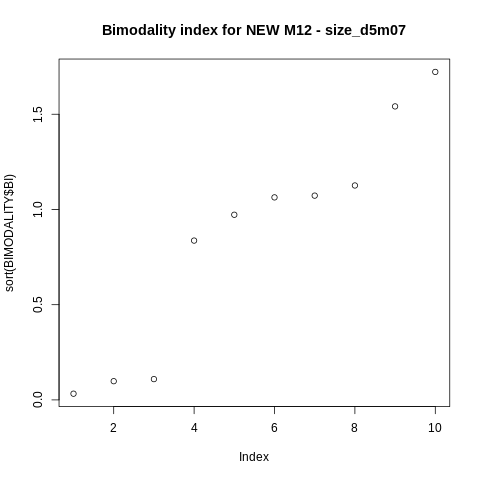

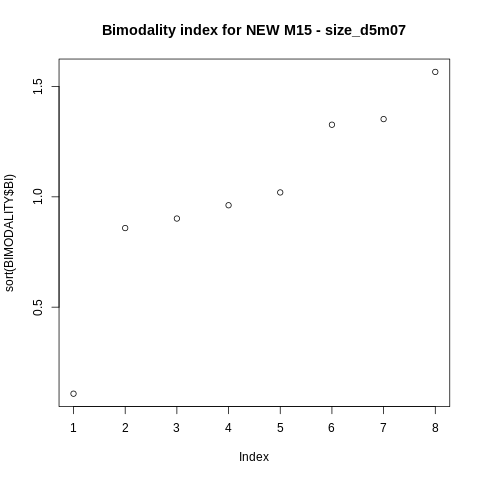

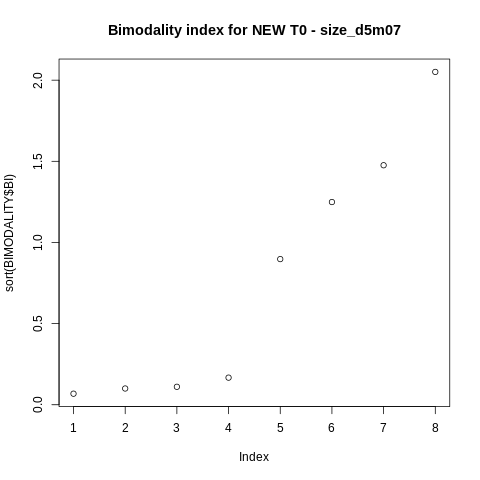

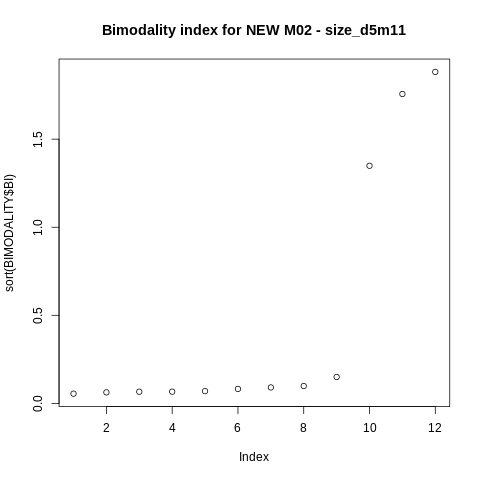

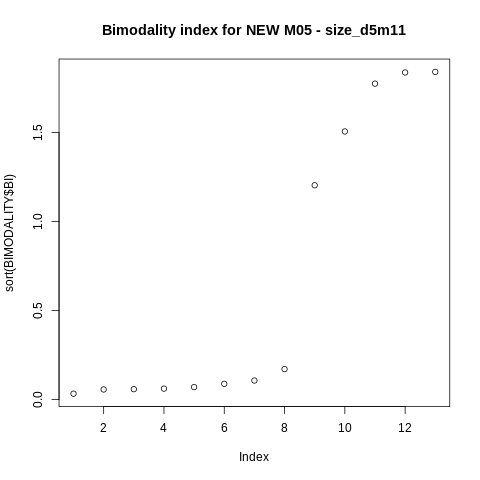

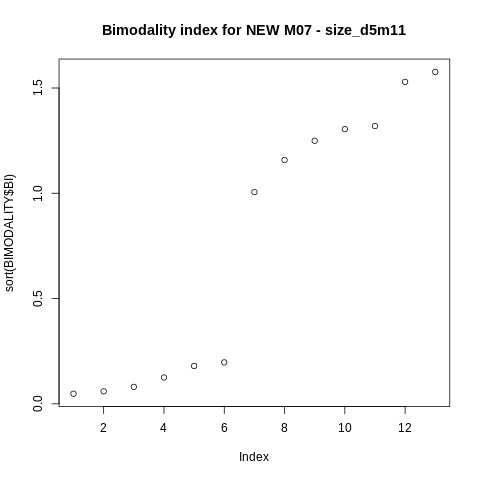

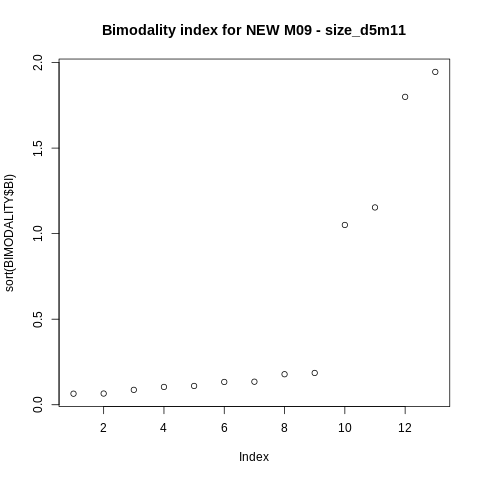

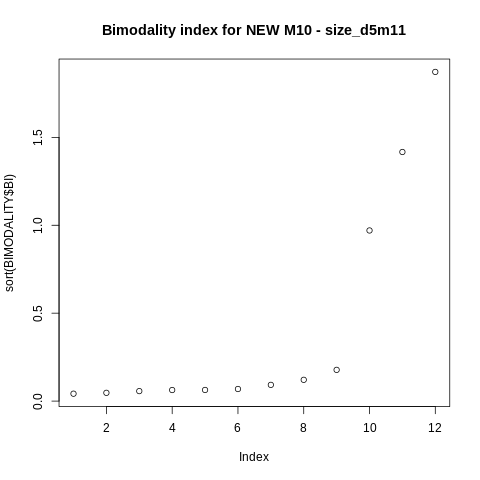

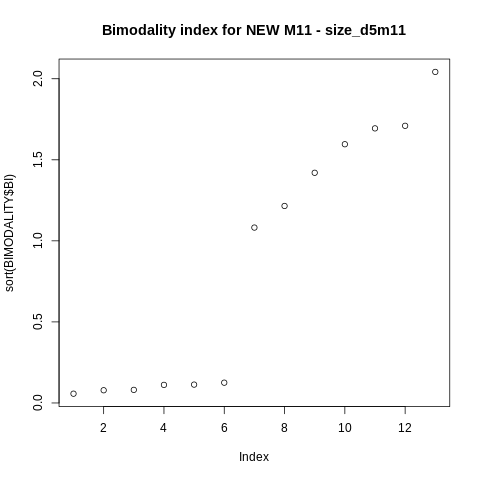

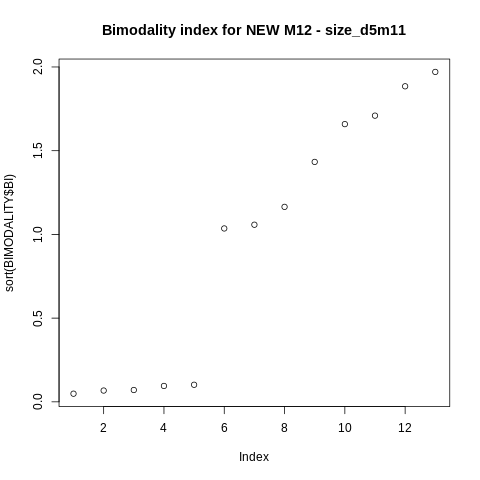

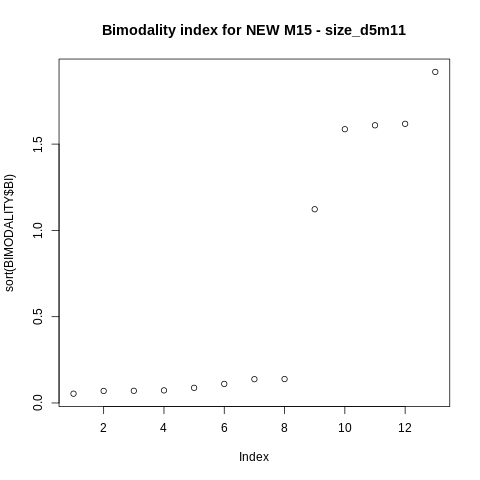

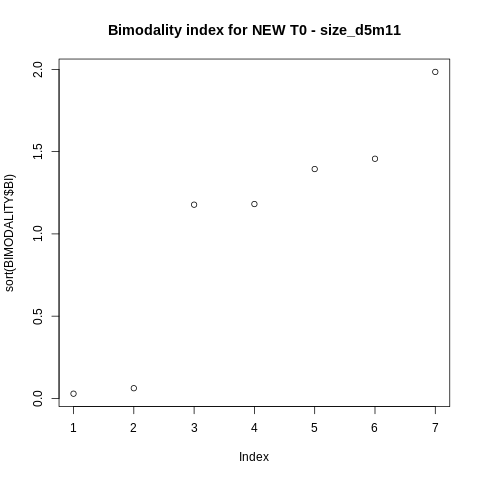

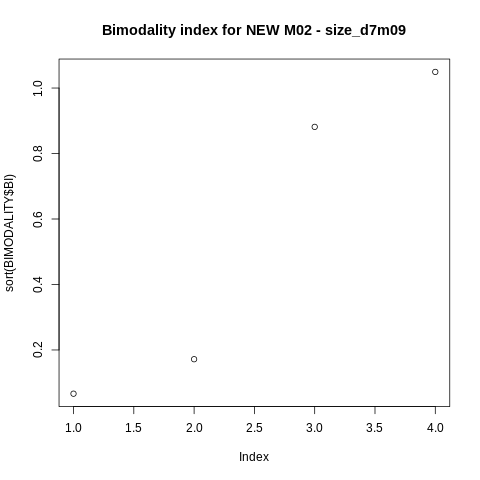

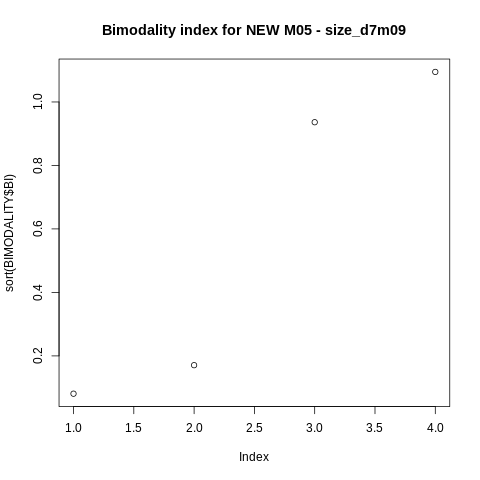

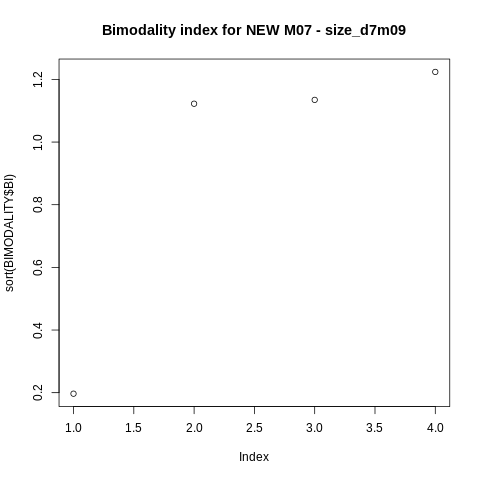

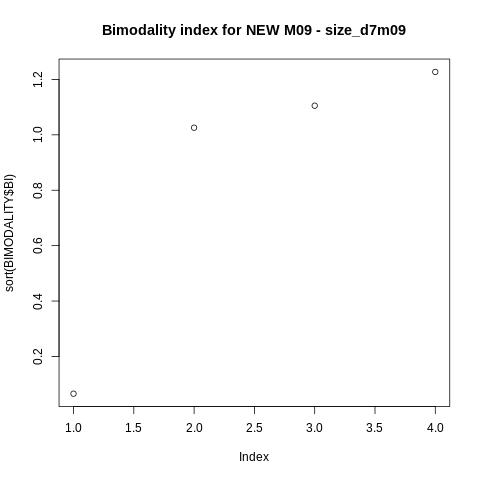

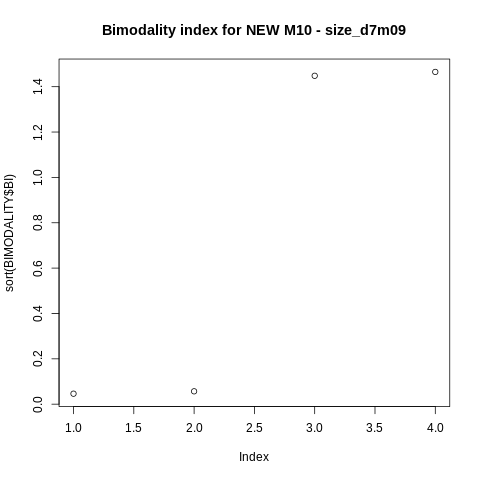

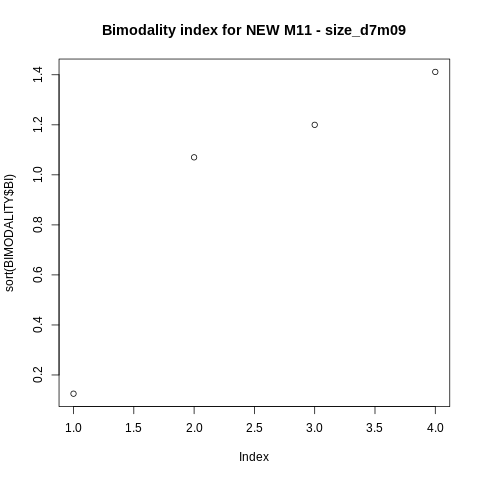

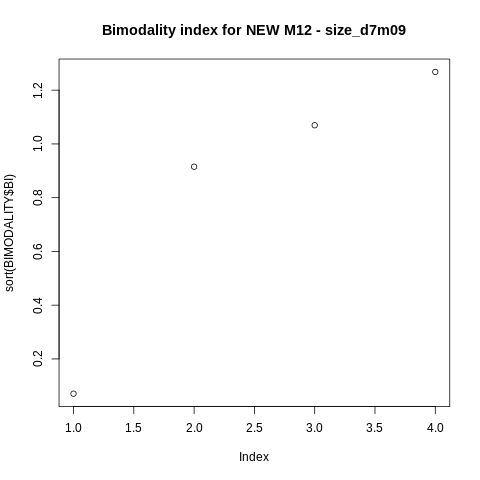

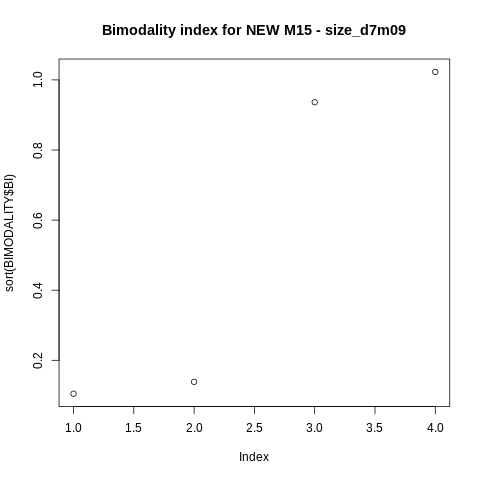

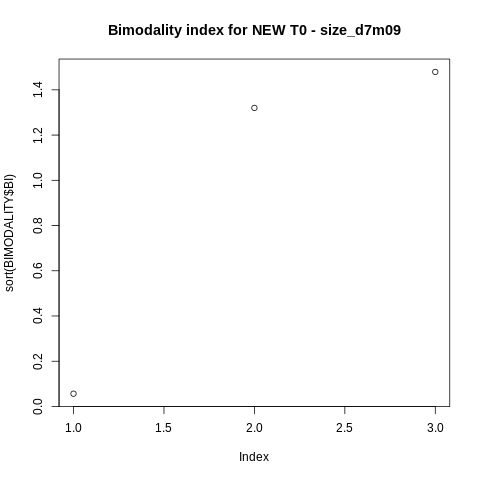

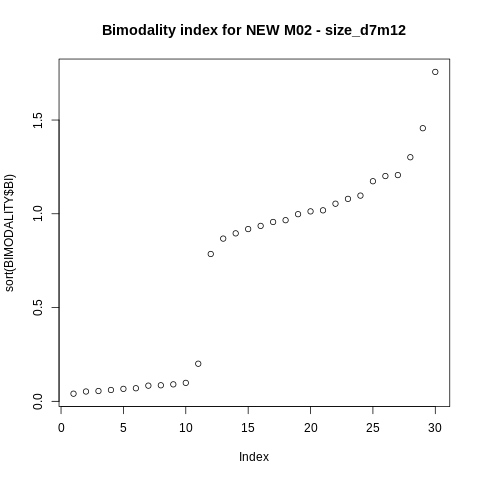

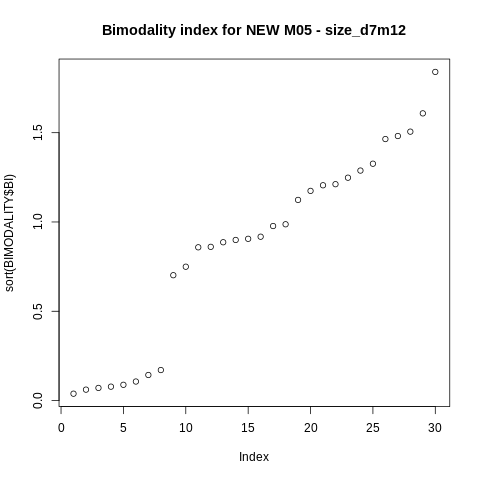

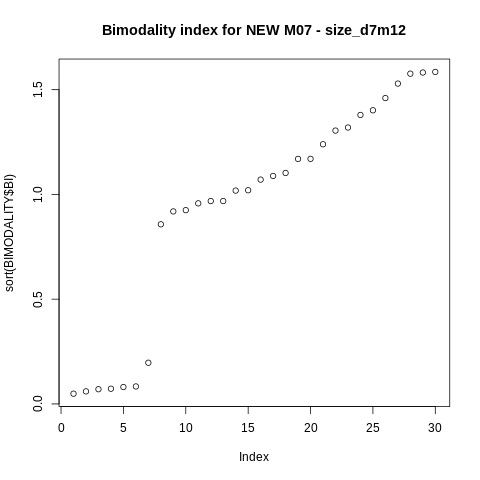

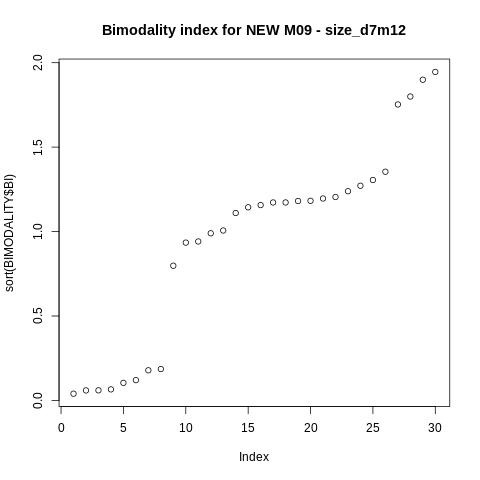

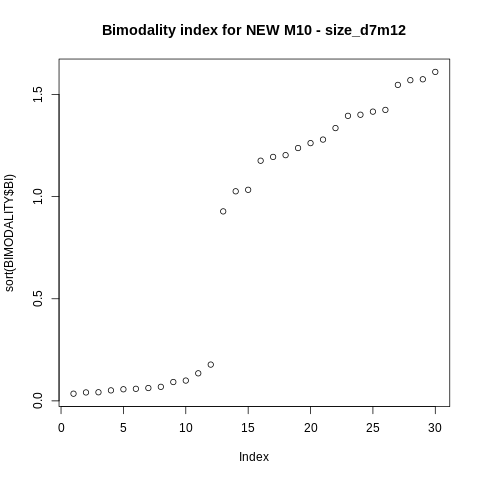

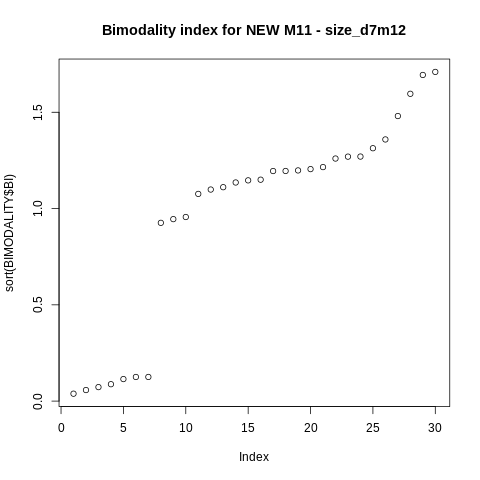

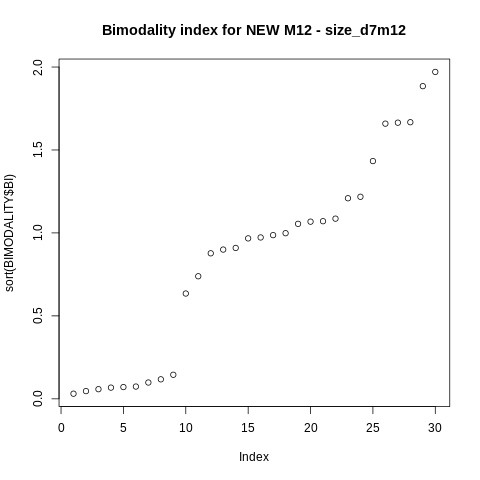

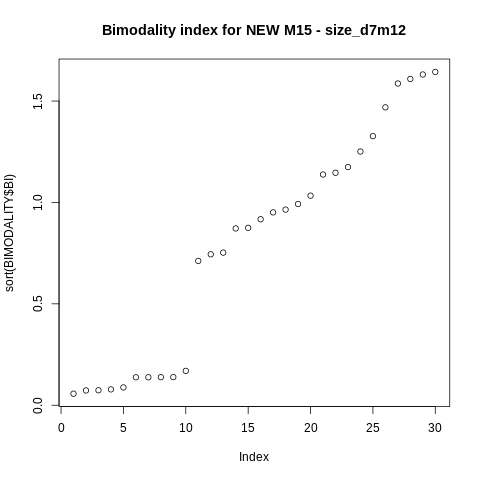

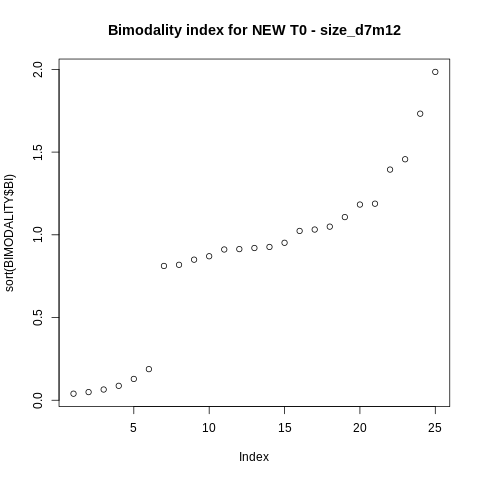

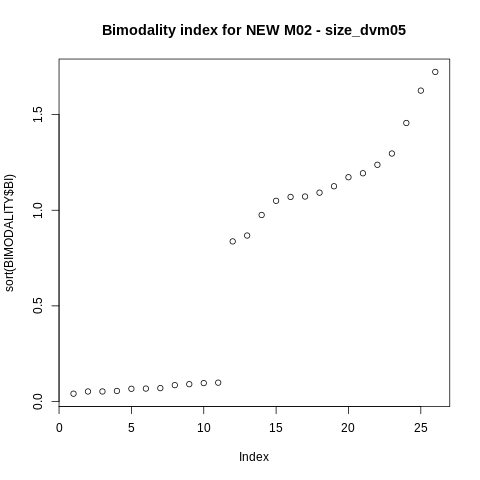

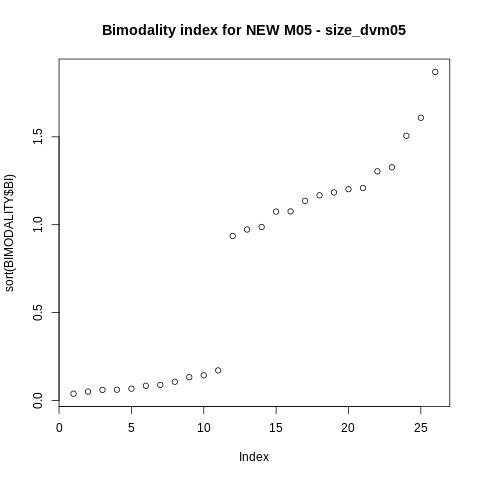

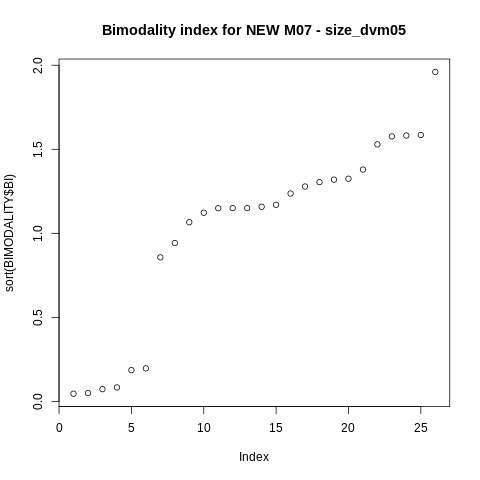

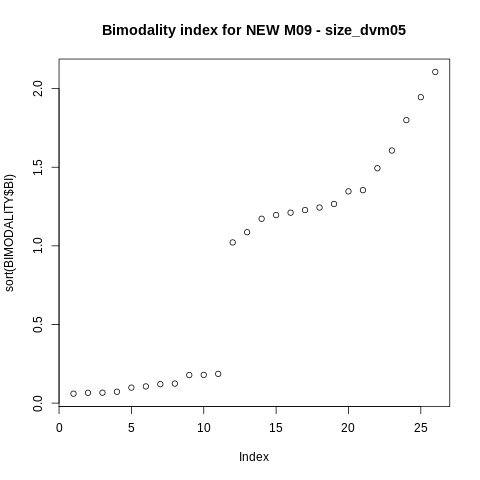

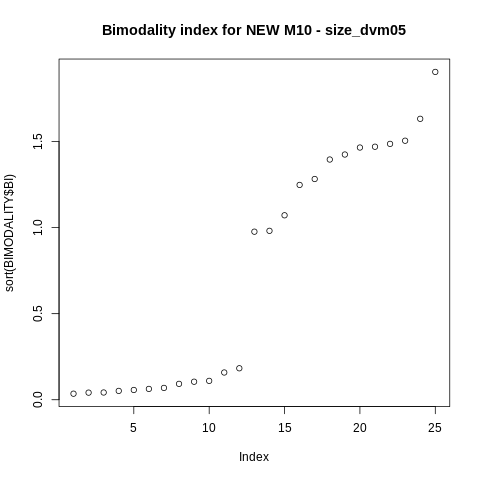

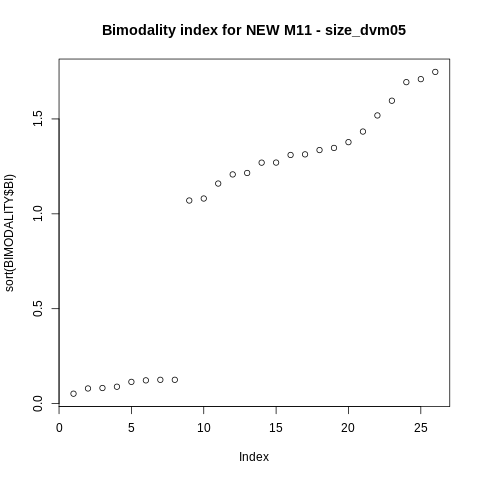

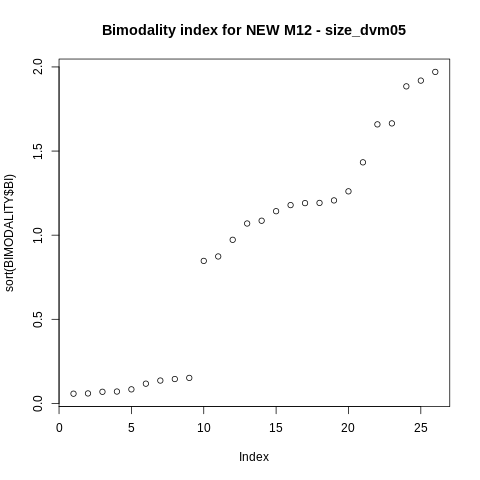

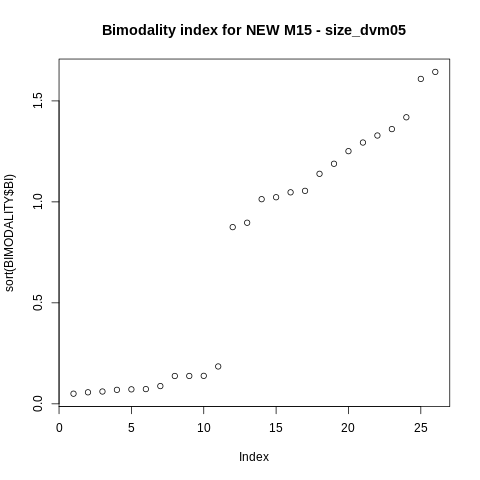

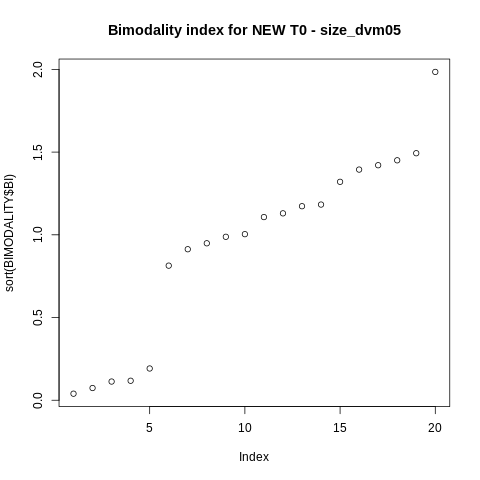

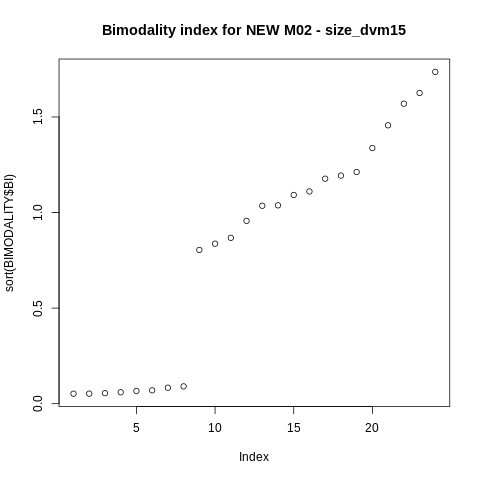

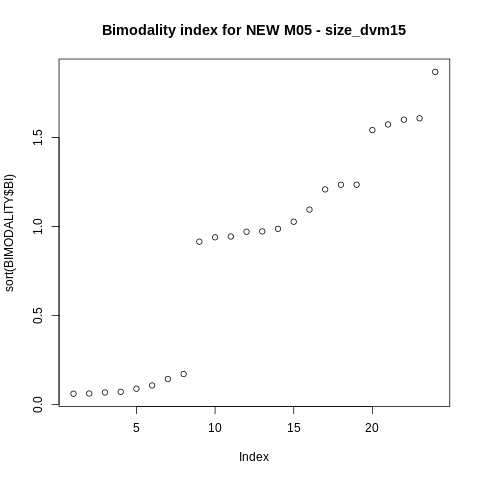

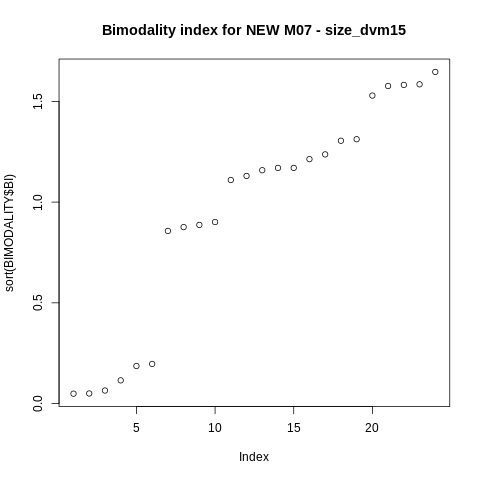

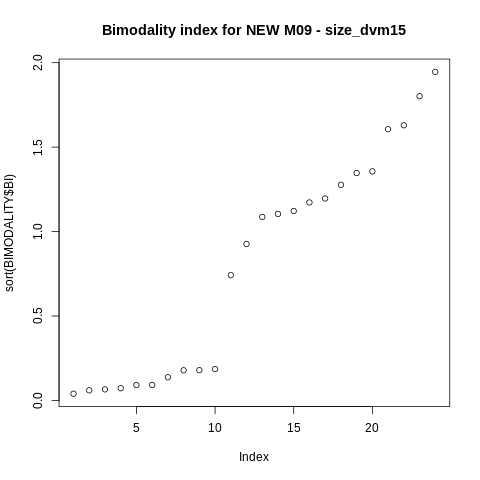

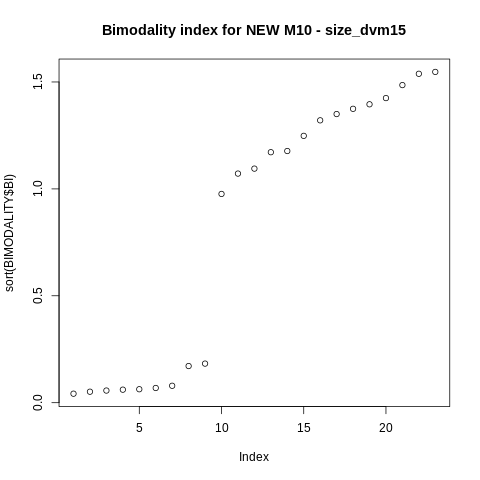

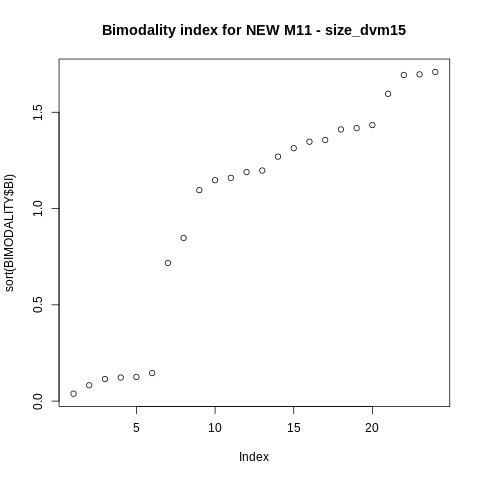

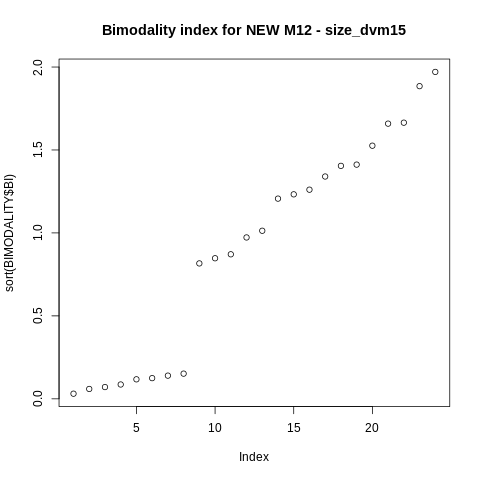

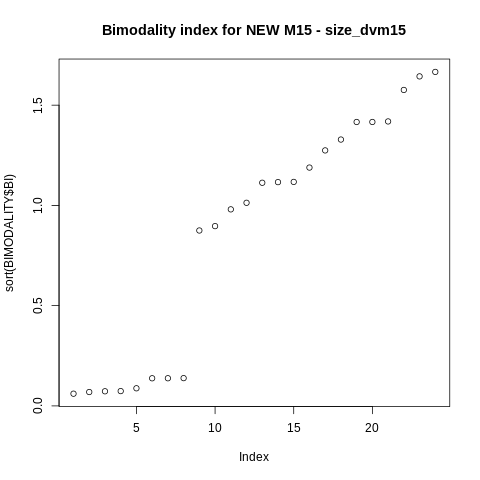

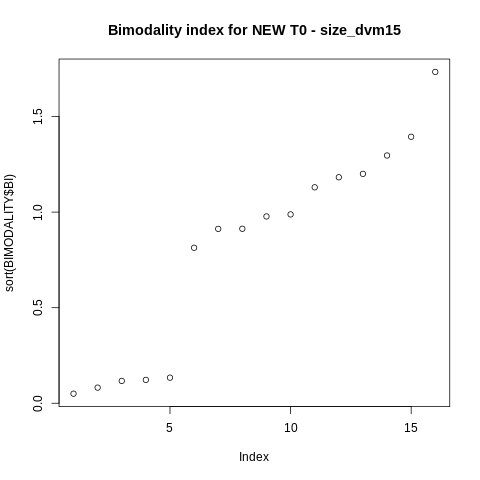

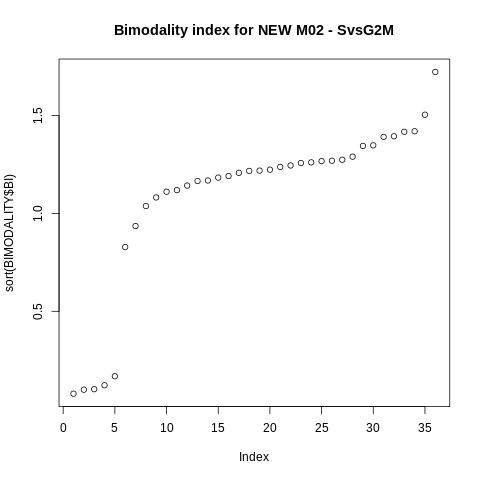

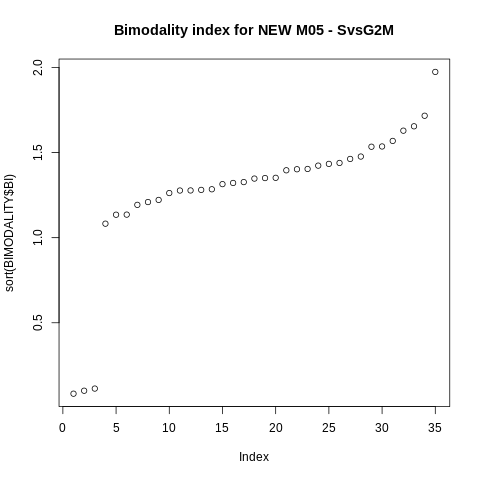

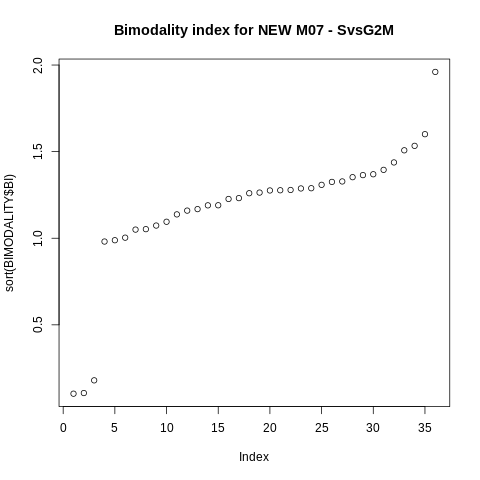

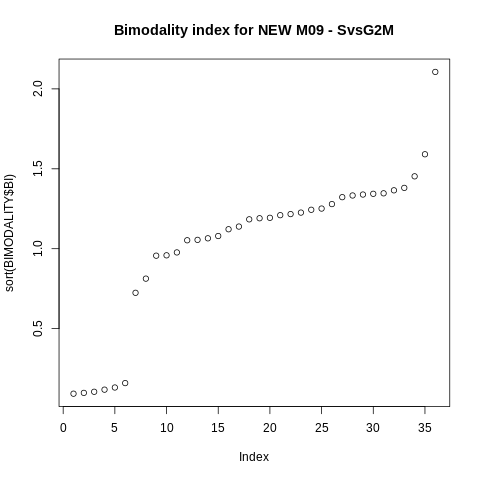

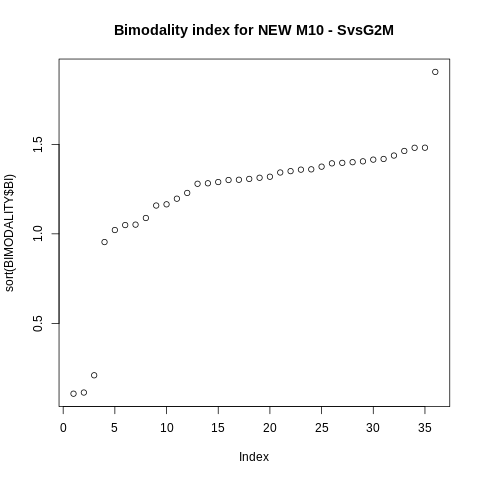

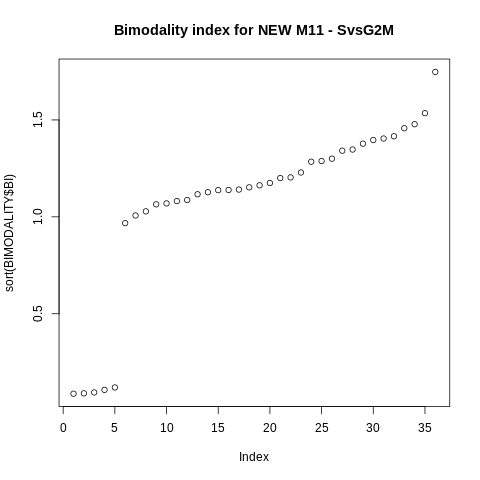

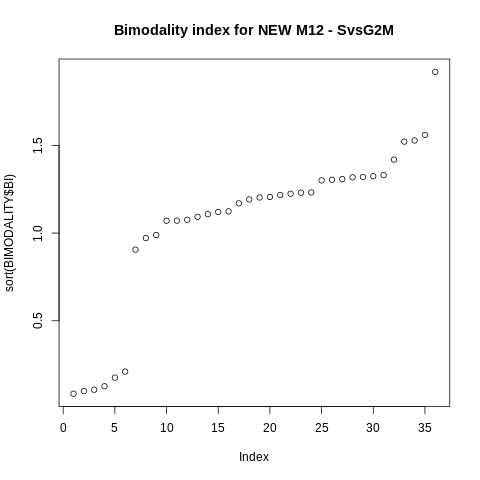

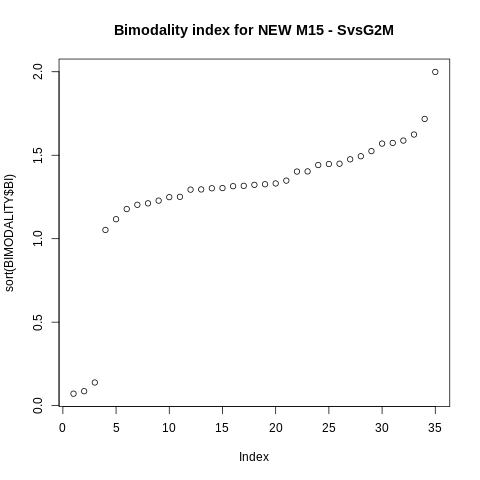

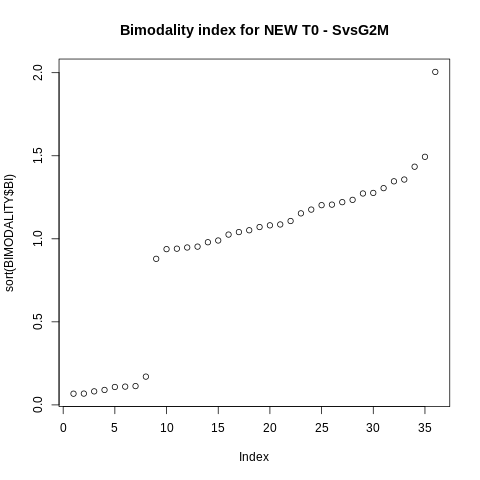

In [ ]:
%%R
FILES <- list.files(path = TEMPdir, pattern = "Bimodality")
for (FILE in paste(TEMPdir, FILES, sep = "")){
    print(FILE)
    BIMODALITY <- readRDS(FILE)
    SAMPLE <- strsplit(FILE, "-")[[1]][3]
    LISTS <- strsplit(FILE, "-")[[1]][2]
    DATASET <- strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]

    plot(sort(BIMODALITY$BI), main = paste("Bimodality index for ", DATASET, " ",  SAMPLE, " - ", LISTS, sep = ""))

}

In [ ]:
%%R
# Select the genes succesffully classified as bimodal (BI >= 1.1)
FILES <- list.files(path = TEMPdir, pattern = "Bimodality")
for (FILE in paste(TEMPdir, FILES, sep = "")){
    print(FILE)
    BIMODALITY <- readRDS(FILE)
    SAMPLE <- strsplit(FILE, "-")[[1]][3]
    LISTS <- strsplit(FILE, "-")[[1]][2]
    DATASET <- strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]

    BIMODALITY <- BIMODALITY[BIMODALITY$BI >= 1.1, ]
    print(BIMODALITY)

}



[1] "/content/drive/MyDrive/MELBOURNEbimodal/TEMPORAL/Bimodality-g2m_d0p1-M02-NEW.Rds"
                 mu1       mu2     sigma    delta        pi       BI
Ube2c     4.60821712 31.370260 6.5656295 4.076082 0.7669292 1.723314
Cenpf     2.23042402 13.749149 2.8653109 4.020061 0.8834393 1.290022
Arl6ip1   6.72086976 28.784782 6.0673383 3.636506 0.7993780 1.456296
Tubb4b    8.84981334 34.260868 7.7142865 3.294025 0.8298577 1.237756
Nusap1    1.65359042  8.689934 2.0130070 3.495439 0.8192565 1.345064
Cenpa     2.96177419 13.012070 3.0691168 3.274654 0.7837924 1.348036
Kpna2     0.99789337  6.298838 1.3719109 3.863913 0.8714524 1.293246
Ung       0.21458016  3.040553 0.6081045 4.647182 0.8962034 1.417374
Hmmr      1.51770126  7.548106 1.8155894 3.321459 0.8308682 1.245109
Top2a     6.25231537 21.270539 5.3729759 2.795141 0.7414868 1.223761
Tuba1c    2.07344846  9.756450 2.0191504 3.805067 0.8779205 1.245693
Ccne1     0.29607103  3.665833 0.6269649 5.374721 0.9472723 1.201193
Cdk1      2.9544

## Gather all data into a single table

Gene - Sample - geneList - scShapes distribution - ZI score (PI) - bimodality classification - bimodality index - G1 proportion - Proportion of cells express such gene (Proportion)

In [ ]:
%%R
# Function to estimate the proportion of cells that express each gene
# Previously, we get the counts' table of (final genes x cells) and estimate the proportion for each line
fEXPropCell <- function(LINE){
    TOTAL <- length(LINE)   # The total amount of cells
    EXPRESSED <- table(LINE != 0)["TRUE"]
    PROP <- EXPRESSED/TOTAL
    
    return(PROP)
}

# Data filtering and formatting
FILES <- list.files(path = TEMPdir, pattern = "FINALscs")   # We read the Final scs files

FINALtable <- data.frame()
for (FILE in paste(TEMPdir, FILES, sep = "")){
    # Read final scshapes (List. For each distribution, which genes are classified as such distribution
    SCSf <- readRDS(FILE)[[1]]

    # Which sample, list and dataset uses such file
    SAMPLE <- strsplit(FILE, "-")[[1]][3]
    LISTS <- strsplit(FILE, "-")[[1]][2]
    DATASET <- strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]
    
    # Read ZI values (PI) for that sample with that list in that dataset. List format of PI per gene
    PI <- readRDS(paste(TEMPdir, "ZIV-", LISTS, "-", DATASET, "-", SAMPLE, ".Rds", sep = ""))
    # Read Bimodality table for that sample with that list in that dataset
    BIMO <- readRDS(paste(TEMPdir, "Bimodality-", LISTS, "-", SAMPLE, "-", DATASET, ".Rds", sep = ""))

    # Table of genes and scShapes distributions
    SCS <- data.frame()
    for (TYPEdis in names(SCSf)){
        SCS <- rbind(SCS, cbind(Sample = SAMPLE, List = LISTS, Dataset = DATASET, Gene = SCSf[[TYPEdis]], Distribution = strsplit(TYPEdis, "_")[[1]][1]))
    }

    # Table of bimodality per gene. We use the 1.1 cutoff
    BIMO <- data.frame(BI = BIMO$BI, Bimodality = ifelse(BIMO$BI >= 1.1, "Bimodal", "No bimodal"), Gene = row.names(BIMO),
                       Sample = SAMPLE, List = LISTS, Dataset = DATASET)

    # Table of ZI score (PI)
    PI <- unlist(PI)
    PIgenes <- unlist(lapply(strsplit(names(PI), split = "[.]"), function(x) x[[1]]))
    PI <- data.frame(PI = unlist(PI), Gene = PIgenes, Sample = SAMPLE, List = LISTS, Dataset = DATASET)

    # Join bimodality PI score and scShapes distribution 
    SCS <- merge(SCS, BIMO, by = c("Gene", "Sample", "List", "Dataset"), all = T)
    SCS <- merge(SCS, PI, by = c("Gene", "Sample", "List", "Dataset"), all = T)

    FINALtable <- rbind(FINALtable, SCS) 
    
}

# Once we have all genes, we estimate the proportion of cells with G1 or the proportion of
# cells that express such gene
# The respocitories
G1prop <- c()
EXProp <- c()
for (INDEX in 1:nrow(FINALtable)){  # We need to know the gene and the sample of interest 
    SAM <- FINALtable$Sample[INDEX]   # Which sample
    GENEi <- FINALtable$Gene[INDEX]   # Which gene
    # We select only the counts for a single gene at once
    COUNTSperGene <- COUNTS[[SAM]][GENEi, ]    
    # Wich cells express that gene?
    CELLSexpress <- names(COUNTSperGene)[as.vector(COUNTSperGene != 0)]
    # Extract the phase of the cells that express such gene
    STAGE <- SEUR[[SAM]]@meta.data[CELLSexpress, "Phase"]
   
    # Proportion of G1
    G1prop <- c(G1prop, length(STAGE[STAGE == "G1"]) / length(CELLSexpress) * 100)
    # We have a function to estimate the proportion of cells with expression different to 0
    EXProp <- c(EXProp, fEXPropCell(COUNTSperGene))
}
# We add that info into our table
FINALtable[["G1prop"]] <- G1prop
FINALtable[["Expression"]] <- EXProp
# We remove genes that do not have a classification with scShapes or bimodality
# If the gene is not classified with scShapes and is classified as no bimodal, we save it
FINALtable <- FINALtable[!is.na(FINALtable$Distribution) | !is.na(FINALtable$BI),]

FINALtable[1:5,]

     Gene Sample     List Dataset Distribution       BI Bimodality          PI
1 Arl6ip1    M02 g2m_d0p1     NEW         <NA> 1.456296    Bimodal          NA
3   Aurka    M02 g2m_d0p1     NEW          ZIP 1.207568    Bimodal 0.101932792
4   Aurkb    M02 g2m_d0p1     NEW         ZINB 1.357787    Bimodal 0.133774448
5   Birc5    M02 g2m_d0p1     NEW         <NA> 1.165615    Bimodal          NA
6    Bub3    M02 g2m_d0p1     NEW         <NA> 1.176002    Bimodal 0.006576226
     G1prop Expression
1 11.118378  0.9671094
3  4.848485  0.5218216
4  3.558052  0.6755218
5  6.985032  0.8874130
6  9.650350  0.9044908


In [ ]:
%%R
write.table(FINALtable, paste(FINALdir, "FinalClassificationTable-All.tab"), sep = "\t", col.names = T, row.names = F)

## Now, let's explore it

In case we already have the classification table, we read it

In [ ]:
%%R
FINALtable <- read.table(paste(FINALdir, "FinalClassificationTable-All.tab", sep = ""), sep = "\t", header = T)

#### Comparision of classification with scShapes across samples

[1] "---------------------------------------------------------"
[1] "NEW"


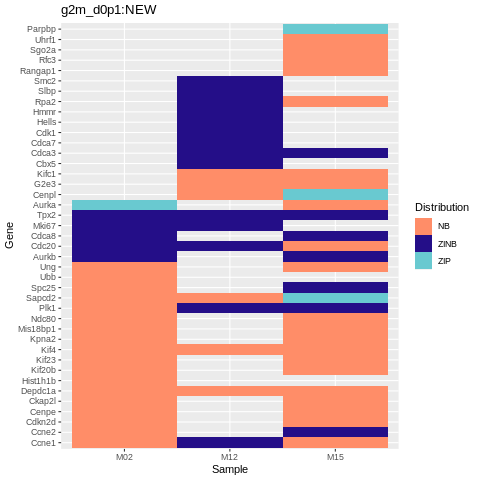

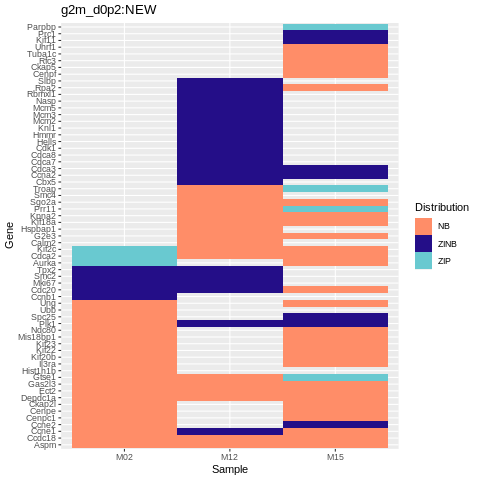

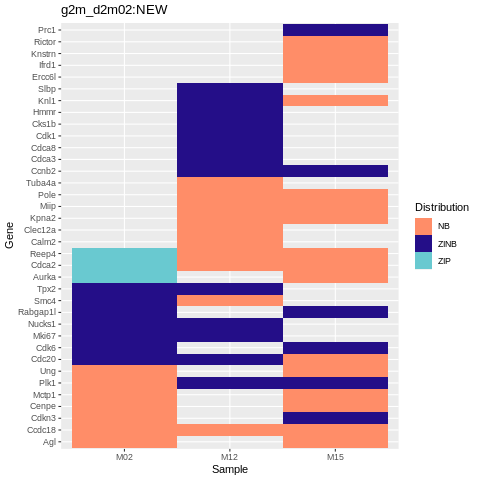

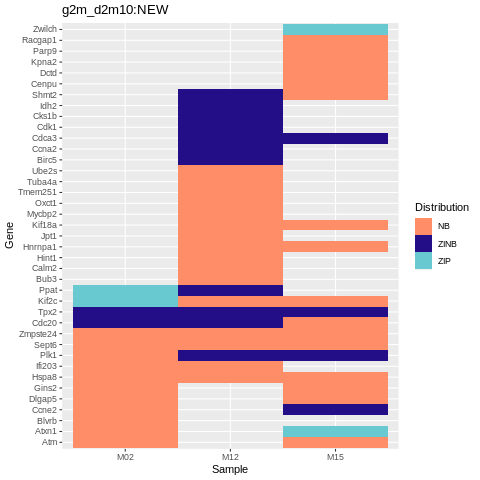

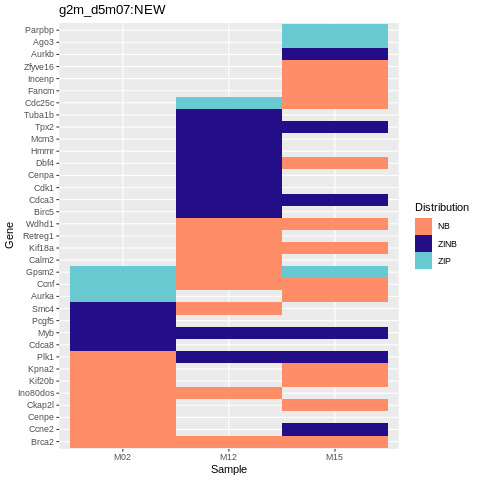

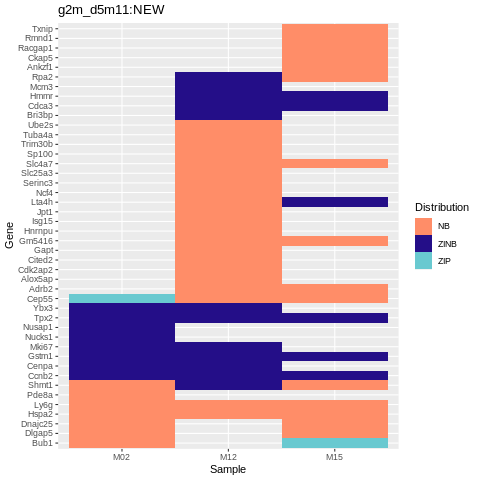

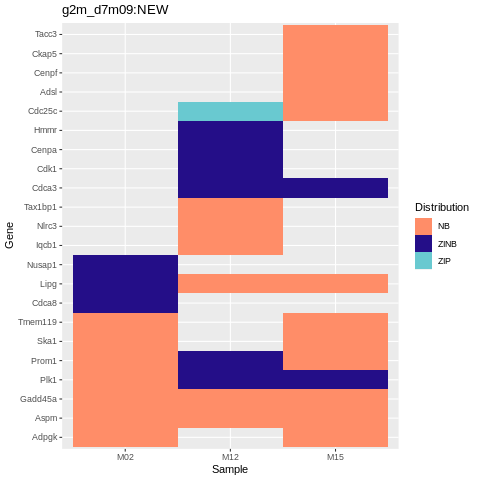

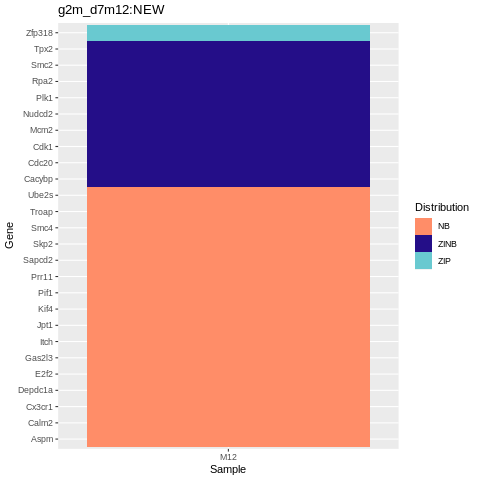

In [ ]:
%%R
# Our final table may have two types of datasets
for (DATASET in unique(FINALtable$Dataset)){
    print("---------------------------------------------------------")
    print(DATASET)
    # We are interested in analysing each list by separate
    for (LISTS in unique(FINALtable$List)){
        # Select only rows of interest
        TEMP <- FINALtable[FINALtable$List == LISTS & FINALtable$Dataset == DATASET & !is.na(FINALtable$Distribution),]
        # This is the order of the y axis (genes), first we sort by sample and then by distribution (genes of the same distribution together)
        TEMP$Gene <- factor(TEMP$Gene, levels = unique(TEMP[order(TEMP$Sample,TEMP$Distribution),]$Gene))
        print(ggplot(TEMP, aes(Sample, Gene, fill = Distribution)) + geom_tile() + ggtitle(paste(LISTS, ":", DATASET, sep = ""))
        + scale_fill_manual(values = c("NB" = "#FF8D68", "ZINB" = "#240E88", "ZIP" = "#69c9d0", "Poisson" = "#FFC13D")) )
    }
}


The dark gray colors represent NA values. For those genes (in that sample), there is a value for the bimodality analysis but there is no classification using scShapes.

The ligth gray values represent genes in which there is no definition of scShapes classificaation or bimodality in that sample.

#### Comparision of bimodality across samples

[1] "---------------------------------------------------------"
[1] "NEW"


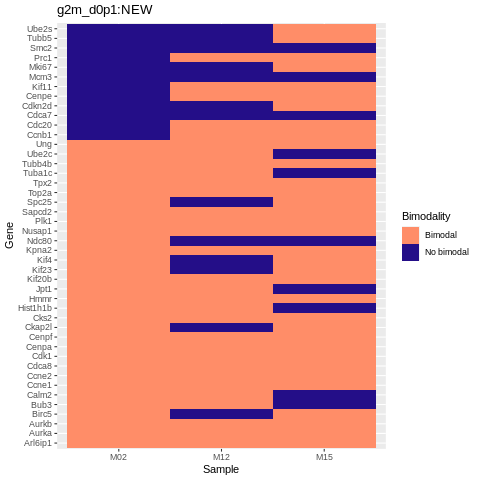

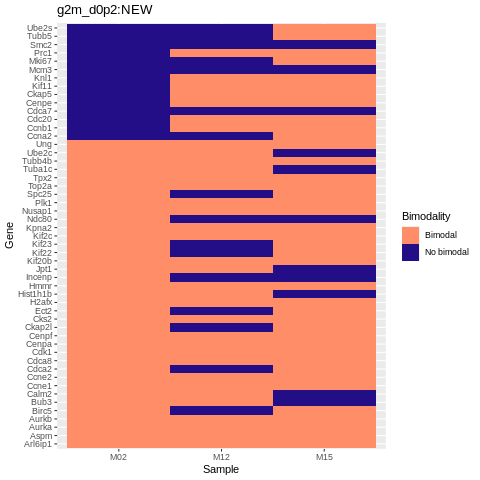

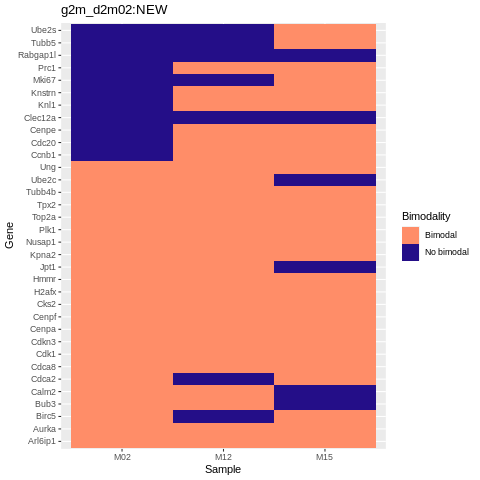

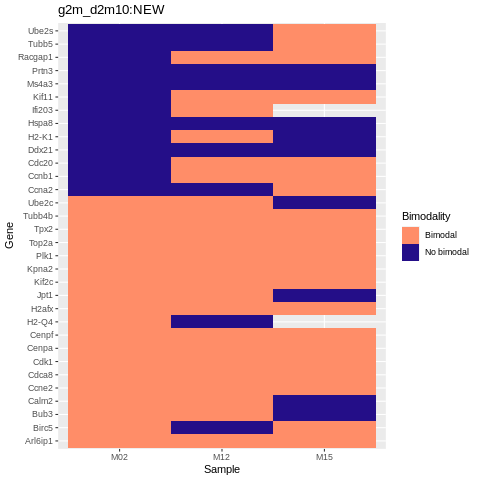

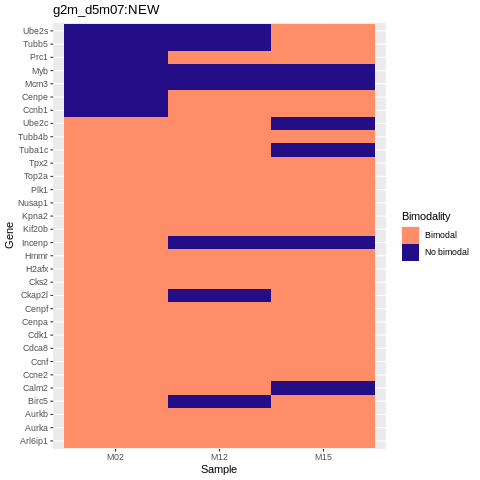

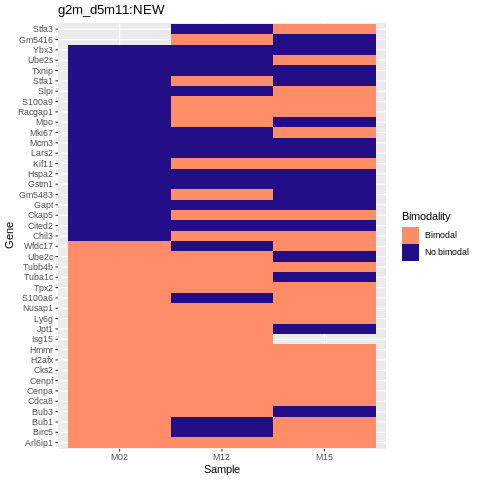

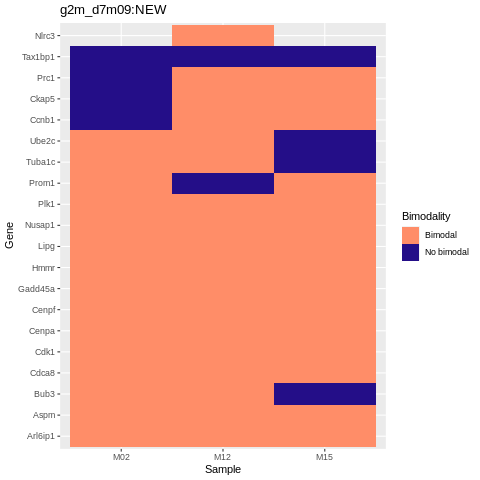

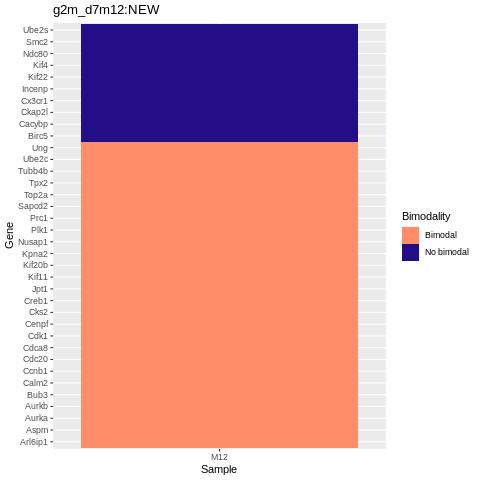

In [ ]:
%%R
# Our final table may have two types of datasets
for (DATASET in unique(FINALtable$Dataset)){
    print("---------------------------------------------------------")
    print(DATASET)
    # We are interested in analysing each list by separate
    for (LISTS in unique(FINALtable$List)){
        # Select only rows of interest
        TEMP <- FINALtable[FINALtable$List == LISTS & FINALtable$Dataset == DATASET & !is.na(FINALtable$Bimodality),]
        # This is the order of the y axis (genes), first we sort by sample and then by distribution (genes of the same distribution together)
        TEMP$Gene <- factor(TEMP$Gene, levels = unique(TEMP[order(TEMP$Sample,TEMP$Bimodality),]$Gene))
        print(ggplot(TEMP, aes(Sample, Gene, fill = Bimodality)) + geom_tile() + ggtitle(paste(LISTS, ":", DATASET, sep = ""))
        + scale_fill_manual(values = c("Bimodal" = "#FF8D68", "No bimodal" = "#240E88")))
    }
}

#### Comparision of scShapes classification and bimodality classification across genes in a single sample

       Gene Distribution Bimodality
10    Ccne1           NB    Bimodal
11    Ccne2           NB    Bimodal
21   Ckap2l           NB    Bimodal
25 Hist1h1b           NB    Bimodal
29   Kif20b           NB    Bimodal
30    Kif23           NB    Bimodal
31     Kif4           NB    Bimodal
32    Kpna2           NB    Bimodal
36    Ndc80           NB    Bimodal
38     Plk1           NB    Bimodal
     Gene     variable                           value
1 Arl6ip1 Distribution                    Unclassified
2   Aurka Distribution           Zero Inflated Poisson
3   Aurkb Distribution Zero Inflated Negative Binomial
4   Birc5 Distribution                    Unclassified
5    Bub3 Distribution                    Unclassified
        Gene Distribution Bimodality
180     Aspm           NB    Bimodal
191    Ccne1           NB    Bimodal
192    Ccne2           NB    Bimodal
202   Ckap2l           NB    Bimodal
206     Ect2           NB    Bimodal
211 Hist1h1b           NB    Bimodal
217   Kif20b   

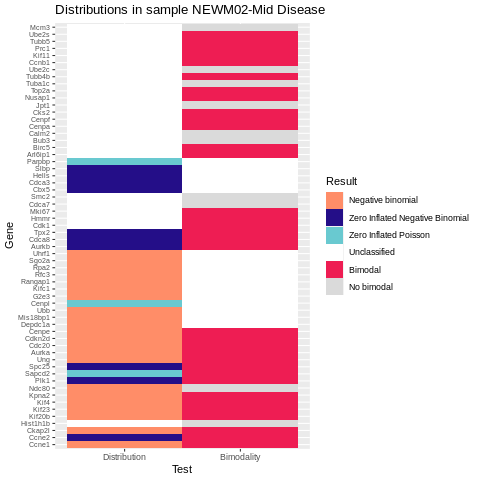

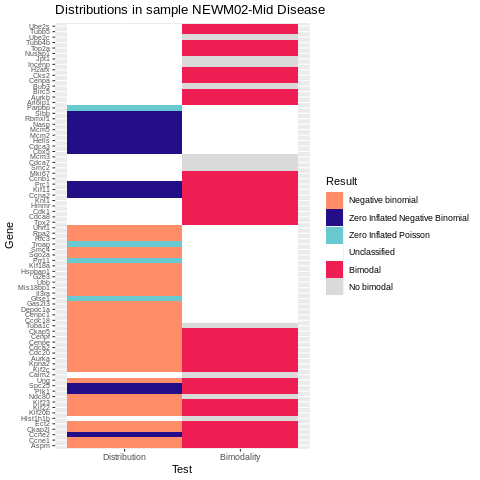

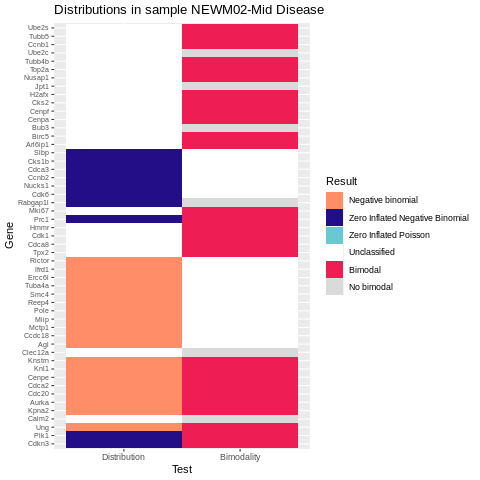

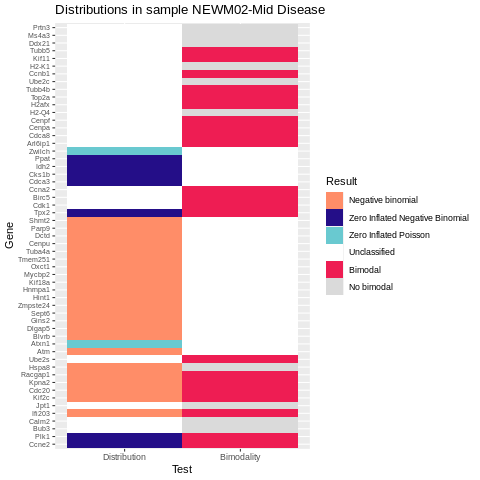

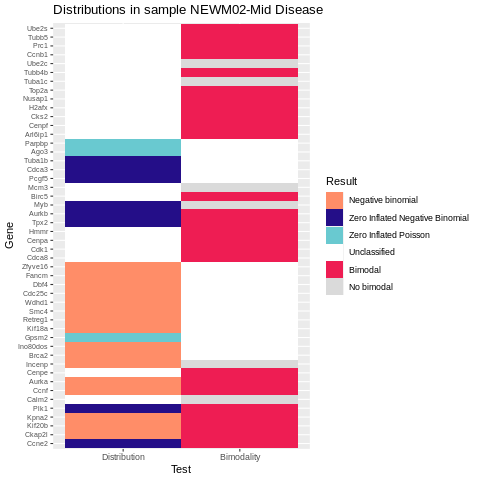

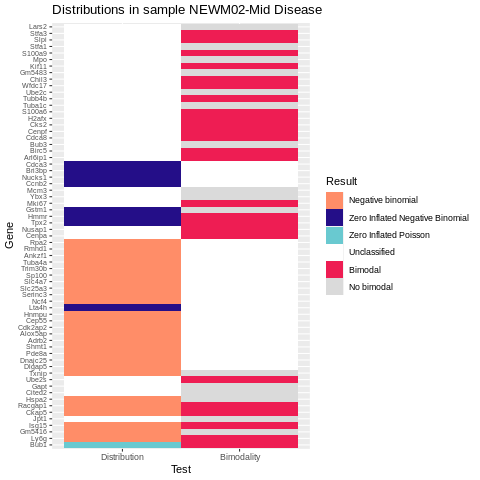

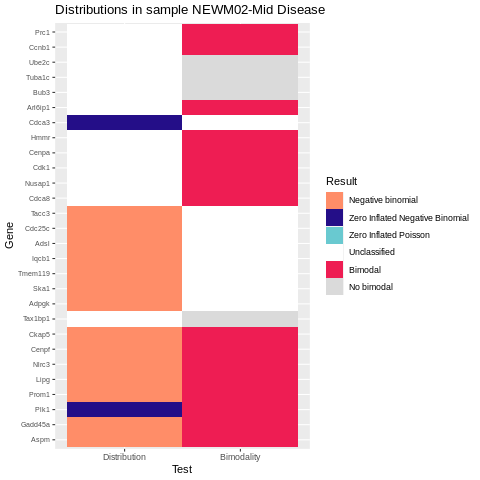

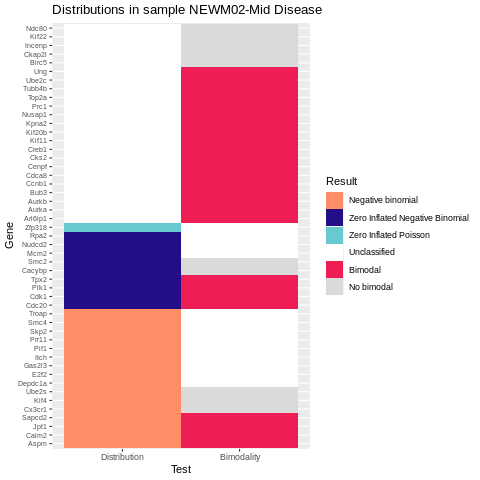

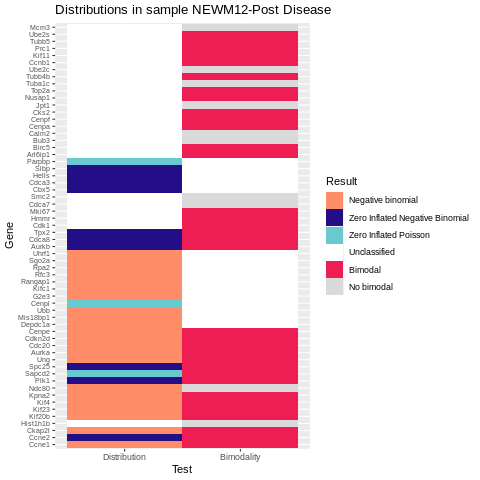

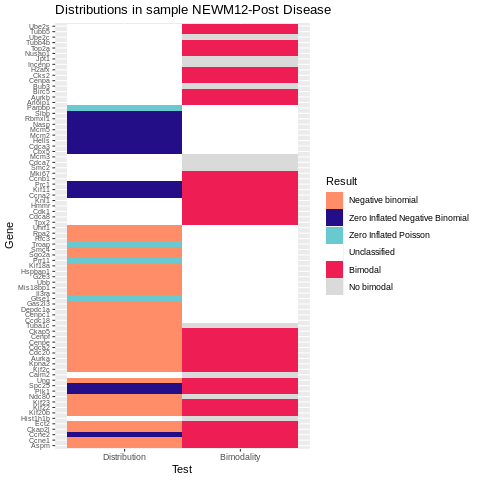

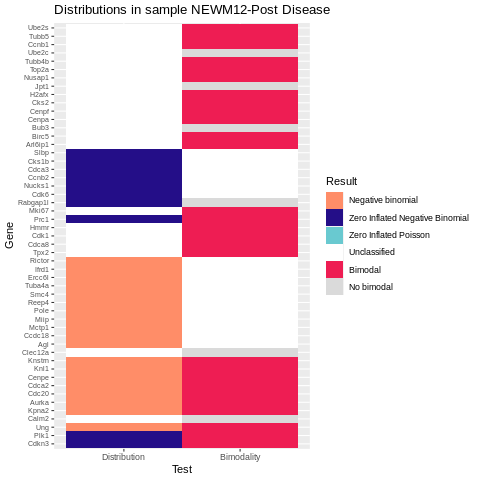

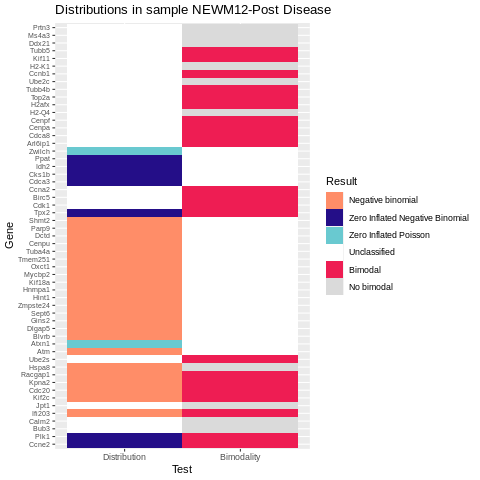

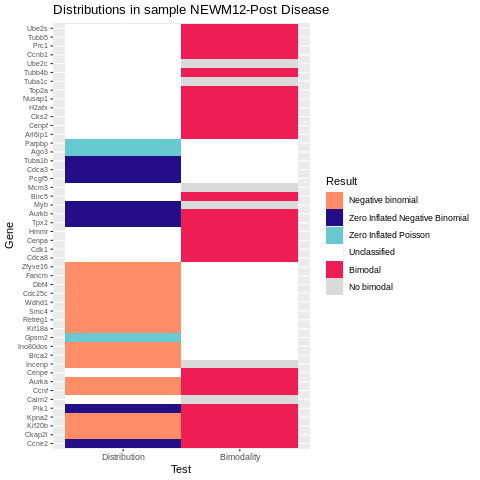

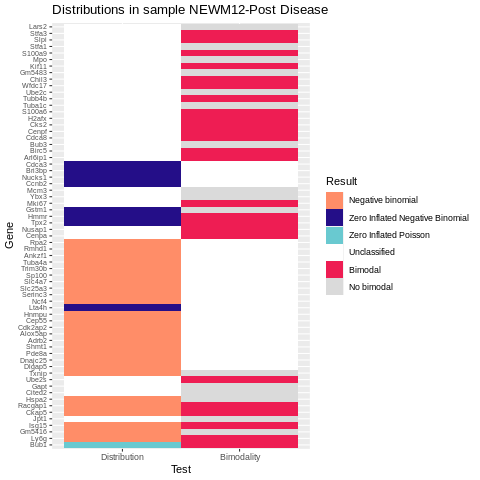

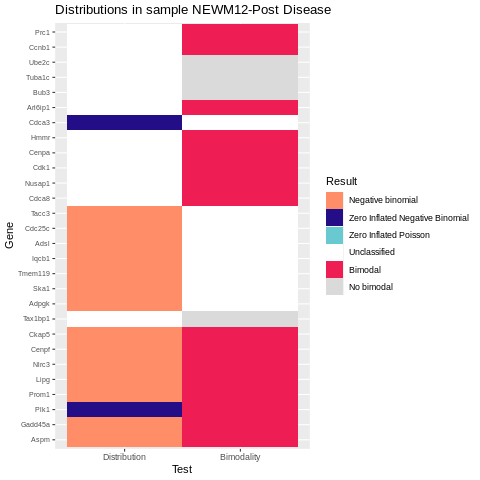

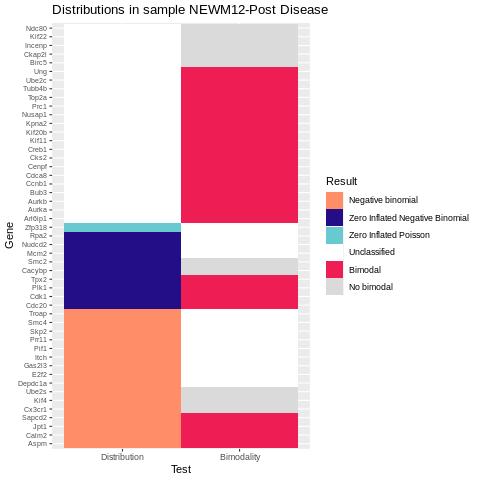

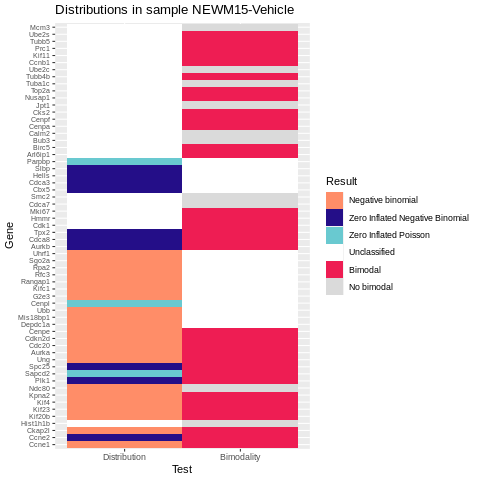

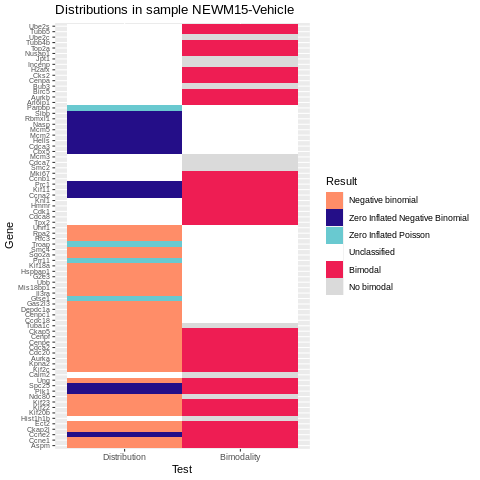

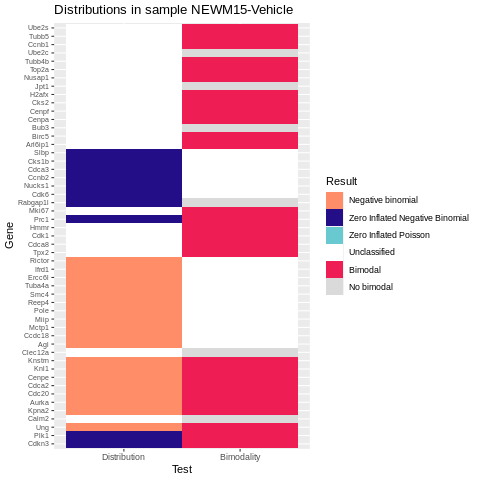

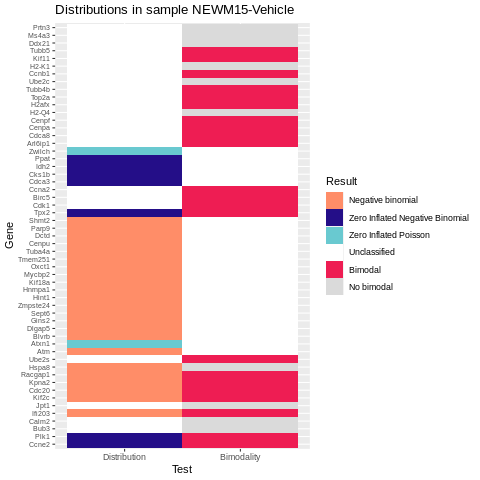

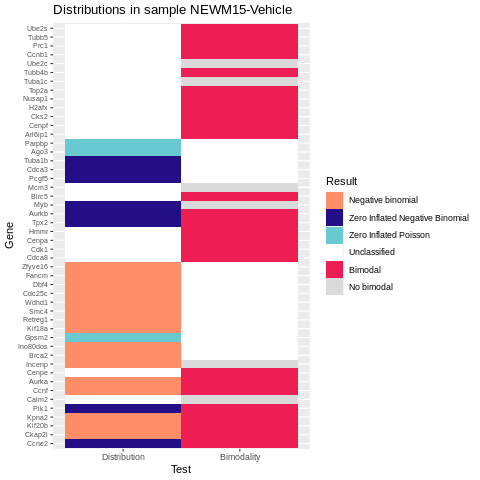

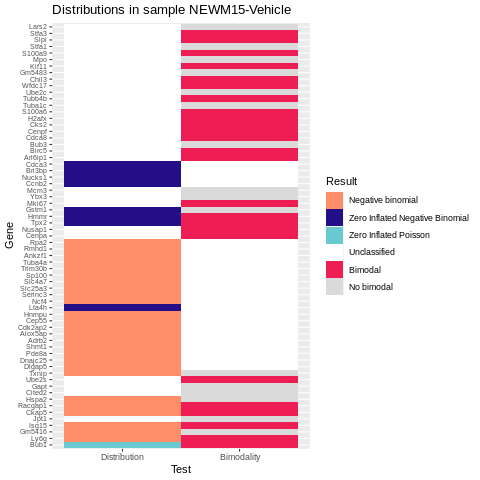

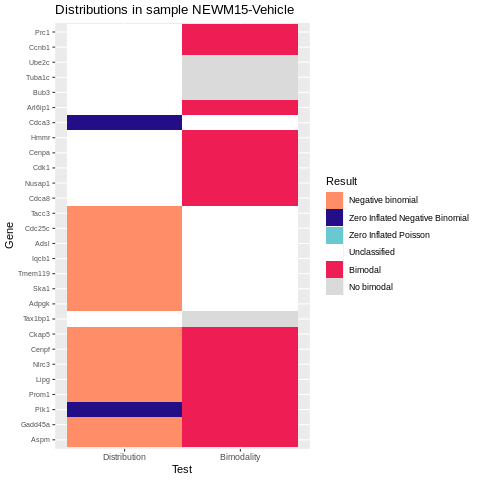

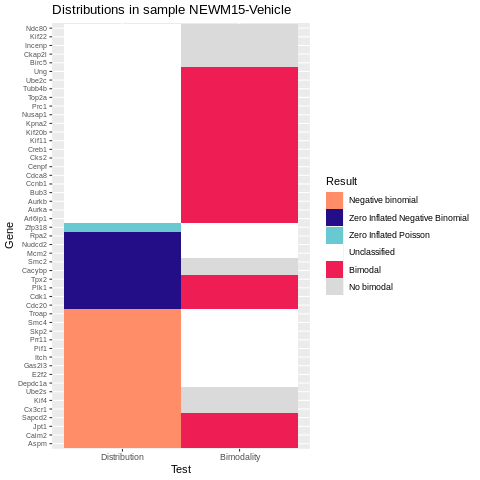

In [ ]:
%%R
## Heatmaps
for (DATASET in unique(FINALtable$Dataset)){
    for (SAMPLE in unique(FINALtable$Sample)){
        for (LISTS in unique(FINALtable$List)){
            # Select only rows of interest and the columns of interest  
            # We already filter by sample, dataset and lists
            TEMP <- FINALtable[FINALtable$List == LISTS & FINALtable$Dataset == DATASET, c("Gene", "Distribution", "Bimodality")]
            # Sort genes (y axis labels) to display genes classified with the same distribution of scShapes together
            # And then, we cluster genes classified as bimodal together
            FACTOR <- unique(TEMP[order(TEMP$Distribution,TEMP$Bimodality),]$Gene)
            
            # Change names to a more understandable labels
            TEMP[TEMP == "NB"] <- "Negative binomial"
            TEMP[TEMP == "ZINB"] <- "Zero Inflated Negative Binomial"
            TEMP[TEMP == "ZIP"] <- "Zero Inflated Poisson"
            TEMP[TEMP == "P"] <- "Poisson"
            TEMP[is.na(TEMP)] <- "Unclassified"

            # ggplot format
            TEMP <- melt(TEMP, id.var = c('Gene'))  # We want to keep the gene as reference
            # Use the order
            TEMP$Gene <- factor(TEMP$Gene, levels = FACTOR)
            # Rename with nice/more intuitive labels
            colnames(TEMP) <- c("Gene", "Test", "Result")
            TEMP$Result <- factor(TEMP$Result, levels = c("Negative binomial", "Poisson", "Zero Inflated Negative Binomial", "Zero Inflated Poisson", "Unclassified", "Bimodal", "No bimodal"))

            G <- ggplot(TEMP, aes(Test, Gene, group = Test)) + geom_tile(aes(fill = Result)) + 
                    #facet_grid(rows = vars(TABLE[, "Cell cycle signature"]), cols = vars(TABLE[, "Test"]), scales = "free", space="free_y") + 
                    scale_fill_manual(values = c("Negative binomial" = "#FF8D68", "Zero Inflated Negative Binomial" = "#240E88", "Zero Inflated Poisson" = "#69c9d0", "Poisson" = "#FFC13D", "No bimodal" = "#dadada", "Bimodal" = "#EE1D53",  "Unclassified" = "white")) + 
                    theme(axis.text.y = element_text(size = 7)) + 
                    ggtitle(paste("Distributions in sample ", DATASET, SAMPLE, "-", SAMPLESclass[[DATASET]][SAMPLE, "TYPE"], sep = ""))
            print(G)
            #ggsave(paste(path = IMAGEdir, filename = "/DistrHeatM-David12Feb_", OLDnew,  "Data_Sample", SAMPLE, strsplit(SAMPLESclass[[OLDnew]][SAMPLE, "TYPE"], " ")[[1]][1], ".pdf", sep = ""))
        }
    }
}


### Venn Diagram
Which genes are classified the same in all samples or just two samples?. Which genes are unique?

scShapes classification

scShapes classification

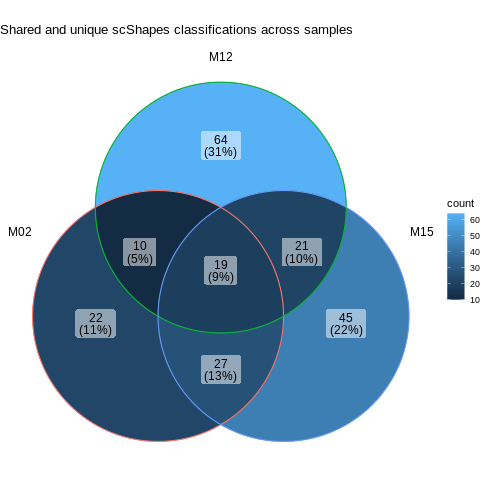

In [ ]:
%%R
# The genes separated by sample
VENgenes <- list()
for (DATASET in unique(FINALtable$Dataset)){
    for (SAMPLE in unique(FINALtable$Sample)){
        # We separate the table by sample and dataset
        VENgenes[[SAMPLE]] <- FINALtable[FINALtable$Dataset == DATASET & FINALtable$Sample == SAMPLE & !is.na(FINALtable$Distribution), c("Gene", "Distribution", "Bimodality")]    
    }
    # We want to know the gene and classification separated by samples
    # for each sample, we paste the gene and the classfication
    VENgenes <- lapply(VENgenes, function(x) apply(x, 1, function(y) paste(y[1], y[2])))

    print(ggVennDiagram(VENgenes) + ggtitle("Shared and unique scShapes classifications across samples"))
    #ggsave(paste(IMAGEdir, "VENNscShapesClassificationSamples.Rds"))
}

Bimodality classification

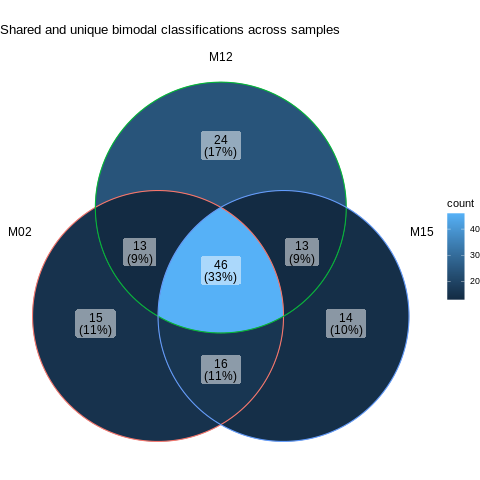

In [ ]:
%%R
# The genes separated by sample
VENgenes <- list()
for (DATASET in unique(FINALtable$Dataset)){
    for (SAMPLE in unique(FINALtable$Sample)){
        # We separate the table by sample and dataset
        VENgenes[[SAMPLE]] <- FINALtable[FINALtable$Dataset == DATASET & FINALtable$Sample == SAMPLE & !is.na(FINALtable$Bimodality), c("Gene", "Bimodality")]
          
    }
    # We want to know the gene and classification separated by samples
    # for each sample, we paste the gene and the classfication
    VENgenes <- lapply(VENgenes, function(x) apply(x, 1, function(y) paste(y[1], y[2])))

    print(ggVennDiagram(VENgenes) + ggtitle("Shared and unique bimodal classifications across samples"))
    #ggsave(paste(IMAGEdir, "VENNbimodalityClassificationSamples.Rds"))
}

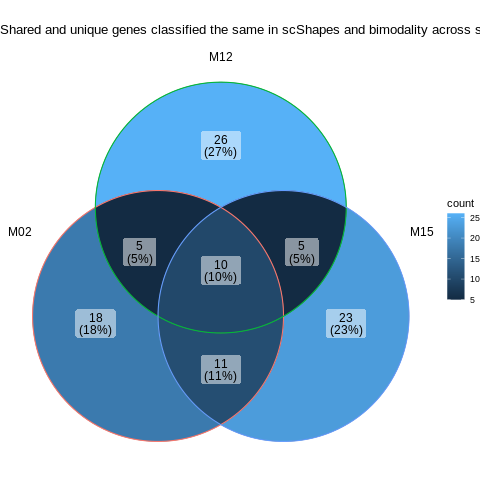

In [ ]:
%%R
library(ggVennDiagram)
# The genes separated by sample
VENgenes <- list()
for (DATASET in unique(FINALtable$Dataset)){
    for (SAMPLE in unique(FINALtable$Sample)){
        # We separate the table by sample and dataset
        VENgenes[[SAMPLE]] <- FINALtable[FINALtable$Dataset == DATASET & FINALtable$Sample == SAMPLE & !is.na(FINALtable$Distribution) & !is.na(FINALtable$Bimodality), c("Gene", "Distribution", "Bimodality")]    
    }
    # We want to know the gene and classification separated by samples
    # for each sample, we paste the gene and the classfication
    VENgenes <- lapply(VENgenes, function(x) apply(x, 1, function(y) paste(y[1], y[2], y[3])))

    print(ggVennDiagram(VENgenes) + ggtitle("Shared and unique genes classified the same in scShapes and bimodality across samples"))
    #gggsave(paste(IMAGEdir, "VENNscShapesClassificationSamples.Rds"))
}

### Bimodality all samples

In [11]:
%%R
FILES <- list.files(path = TEMPdir, pattern = "Bimodality-")   # We read the Final scs files

BItable <- data.frame()
for (FILE in paste(TEMPdir, FILES, sep = "")){
    # Read final scshapes (List. For each distribution, which genes are classified as such distribution
    BIMO <- readRDS(FILE)

    # Which sample, list and dataset uses such file
    SAMPLE <- strsplit(FILE, "-")[[1]][3]
    LISTS <- strsplit(FILE, "-")[[1]][2]
    DATASET <- strsplit(strsplit(FILE, "-")[[1]][4], "[.]")[[1]][1]
    
    # Table of bimodality per gene. We use the 1.1 cutoff
    BIMO <- data.frame(BI = BIMO$BI, Bimodality = ifelse(BIMO$BI >= 1.1, "Bimodal", "No bimodal"), Gene = row.names(BIMO),
                       Sample = SAMPLE, List = LISTS, Dataset = DATASET)
    BItable <- rbind(BItable, BIMO)
}

[1] "---------------------------------------------------------"
[1] "NEW"


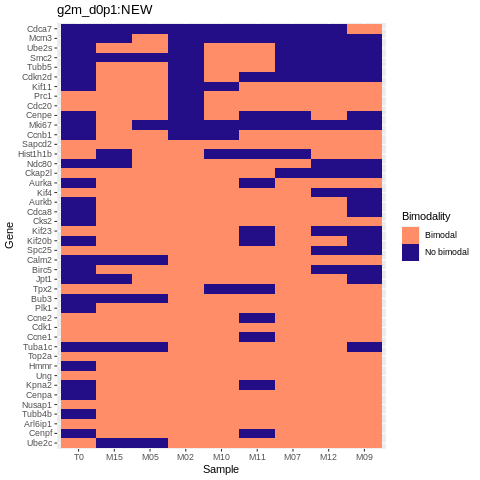

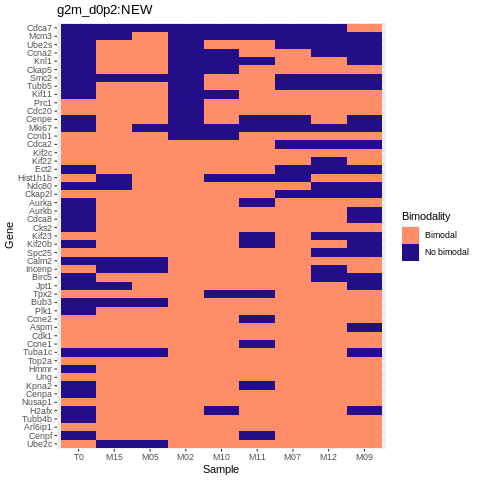

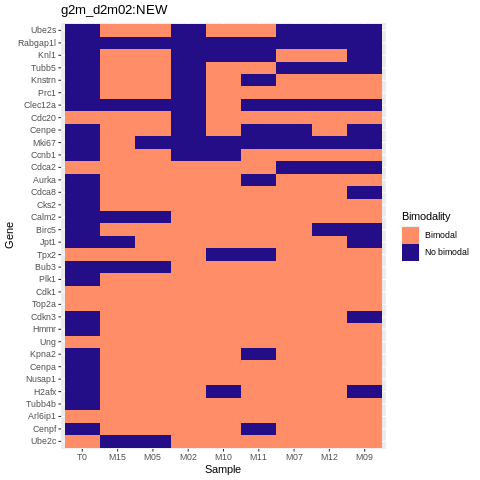

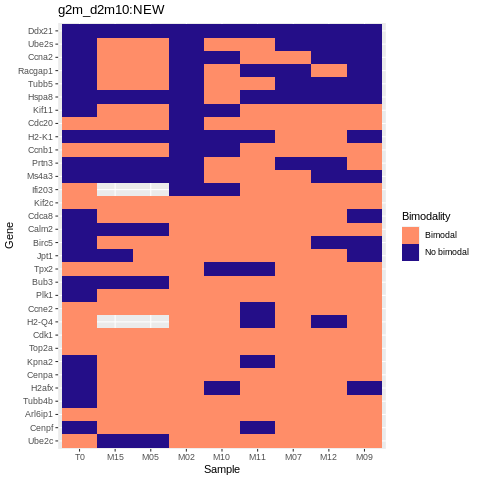

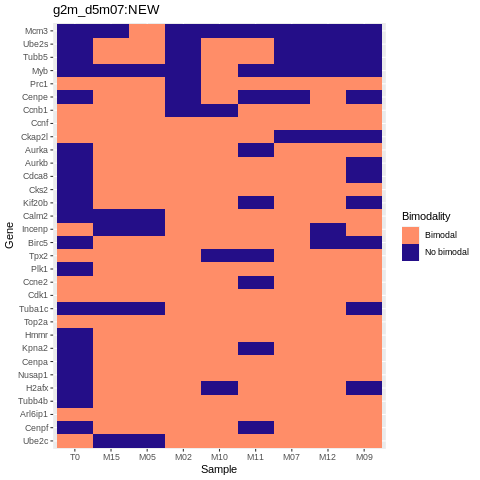

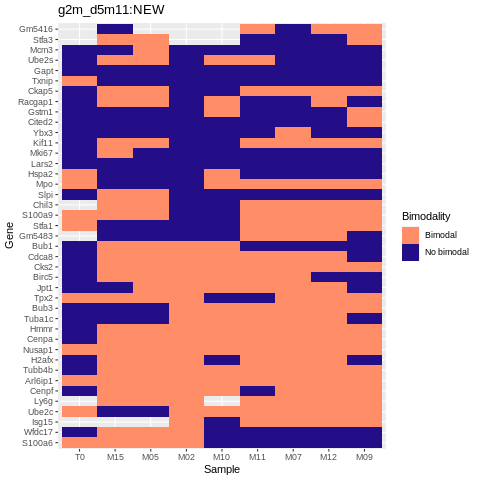

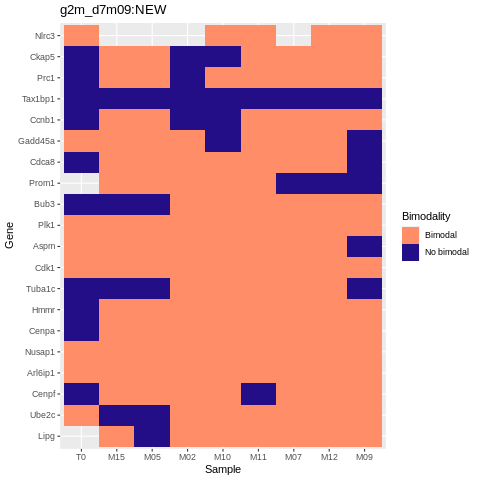

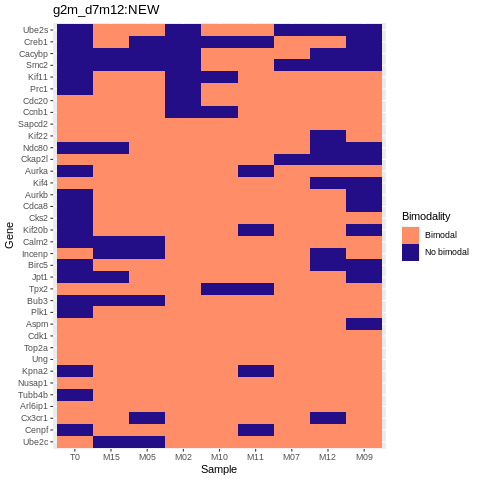

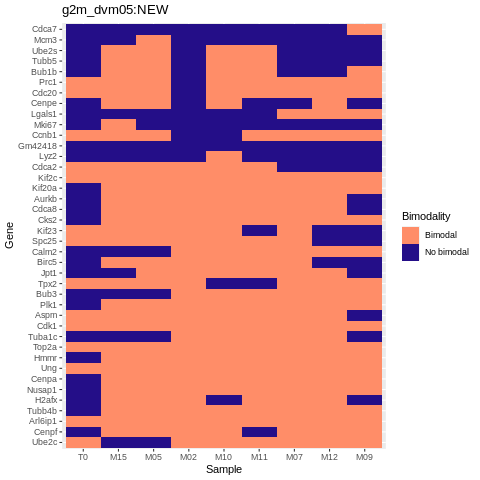

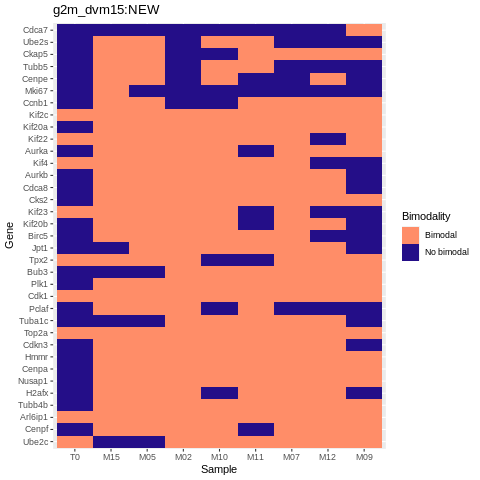

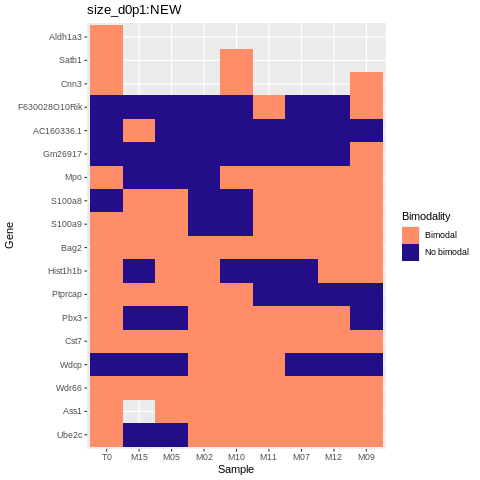

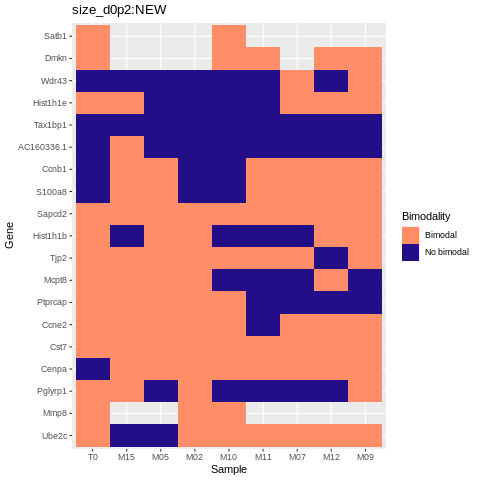

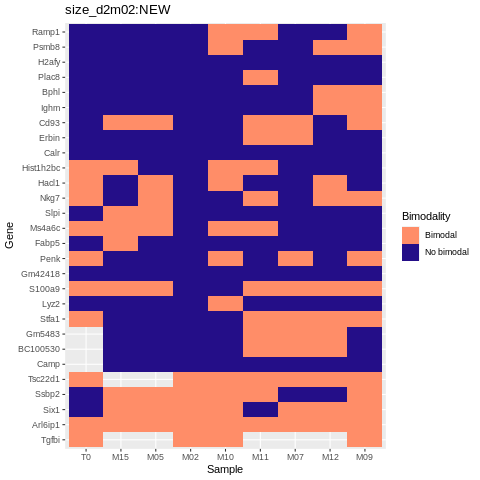

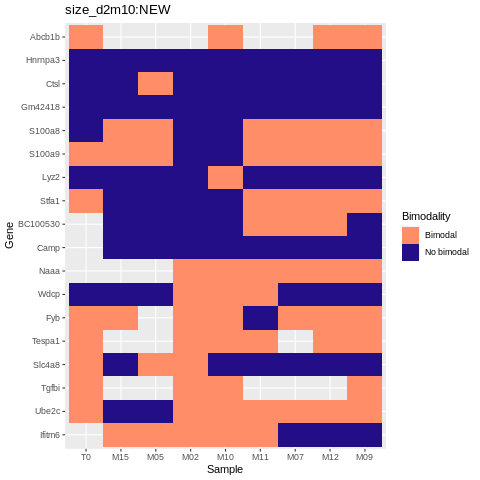

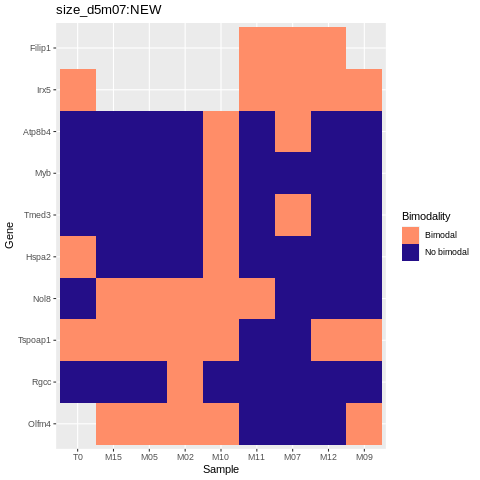

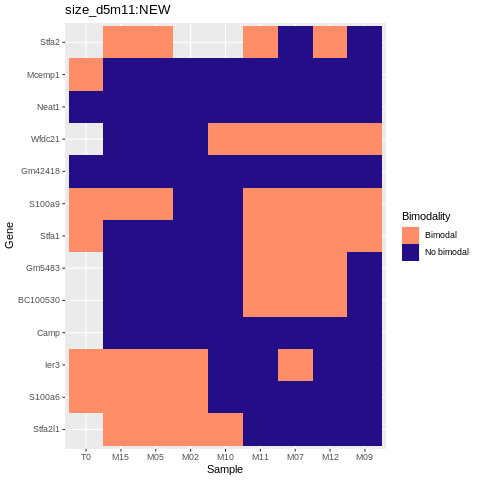

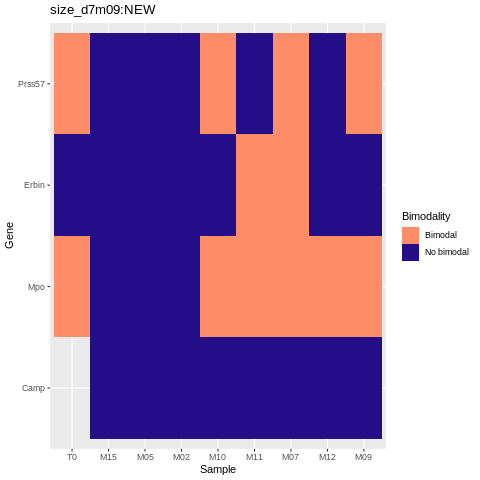

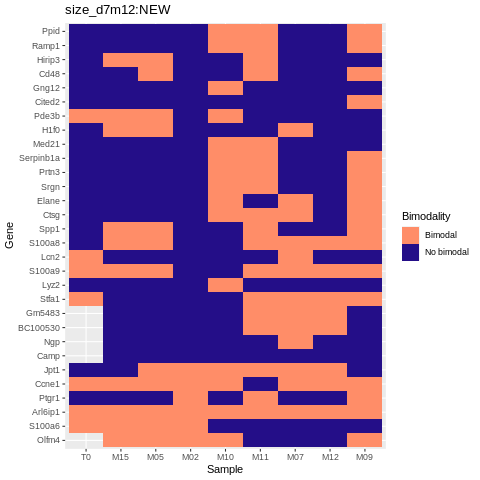

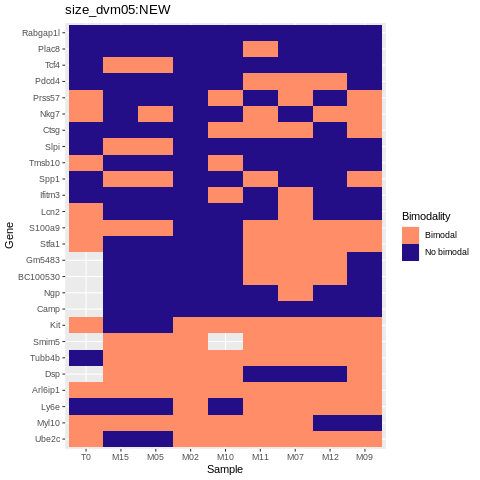

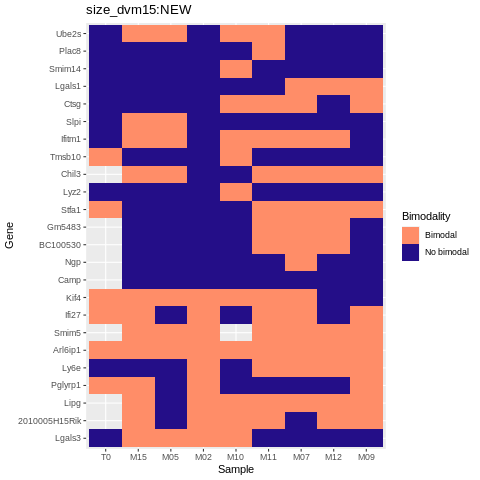

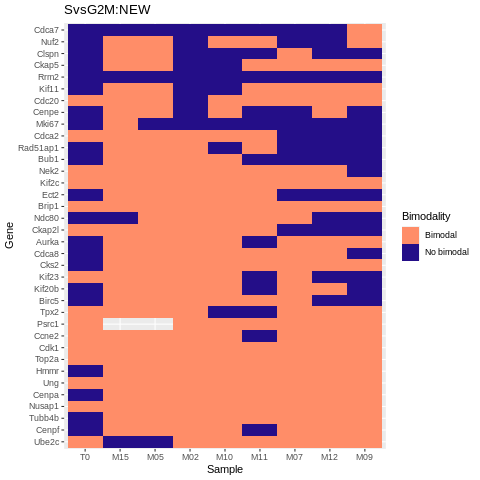

In [ ]:
%%R
# Our final table may have two types of datasets
for (DATASET in unique(BItable$Dataset)){
    print("---------------------------------------------------------")
    print(DATASET)
    # We are interested in analysing each list by separate
    for (LISTS in unique(BItable$List)){
        # Select only rows of interest
        TEMP <- BItable[BItable$List == LISTS & BItable$Dataset == DATASET & !is.na(BItable$Bimodality),]
        # This is the order of the y axis (genes), first we sort by sample and then by distribution (genes of the same distribution together)
        TEMP$Gene <- factor(TEMP$Gene, levels = unique(TEMP[order(TEMP$Sample,TEMP$Bimodality),]$Gene))
        TEMP$Sample <- factor(TEMP$Sample, levels = row.names(SAMPLESclass[[DATASET]]))
        print(ggplot(TEMP, aes(Sample, Gene, fill = Bimodality)) + geom_tile() + ggtitle(paste(LISTS, ":", DATASET, sep = ""))
        + scale_fill_manual(values = c("Bimodal" = "#FF8D68", "No bimodal" = "#240E88")))
    }
}

          TYPE Dataset Total
1  End Disease     NEW  1163
2  Mid Disease     NEW  1161
3 Post Disease     NEW  1170
         TYPE Bimodality         n Dataset Total
1 End Disease    Bimodal 0.6861565     NEW  1163
2 End Disease No bimodal 0.3138435     NEW  1163
3 Mid Disease    Bimodal 0.6416882     NEW  1161


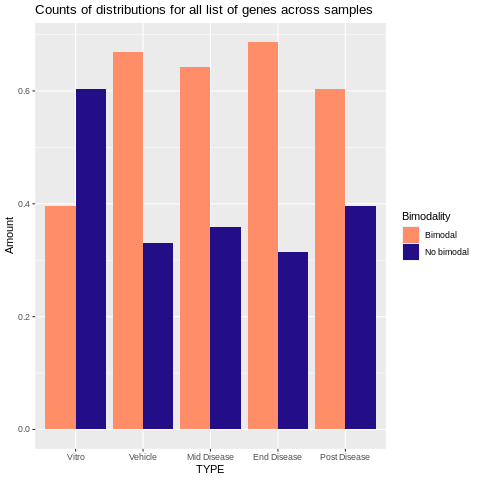

In [ ]:
%%R
SAM <- SAMPLESclass[[1]]
SAM$Sample <- row.names(SAM)
SAM$DAY <- NULL
BItype <- merge(BItable, SAM, by = "Sample")

# We want to know how many distributions we recover (Distributions) and differenciate this amount by Sample and Gene list
HISTable <- BItype[, c("TYPE", "Bimodality")]
HISTable[is.na(HISTable)] <- "Unclassified"   # More interesting name than NA
# Since we remove the gene column, the repeated rows are how many times a gene from the same sample and list was assogne with each distribution
# So... we count
TOTAL <- BItype[ , c("TYPE", "Dataset")]
TOTAL <- data.frame(TOTAL %>% group_by_all() %>% count)
names(TOTAL) <- c(names(TOTAL)[1:length(names(TOTAL))-1], "Total")
HISTable <- data.frame(HISTable %>% group_by_all() %>% count)

print(TOTAL[1:3,])
HISTable <- merge(HISTable, TOTAL, by = "TYPE")
HISTable$n <- HISTable$n / HISTable$Total
HISTable$TYPE <- factor(HISTable$TYPE, levels = c("Vitro", "Vehicle", "Mid Disease", "End Disease", "Post Disease"))


print(HISTable[1:3,])
#print(ggplot(HISTable, aes(x = TYPE, y = Expression)) + geom_violin(trim = FALSE) + ggtitle(paste(OLDnew, " ", SAMPLE)) + theme(axis.text.x = element_text(angle = 90))) 
# Finaly, the plot
ggplot(HISTable, aes(fill=Bimodality, y=n, x=TYPE)) + 
    geom_bar(position="dodge", stat="identity") +  ggtitle("Proportion") +
    scale_fill_manual(values = c("Bimodal" = "#FF8D68", "No bimodal" = "#240E88", "Unclassified" = "gray")) + ylab("Amount")


  Sample Bimodality   n Dataset Total
1    M02    Bimodal 344     NEW   579
2    M02 No bimodal 235     NEW   579
3    M05    Bimodal 386     NEW   570
  Sample Bimodality         n Dataset Total
1    M02    Bimodal 0.5941278     NEW   579
2    M02 No bimodal 0.4058722     NEW   579
3    M05    Bimodal 0.6771930     NEW   570


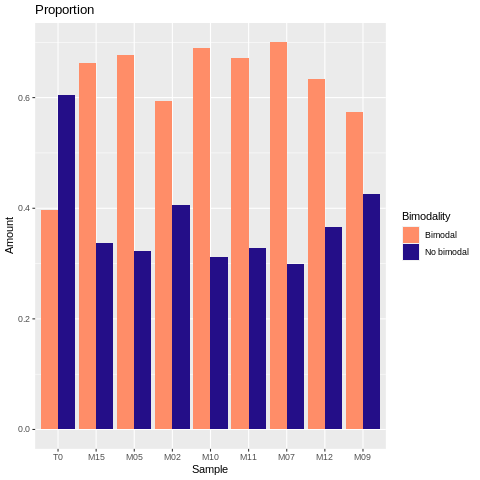

In [19]:
%%R
# We want to know how many distributions we recover (Distributions) and differenciate this amount by Sample and Gene list
HISTable <- BItable[, c("Sample", "Bimodality")]
HISTable[is.na(HISTable)] <- "Unclassified"   # More interesting name than NA

# Since we remove the gene column, the repeated rows are how many times a gene from the same sample and list was assogne with each distribution
# So... we count
TOTAL <- BItable[ , c("Sample", "Dataset")]
TOTAL <- data.frame(TOTAL %>% group_by_all() %>% count)
names(TOTAL) <- c(names(TOTAL)[1:length(names(TOTAL))-1], "Total")
HISTable <- data.frame(HISTable %>% group_by_all() %>% count)

HISTable <- merge(HISTable, TOTAL, by = "Sample")
print(HISTable[1:3, ])
HISTable$n <- HISTable$n / HISTable$Total
HISTable$Sample <- factor(HISTable$Sample, levels = row.names(SAMPLESclass[[DATASET]]))


print(HISTable[1:3,])
#print(ggplot(HISTable, aes(x = TYPE, y = Expression)) + geom_violin(trim = FALSE) + ggtitle(paste(OLDnew, " ", SAMPLE)) + theme(axis.text.x = element_text(angle = 90))) 
# Finaly, the plot
ggplot(HISTable, aes(fill=Bimodality, y=n, x=Sample)) + 
    geom_bar(position="dodge", stat="identity") +  ggtitle("Proportion") +
    scale_fill_manual(values = c("Bimodal" = "#FF8D68", "No bimodal" = "#240E88", "Unclassified" = "gray")) + ylab("Amount")



### Frecuency of each distribution

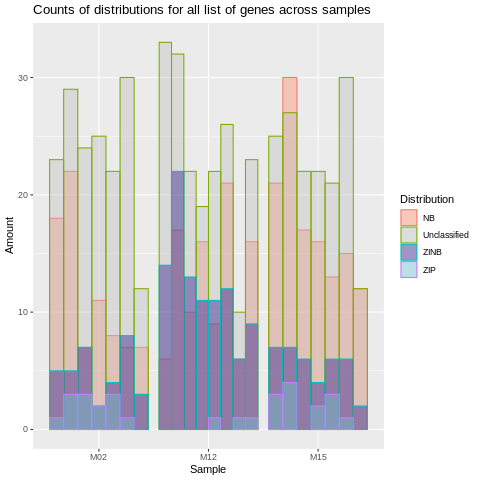

In [ ]:
%%R
# We want to know how many distributions we recover (Distributions) and differenciate this amount by Sample and Gene list
HISTable <- FINALtable[, c("Sample", "Distribution", "List")]
HISTable[is.na(HISTable)] <- "Unclassified"   # More interesting name than NA
# Since we remove the gene column, the repeated rows are how many times a gene from the same sample and list was assogne with each distribution
# So... we count
HISTable <- data.frame(HISTable %>% group_by_all() %>% count)

# Finaly, the plot
ggplot(HISTable, aes(fill=Distribution, y=n, x=Sample, group=List, color = Distribution)) + 
    geom_bar(position="dodge", stat="identity",  alpha=0.4) +  ggtitle("Counts of distributions for all list of genes across samples") +
    scale_fill_manual(values = c("NB" = "#FF8D68", "ZINB" = "#240E88", "ZIP" = "#69c9d0", "P" = "#FFC13D", "Unclassified" = "gray"))  + ylab("Amount")

#ggsave(paste(IMAGEdir, "FrequencyClasscShapesPerSample.png", sep = ""))

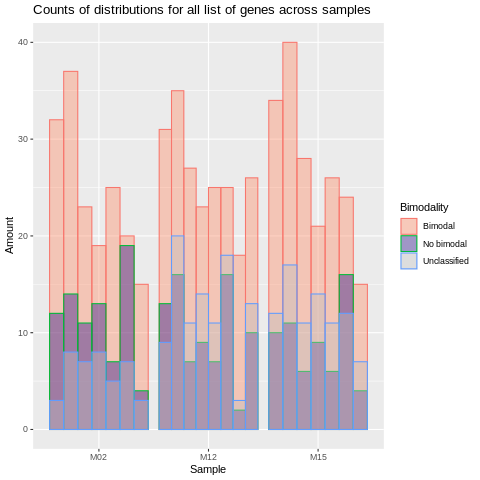

In [ ]:
%%R
# We want to know how many distributions we recover (Distributions) and differenciate this amount by Sample and Gene list
HISTable <- FINALtable[, c("Sample", "Bimodality", "List")]
HISTable[is.na(HISTable)] <- "Unclassified"   # More interesting name than NA
# Since we remove the gene column, the repeated rows are how many times a gene from the same sample and list was assogne with each distribution
# So... we count
HISTable <- data.frame(HISTable %>% group_by_all() %>% count)

# Finaly, the plot
ggplot(HISTable, aes(fill=Bimodality, y=n, x=Sample, group=List, color = Bimodality)) + 
    geom_bar(position="dodge", stat="identity",  alpha=0.4) +  ggtitle("Counts of distributions for all list of genes across samples") +
    scale_fill_manual(values = c("Bimodal" = "#FF8D68", "No bimodal" = "#240E88", "Unclassified" = "gray")) + ylab("Amount")

#ggsave(paste(IMAGEdir, "FrequencyClasscShapesPerSample.png", sep = ""))

In [ ]:
LENGTH <- lapply(GENESnewLists[1:3], length)
LENGTH <- data.frame(do.call(rbind, LENGTH))
colnames(LENGTH) <- c("Total")
LENGTH$List <- row.names(LENGTH)
merge(HISTable[c(1,2,8), ], LENGTH, by = "List")